# Notebook for OPRM and SRM measurement comparison 

In [1]:
import pandas as pd
import io
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import matplotlib
import matplotlib.colors as colors
import seaborn as sns
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
figsize = (6,6)

## file reading functions

In [3]:
def read_OPRM_file(path):
    DF = pd.read_csv(path, header = 4, index_col=None)
    DF['step'] = DF['DEMAG']
    DF['dec'] = pmag.cart2dir(DF[['X','Y','Z']].to_numpy()).T[0]
    DF['inc'] = pmag.cart2dir(DF[['X','Y','Z']]).T[1]
    DF['Ms'] = DF['M']
    DF['blank']=""
    DF['quality'] = 'g'
    
    return DF
        
def read_SRM_file(path):
    data = open(path)
    data_lines = data.readlines()

    DF = pd.DataFrame()
    step = []
    decs = []
    incs = []
    Ms = []
    for i in data_lines[2:]:
        if i[3:7] == '    ':
            step.append('NRM')
        else:
            step.append(i[3:7])
        decs.append(float(i[46:51]))
        incs.append(float(i[52:58]))
        Ms.append(float(i[31:39]))
    DF['step'] = step
    DF['dec'] = decs
    DF['inc'] = incs
    DF['Ms'] = Ms
    DF['blank']=""
    DF['quality'] = 'g'
    return DF
        
def fisher_mean(data):
    R, Xbar, X, fpars = 0, [0, 0, 0], [], {}
    N = len(data)
    if N < 2:
        return fpars
    X = pmag.dir2cart(data)
    for i in range(len(X)):
        for c in range(3):
            Xbar[c] += X[i][c]
    for c in range(3):
        R += Xbar[c]**2
    R = np.sqrt(R)
    for c in range(3):
        Xbar[c] = Xbar[c]/R
    direction = pmag.cart2dir(Xbar)
    b = 20.**(1./(N - 1.)) - 1
    a = 1 - b * (N - R) / R
    if a < -1:
        a = -1
    a95 = np.degrees(np.arccos(a))
    return direction

def average_measurements(DF):
    # assumes that this takes in the output dataframe from the two functions above
#     func = lambda df: fisher_mean(ipmag.make_di_block(df['dec'], df['inc']))
    unique_steps = DF['step'].unique()
    output_DF = pd.DataFrame(columns=['step', 'dec', 'inc', 'Ms', 'blank', 'quality'])
    for i in unique_steps:
        DF_step = DF[DF['step'] == i]
#         print(i)
#         display(DF_step)
        if DF_step.shape[0] == 1:
            output_DF.append(DF_step[['step', 'dec', 'inc', 'Ms', 'blank', 'quality']], ignore_index = True)
        else:
            mean_dir = ipmag.fisher_mean(DF_step['dec'].tolist(), DF_step['inc'].tolist())
#             display(mean_dir)
            mean_mom = np.mean(DF_step['Ms'])
            this_record = pd.DataFrame([[i, mean_dir['dec'], mean_dir['inc'], mean_mom, "", 'g']], columns=['step', 'dec', 'inc', 'Ms', 'blank', 'quality'])
#             display(this_record)
            output_DF = pd.concat([output_DF,this_record], ignore_index=True)

    return output_DF

## rewrite OPRM data file to SRM CIT format

In [4]:
def rewrite_OPRM_data(path, specimen_name):
    pd.set_option('display.float_format', '{:.2E}'.format)
#     I need first line of specimen name
    lines = []
    lines.append(specimen_name+'\n')
    lines.append('    0.0   0.0   0.0   0.0   0.0   1.0\n')
    
    DF = pd.read_csv(path, header = 4, index_col=None)
    
    DF['step'] = DF['DEMAG']
    DF['dec'] = np.round(pmag.cart2dir(DF[['X','Y','Z']].to_numpy()).T[0],1)
    DF['inc'] = np.round(pmag.cart2dir(DF[['X','Y','Z']]).T[1],1)
#     DF['inc'] = [format(i, '02d') for i in DF['inc']]
    DF['Ms'] = ['{:.2E}'.format(i) for i in DF['M']]
    DF['X'] = ['{:06.6f}'.format(i*10,6) for i in np.abs(DF['X'])]
    DF['Y'] = ['{:06.6f}'.format(i*10,6) for i in np.abs(DF['Y'])]
    DF['Z'] = ['{:06.6f}'.format(i*10,6) for i in np.abs(DF['Z'])]
#     DF['datetime'] = [datetime.i.strftime("%Y-%m-%d, %H:%M:%S") for i in DF['Date&Time']]
    DF['inc'] = ['{: 05.1f}'.format(i) for i in DF['inc']]
    DF['dec'] = ['{:05.1f}'.format(i) for i in DF['dec']]
    DF = DF.astype(str)
    
#     print(DF['Date&Time'])
    for i in range(DF.shape[0]):
        if DF['step'][i]  == 'NRM':
            lines.append('NRM    ')
        else:
            lines.append('TT '+DF['step'][i]+' '
                         +DF['dec'][i]+' '+DF['inc'][i]+' '
                         +DF['dec'][i]+' '+DF['inc'][i]+' '
                         +DF['Ms'][i]+' '
                         +'001.0 '
                         +DF['dec'][i]+' '+DF['inc'][i]+' '
                         +DF['X'][i]+' '
                         +DF['Y'][i]+' '
                         +DF['Z'][i]+' '
                         +'OPRM '
                         +DF['Date&Time'][i]
                         + DF['Unnamed: 11'][i]
                         +' \n'
                            )
            
    fd = io.open('OPRM_data_CIT/'+specimen_name, 'w+')
    for i in lines:
        fd.write(i)
    return lines

In [5]:
rewrite_OPRM_data('OPRM_data/CS1-1a.csv', 'CS1-1a')
rewrite_OPRM_data('OPRM_data/CS2-1a.csv', 'CS2-1a')
rewrite_OPRM_data('OPRM_data/CS3-1a.csv', 'CS3-1a')
rewrite_OPRM_data('OPRM_data/CS7-1a.csv', 'CS7-1a')
rewrite_OPRM_data('OPRM_data/CS8-1a.csv', 'CS8-1a')
rewrite_OPRM_data('OPRM_data/CS9-1a.csv', 'CS9-1a')

['CS9-1a\n',
 '    0.0   0.0   0.0   0.0   0.0   1.0\n',
 'TT 450 099.6 -18.5 099.6 -18.5 9.82E-06 001.0 099.6 -18.5 0.000016 0.000092 0.000031 OPRM 8-Jun 2021 09:41 \n',
 'TT 450 099.4 -19.3 099.4 -19.3 9.57E-06 001.0 099.4 -19.3 0.000015 0.000089 0.000032 OPRM 8-Jun 2021 09:43 \n',
 'TT 450 097.8 -19.7 097.8 -19.7 9.31E-06 001.0 097.8 -19.7 0.000012 0.000087 0.000031 OPRM 8-Jun 2021 09:45 \n',
 'TT 475 095.6 -19.1 095.6 -19.1 8.06E-06 001.0 095.6 -19.1 0.000007 0.000076 0.000026 OPRM 8-Jun 2021 15:18 \n',
 'TT 475 087.3 -15.1 087.3 -15.1 8.61E-06 001.0 087.3 -15.1 0.000004 0.000083 0.000023 OPRM 8-Jun 2021 16:10 \n',
 'TT 475 091.4 -20.2 091.4 -20.2 8.48E-06 001.0 091.4 -20.2 0.000002 0.000080 0.000029 OPRM 8-Jun 2021 16:11 \n',
 'TT 500 098.4 -09.5 098.4 -09.5 7.49E-06 001.0 098.4 -09.5 0.000011 0.000073 0.000012 OPRM 9-Jun 2021 11:30 \n',
 'TT 500 096.0 -21.5 096.0 -21.5 7.82E-06 001.0 096.0 -21.5 0.000008 0.000072 0.000029 OPRM 9-Jun 2021 11:32 \n',
 'TT 500 095.9 -21.1 095.9 -21.

## adjusting and rewrite pmagpy functions

### plot_net()

In [6]:
def plot_net(fignum=None):
    plt.axis("off")
    Dcirc = np.arange(0, 361.)
    Icirc = np.zeros(361, 'f')
    Xcirc, Ycirc = [], []
    for k in range(361):
        XY = pmag.dimap(Dcirc[k], Icirc[k])
        Xcirc.append(XY[0])
        Ycirc.append(XY[1])
    plt.plot(Xcirc, Ycirc, 'k');

    Xsym, Ysym = [], []
    for I in range(10, 100, 10):
        XY = pmag.dimap(0., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(90., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(180., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(270., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    for D in range(0, 360, 10):
        Xtick, Ytick = [], []
        for I in range(4):
            XY = pmag.dimap(D, I)
            Xtick.append(XY[0])
            Ytick.append(XY[1])
        plt.plot(Xtick, Ytick, 'k')
    plt.axis("equal")
    plt.axis((-1.05, 1.05, -1.05, 1.05))

### plot_eq()

In [7]:
def plot_eq(DIblock, specimen_name, fignum=0):
    if len(DIblock) < 1:
        return
    plot_net(fignum=fignum);
    ipmag.plot_di(di_block=DIblock, color = 'blue');  # plot directions
    plt.axis("equal")
    plt.text(-1.1, 1.15, specimen_name)

### plot_zij()

In [8]:
def plot_zij(datablock, s=None, norm=None):
    if norm == 0:
        fact = 1.
    else:
        try:
            fact = (1./datablock[0][3])   # normalize to NRM=1
        except ZeroDivisionError:
            fact = 1.
    # convert datablock to DataFrame data with  dec,inc, int
    data = pd.DataFrame(datablock)
    if len(data.columns) == 5:
        data.columns = ['treat', 'dec', 'inc', 'int', 'quality']
    if len(data.columns) == 6:
        data.columns = ['treat', 'dec', 'inc', 'int', 'type', 'quality']
    elif len(data.columns) == 7:
        data.columns = ['treat', 'dec', 'inc', 'int', 'type', 'quality', 'y']
    
    data['int'] = data['int']*fact  # normalize
    data['dec'] = (data['dec'])  # adjust X axis angle
    gdata = data[data['quality'].str.contains('g')]
    bdata = data[data['quality'].str.contains('b')]
    forVDS = gdata[['dec', 'inc', 'int']].values
    gXYZ = pd.DataFrame(pmag.dir2cart(forVDS))
    gXYZ.columns = ['Y', 'X', 'Z']
    gXYZ['Z'] = -gXYZ['Z']
    
    xmax = max([gXYZ.X.max(),0])
    xmin = min([gXYZ.X.min(),0])
    ymax = gXYZ.Y.max()
    ymin = gXYZ.Y.min()
    zmax = gXYZ.Z.max()
    zmin = gXYZ.Z.min()
    
    YZ_min = min([ymin, zmin,0])
    YZ_max = max([ymax, zmax,0])
    
    bXYZ = pmag.dir2cart(bdata[['dec', 'inc', 'int']].values).transpose()
    
    if len(bXYZ) > 0:
        plt.scatter(bXYZ[0], bXYZ[1], marker='d', c='y', s=30)
        plt.scatter(bXYZ[0], bXYZ[2], marker='d', c='y', s=30)
    plt.plot(gXYZ['X'], gXYZ['Y'], 'ro', label='horizontal (XY) axis')
    plt.plot(gXYZ['X'], gXYZ['Z'], 'ws', markeredgecolor='blue', label='vertical (XZ) axis')
    plt.plot(gXYZ['X'], gXYZ['Y'], 'r-')
    plt.plot(gXYZ['X'], gXYZ['Z'], 'b-')
    for k in range(len(gXYZ)):
        plt.annotate(str(k), (gXYZ['X'][k], gXYZ['Z']
                              [k]), ha='left', va='bottom')
    
    xline = [xmin, xmax]
    yline = [YZ_min, YZ_max]
    zline = [0, 0]
    plt.ylim(YZ_min, YZ_max)
    plt.xlim(xmin, xmax)
    plt.plot(xline, zline, 'k-')
    plt.plot(zline, yline, 'k-')
    plt.ylabel('Circles: Y; Squares: Z')
    tstring = s + ': NRM = ' + '%9.2e' % (datablock[0][3])
    plt.axis([xmin, xmax, YZ_min, YZ_max])
    plt.axis("equal")
    plt.legend(loc='upper right')
    plt.title(tstring)

### pmag_plot_mag()

In [9]:
def pmag_plot_mag(datablock, s, units='C', norm=False):
    Ints = []
    for plotrec in datablock:
        Ints.append(plotrec[3])
    Ints.sort()

    T, M, Tv, recnum = [], [], [], 0
    Mex, Tex, Vdif = [], [], []
    recbak = []
    for rec in datablock:
        if rec[5] == 'g':
            if units == "T":
                T.append(rec[0] * 1e3)
                Tv.append(rec[0] * 1e3)
                if recnum > 0:
                    Tv.append(rec[0] * 1e3)
            elif units == "U":
                T.append(rec[0])
                Tv.append(rec[0])
                if recnum > 0:
                    Tv.append(rec[0])
            elif units == "K":
                T.append(rec[0] - 273)
                Tv.append(rec[0] - 273)
                if recnum > 0:
                    Tv.append(rec[0] - 273)
            elif "T" in units and "K" in units:
                if rec[0] < 1.:
                    T.append(rec[0] * 1e3)
                    Tv.append(rec[0] * 1e3)
                else:
                    T.append(rec[0] - 273)
                    Tv.append(rec[0] - 273)
                    if recnum > 0:
                        Tv.append(rec[0] - 273)
            else:
                T.append(rec[0])
                Tv.append(rec[0])
                if recnum > 0:
                    Tv.append(rec[0])
            if norm:
                M.append(pmag.old_div(rec[3], Ints[-1]))
            else:
                M.append(rec[3])
            if recnum > 0 and len(rec) > 0 and len(recbak) > 0:
                v = []
                if recbak[0] != rec[0]:
                    V0 = pmag.dir2cart([recbak[1], recbak[2], recbak[3]])
                    V1 = pmag.dir2cart([rec[1], rec[2], rec[3]])
                    for el in range(3):
                        v.append(abs(V1[el] - V0[el]))
                    vdir = pmag.cart2dir(v)
                    # append vector difference
                    Vdif.append(pmag.old_div(vdir[2], Ints[-1]))
                    Vdif.append(pmag.old_div(vdir[2], Ints[-1]))
            recbak = []
            for el in rec:
                recbak.append(el)
            delta = .005 * M[0]
#             if num == 1:
#                 if recnum % 2 == 0:
#                     plt.text(T[-1] + delta, M[-1],
#                              (' ' + str(recnum)), fontsize=9)
            recnum += 1
        else:
            if rec[0] < 200:
                Tex.append(rec[0] * 1e3)
            if rec[0] >= 200:
                Tex.append(rec[0] - 273)
            Mex.append(pmag.old_div(rec[3], Ints[-1]))
            recnum += 1

    if len(Mex) > 0 and len(Tex) > 0:
        plt.scatter(Tex, Mex, marker='d', color='k')
    if len(Vdif) > 0:
        Vdif.append(pmag.old_div(vdir[2], Ints[-1]))
        Vdif.append(0)
    if Tv:
        Tv.append(Tv[-1])
    plt.plot(T, M)
    plt.plot(T, M, 'ro')
    if len(Tv) == len(Vdif) and norm:
        plt.plot(Tv, Vdif, 'g-')
    if units == "T":
        plt.xlabel("Step (mT)")
    elif units == "K":
        plt.xlabel("Step (C)")
    elif units == "J":
        plt.xlabel("Step (J)")
    else:
        plt.xlabel("Step [mT,C]")
    if norm == 1:
        plt.ylabel("Fractional Magnetization")
    if norm == 0:
        plt.ylabel("Magnetization")
    plt.axvline(0, color='k')
    plt.axhline(0, color='k')
    tstring = s
    plt.title(tstring)

### plot_mag()

In [10]:
def plot_mag(datablock, specimen_name, unit='C', norm=False):
    data = pd.DataFrame(datablock)
    data.columns = ['treat', 'dec', 'inc', 'int', 'type', 'quality']
    steps=[]
    Ms=[]
    for i in range(data.shape[0]):
        if data['treat'].tolist()[i]=='NRM':
            steps.append(0)
            Ms.append(data['int'][i])
        else:
#             assert data['treat'].tolist()[i] is not str
            steps.append(float(data['treat'].tolist()[i]))
            Ms.append(data['int'][i])
    plt.scatter(steps,Ms, color = 'dodgerblue')
    plt.plot(steps,Ms, color = 'dodgerblue')
    plt.xlabel('thermal step')
    plt.xlim(min(steps)-1, max(steps)*1.05)
    plt.xticks([0, 100, 200, 300, 400, 500, 600])
    plt.ylim(min(Ms)*0.95, max(Ms)*1.05)
    plt.ylabel('moment (emu)')
    plt.title(specimen_name+'moment decay plot')
    
    return steps,Ms

### moment_comparison()

In [11]:
def moment_comparison(SRM_steps, SRM_Ms, OPRM_steps, OPRM_Ms, OPRM_steps_all, OPRM_Ms_all, specimen_name=None, savefig=False):

    plt.figure(figsize=(15,10))
    plt.scatter(SRM_steps, SRM_Ms, color = 'limegreen', label='SRM data')
    plt.plot(SRM_steps, SRM_Ms, color = 'limegreen')
    plt.scatter(OPRM_steps, OPRM_Ms, color = 'red', label='OPRM data')
    plt.plot(OPRM_steps, OPRM_Ms, color = 'red')
    plt.scatter(OPRM_steps_all, OPRM_Ms_all, color = 'lightcoral', label='OPRM data all')
    plt.plot(OPRM_steps_all, OPRM_Ms_all, color = 'lightcoral')
    
    plt.xlabel('thermal step')
    plt.xlim(min(SRM_steps+OPRM_steps)-1, max(SRM_steps+OPRM_steps)*1.05)
    plt.xticks([0, 100, 200, 300, 400, 500, 600])
    plt.ylim(min(SRM_Ms+OPRM_Ms)*0.95, max(SRM_Ms+OPRM_Ms)*1.05)
    plt.ylabel('moment (emu)')
    plt.title('moment decay plot comparison')
    plt.legend()
    if savefig:
        plt.savefig('Figures/'+specimen_name+'_moment_comparison.pdf')
    plt.show()

### moment_comparison_normalized()

In [107]:
def normalize(list):
    return np.array([i/max(list) for i in list])

def moment_comparison_normalized(SRM_steps, SRM_Ms, OPRM_steps, OPRM_Ms, OPRM_steps_all, OPRM_Ms_all, specimen_name=None, savefig=False):
    SRM_Ms = normalize(SRM_Ms)
    
    # normalize OPRM data 
    OPRM_Ms = normalize(OPRM_Ms)*SRM_Ms[SRM_steps.index(OPRM_steps[0])]/max(SRM_Ms)
    OPRM_Ms_all = normalize(OPRM_Ms_all)*SRM_Ms[SRM_steps.index(OPRM_steps_all[0])]/max(SRM_Ms)
    
#     OPRM_Ms = normalize(OPRM_Ms)
#     OPRM_Ms_all = normalize(OPRM_Ms_all)
    
    plt.figure(figsize=(15,10))
    plt.scatter(SRM_steps, SRM_Ms, color = 'limegreen', label='SRM data')
    plt.plot(SRM_steps, SRM_Ms, color = 'limegreen')
    plt.scatter(OPRM_steps, OPRM_Ms, color = 'red', label='OPRM data')
    plt.plot(OPRM_steps, OPRM_Ms, color = 'red')
    plt.scatter(OPRM_steps_all, OPRM_Ms_all, color = 'lightcoral', label='OPRM data all')
    plt.plot(OPRM_steps_all, OPRM_Ms_all, color = 'lightcoral')
    
    plt.xlabel('thermal step')
    plt.xlim(min(SRM_steps+OPRM_steps)-1, max(SRM_steps+OPRM_steps)*1.05)
    plt.xticks([0, 100, 200, 300, 400, 500, 600])
    plt.ylim(min(np.concatenate((SRM_Ms,OPRM_Ms)))*0.95, max(np.concatenate((SRM_Ms,OPRM_Ms)))*1.05)
    plt.ylabel('moment (normalized)')
    plt.title('normalized moment decay plot comparison')
    plt.legend()
    if savefig:
        plt.savefig('Figures/'+specimen_name+'_normalized_moment_comparison.pdf')
    plt.show()

## holder OPRM

I did 10 measurement of the blank holder using only +Z measurement mode on the OPRM. The moment is quite consistent around E-7.

In [13]:
Holder_OPRM = read_OPRM_file('OPRM_data/Holder.csv')
# Holder = Holder.drop(0)
# Holder = Holder.reset_index()
Holder_OPRM

DEMAG       CD        CI        M         X         Y         Z      S/D  \
0    NRM 3.56E+02  8.95E+01 2.98E-05  2.36E-07 -1.47E-08  2.98E-05 7.80E-04   
1    NRM 1.85E+02 -1.68E+01 3.63E-08 -3.46E-08 -3.01E-09 -1.05E-08 1.16E-02   
2    NRM 3.07E+02 -7.95E+01 1.71E-07  1.88E-08 -2.47E-08 -1.68E-07 2.99E-01   
3    NRM 2.82E+02 -4.42E+01 1.74E-07  2.56E-08 -1.23E-07 -1.22E-07 5.41E-01   
4    NRM 2.94E+02 -6.27E+01 2.03E-07  3.75E-08 -8.53E-08 -1.81E-07 4.36E-01   
5    NRM 2.57E+02 -6.81E+01 1.30E-07 -1.07E-08 -4.72E-08 -1.21E-07 4.09E-01   
6    NRM 2.96E+02 -4.85E+01 2.22E-07  6.43E-08 -1.33E-07 -1.67E-07 5.04E+00   
7    NRM 3.14E+02 -5.60E+01 1.89E-07  7.35E-08 -7.64E-08 -1.57E-07 1.93E+00   
8    NRM 2.40E+02 -1.85E+01 1.35E-07 -6.28E-08 -1.11E-07 -4.29E-08 9.40E-01   
9    NRM 2.92E+02 -4.66E+01 1.47E-07  3.82E-08 -9.31E-08 -1.07E-07 1.78E-01   
10   NRM 2.54E+02 -5.92E+01 1.26E-07 -1.80E-08 -6.19E-08 -1.08E-07 7.73E-02   
11   NRM 2.79E+02 -5.45E+01 1.33E-07  1.17E-08 -7.61E-08 -1.08E-07 3.75E-01   

    S/H  Orientation Date&Time  Unnamed: 11 step      dec       inc       Ms  \
0     0  T_4MR_T+Z-Z     2-Jun   2021 15:23  NRM 3.56E+02  8.95E+01 2.98E-05   
1     0  T_4MR_T+Z-Z     2-Jun   2021 15:27  NRM 1.85E+02 -1.68E+01 3.63E-08   
2     0    T_4MR_T+Z     2-Jun   2021 15:30  NRM 3.07E+02 -7.95E+01 1.71E-07   
3     0    T_4MR_T+Z     2-Jun   2021 15:31  NRM 2.82E+02 -4.42E+01 1.74E-07   
4     0    T_4MR_T+Z     2-Jun   2021 15:32  NRM 2.94E+02 -6.28E+01 2.03E-07   
5     0    T_4MR_T+Z     2-Jun   2021 15:33  NRM 2.57E+02 -6.82E+01 1.30E-07   
6     0    T_4MR_T+Z     2-Jun   2021 15:34  NRM 2.96E+02 -4.85E+01 2.22E-07   
7     0    T_4MR_T+Z     2-Jun   2021 15:35  NRM 3.14E+02 -5.60E+01 1.89E-07   
8     0    T_4MR_T+Z     2-Jun   2021 15:35  NRM 2.41E+02 -1.86E+01 1.35E-07   
9     0    T_4MR_T+Z     2-Jun   2021 15:36  NRM 2.92E+02 -4.68E+01 1.47E-07   
10    0    T_4MR_T+Z     2-Jun   2021 15:37  NRM 2.54E+02 -5.92E+01 1.26E-07   
11    0    T_4MR_T+Z     2-Jun   2021 15:37  NRM 2.79E+02 -5.45E+01 1.33E-07   

   blank quality  
0              g  
1              g  
2              g  
3              g  
4              g  
5              g  
6              g  
7              g  
8              g  
9              g  
10             g  
11             g

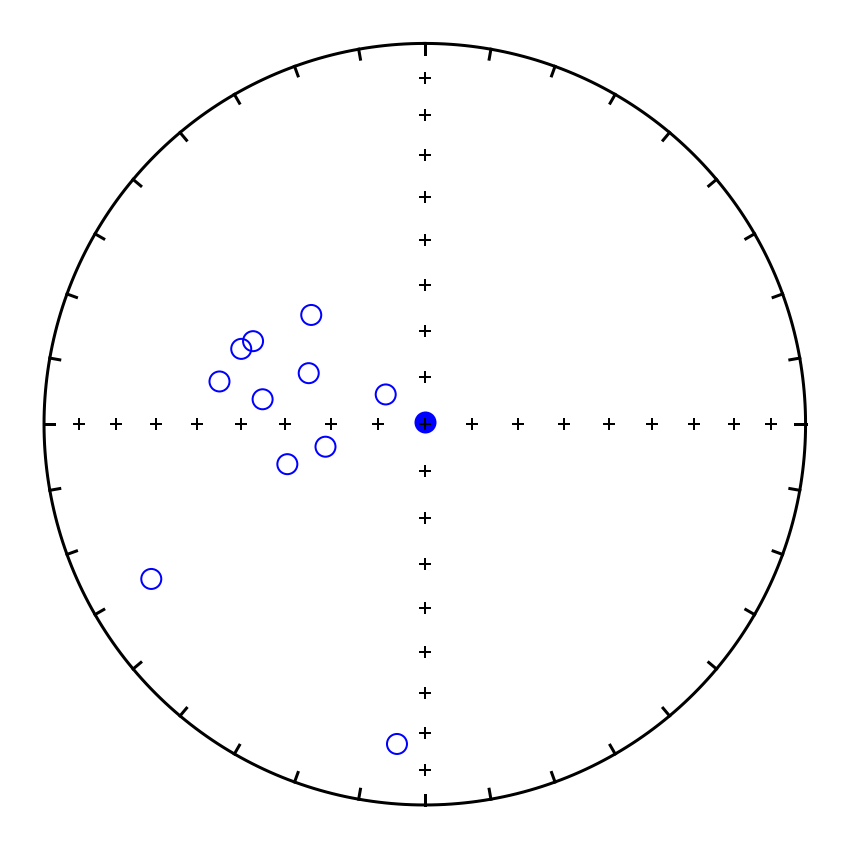

In [14]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Holder_OPRM['dec'], Holder_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM holder')


## X standard sample

### OPRM X

I did 5 measurements of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 1.08 E-3 but OPRM gives consistently 8E-4 (emu).

In [15]:
X_OPRM = read_OPRM_file('OPRM_data/X.csv')
X_OPRM = X_OPRM.drop(0)
X_OPRM = X_OPRM.reset_index()
X_OPRM

index DEMAG       CD       CI        M        X         Y        Z  \
0       1   NRM 3.50E+02 3.00E+00 7.43E-04 7.32E-04 -1.23E-04 3.88E-05   
1       2   NRM 3.55E+02 9.00E-01 7.22E-04 7.19E-04 -6.30E-05 1.08E-05   
2       3   NRM 3.54E+02 2.00E-01 1.10E-03 1.09E-03 -1.15E-04 3.99E-06   
3       4   NRM 3.59E+02 1.00E+00 1.08E-03 1.08E-03 -2.44E-05 1.93E-05   
4       5   NRM 3.56E+02 1.10E+00 8.41E-04 8.39E-04 -5.78E-05 1.58E-05   
5       6   NRM 3.55E+02 1.00E-01 9.13E-04 9.10E-04 -7.53E-05 1.48E-06   
6       7   NRM 3.56E+02 1.00E+00 8.67E-04 8.64E-04 -6.21E-05 1.53E-05   
7       8   NRM 3.56E+02 3.00E-01 8.63E-04 8.60E-04 -5.97E-05 4.63E-06   
8       9   NRM 3.55E+02 3.00E-01 6.40E-04 6.38E-04 -5.64E-05 3.52E-06   
9      10   NRM 3.56E+02 1.00E+00 8.73E-04 8.71E-04 -5.51E-05 1.58E-05   
10     11   NRM 3.55E+02 0.00E+00 8.71E-04 8.67E-04 -7.69E-05 7.11E-07   
11     12   NRM 3.55E+02 8.00E-01 8.55E-04 8.52E-04 -7.53E-05 1.22E-05   
12     13   NRM 3.56E+02 8.00E-01 8.37E-04 8.34E-04 -5.81E-05 1.13E-05   
13     14   NRM 3.55E+02 8.00E-01 8.08E-04 8.05E-04 -6.44E-05 1.08E-05   

        S/D  S/H  Orientation Date&Time step      dec      inc       Ms blank  \
0  2.86E+02    0    T_4MR_T+Z     1-Jun  NRM 3.50E+02 2.99E+00 7.43E-04         
1  1.14E+03    0  T_4MR_T+Z-Z     1-Jun  NRM 3.55E+02 8.57E-01 7.22E-04         
2  1.26E+02    0  T_4MR_T+Z-Z     1-Jun  NRM 3.54E+02 2.09E-01 1.10E-03         
3  1.39E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.59E+02 1.02E+00 1.08E-03         
4  1.14E+03    0  T_4MR_T+Z-Z     2-Jun  NRM 3.56E+02 1.08E+00 8.41E-04         
5  1.55E+01    0  T_4MR_T+Z-Z     2-Jun  NRM 3.55E+02 9.29E-02 9.13E-04         
6  1.00E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.56E+02 1.01E+00 8.67E-04         
7  9.49E+01    0  T_4MR_T+Z-Z     2-Jun  NRM 3.56E+02 3.08E-01 8.63E-04         
8  7.40E+01    0  T_4MR_T+Z-Z     2-Jun  NRM 3.55E+02 3.15E-01 6.40E-04         
9  7.52E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.56E+02 1.04E+00 8.73E-04         
10 3.58E+01    0  T_4MR_T+Z-Z     2-Jun  NRM 3.55E+02 4.68E-02 8.71E-04         
11 1.62E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.55E+02 8.17E-01 8.55E-04         
12 3.22E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.56E+02 7.74E-01 8.37E-04         
13 1.47E+02    0  T_4MR_T+Z-Z     2-Jun  NRM 3.55E+02 7.66E-01 8.08E-04         

   quality  
0        g  
1        g  
2        g  
3        g  
4        g  
5        g  
6        g  
7        g  
8        g  
9        g  
10       g  
11       g  
12       g  
13       g

### SRM X

In [16]:
X_SRM_DF = read_SRM_file('SRM_data/X')
X_SRM_DF = X_SRM_DF.drop(3)
X_SRM_DF = X_SRM_DF.reset_index(drop=True)
X_SRM_DF

step      dec       inc       Ms blank quality
0  NRM 5.80E+00 -6.00E-01 1.08E-03             g
1  NRM 4.30E+00 -6.00E-01 1.08E-03             g
2  NRM 3.60E+00 -6.00E-01 1.08E-03             g
3  NRM 2.80E+00 -6.00E-01 1.08E-03             g
4  NRM 4.90E+00 -6.00E-01 1.07E-03             g
5  NRM 3.59E+02 -6.00E-01 1.08E-03             g
6  NRM 6.70E+00 -6.00E-01 1.07E-03             g
7  NRM 5.70E+00 -6.00E-01 1.08E-03             g
8  NRM 2.10E+00 -6.00E-01 1.08E-03             g

In [17]:
X_OPRM_mean = ipmag.fisher_mean(0-X_OPRM['dec'], -X_OPRM['inc'])
X_SRM_mean = ipmag.fisher_mean(X_SRM_DF['dec'].tolist(), X_SRM_DF['inc'].tolist())

In [18]:
ipmag.print_direction_mean(X_OPRM_mean)


Dec: 4.7  Inc: -0.8
Number of directions in mean (n): 14
Angular radius of 95% confidence (a_95): 0.9
Precision parameter (k) estimate: 1806.0


In [19]:
ipmag.print_direction_mean(X_SRM_mean)

Dec: 3.9  Inc: -0.6
Number of directions in mean (n): 9
Angular radius of 95% confidence (a_95): 1.5
Precision parameter (k) estimate: 1158.0


In [20]:
angle_X = pmag.angle([X_OPRM_mean['dec'], X_OPRM_mean['inc']], [X_SRM_mean['dec'], X_SRM_mean['inc']])

### equal area plot for the directions

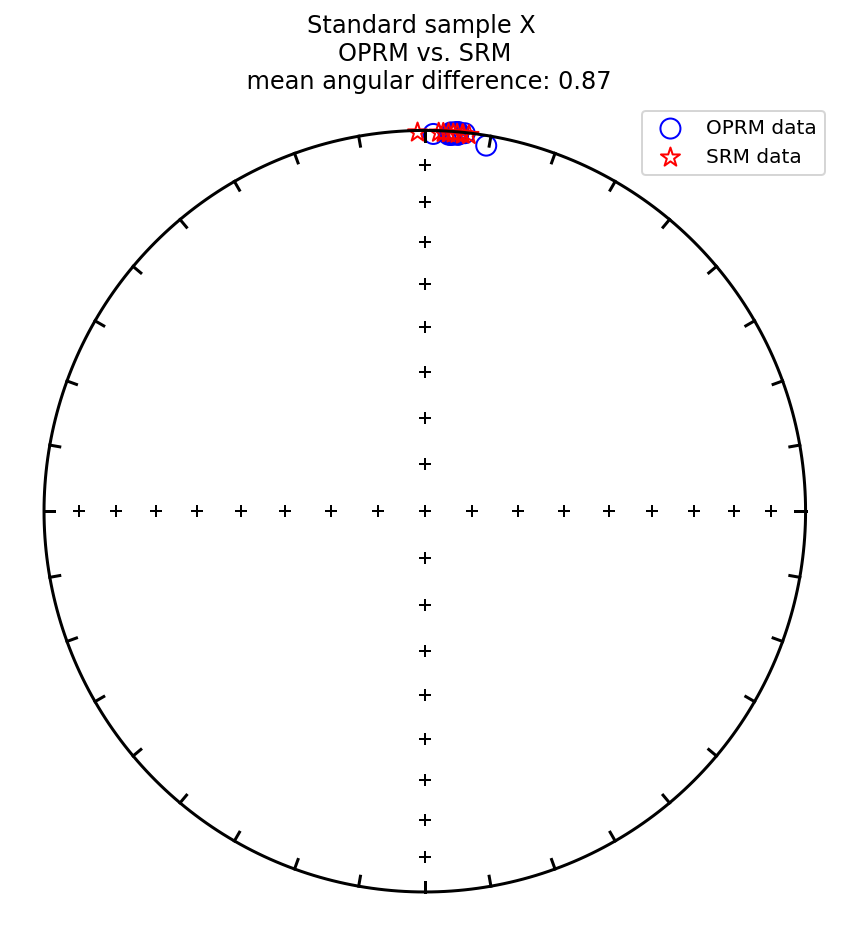

In [21]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-X_OPRM['dec'], -X_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(X_SRM_DF['dec'].tolist(), X_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 100, label = 'SRM data')
plt.legend()
plt.title('Standard sample X \nOPRM vs. SRM\n mean angular difference: ' +str(round(angle_X[0], 2)))
# plt.savefig('Figures/X_equall_area.pdf', bbox_inches='tight')
plt.show()

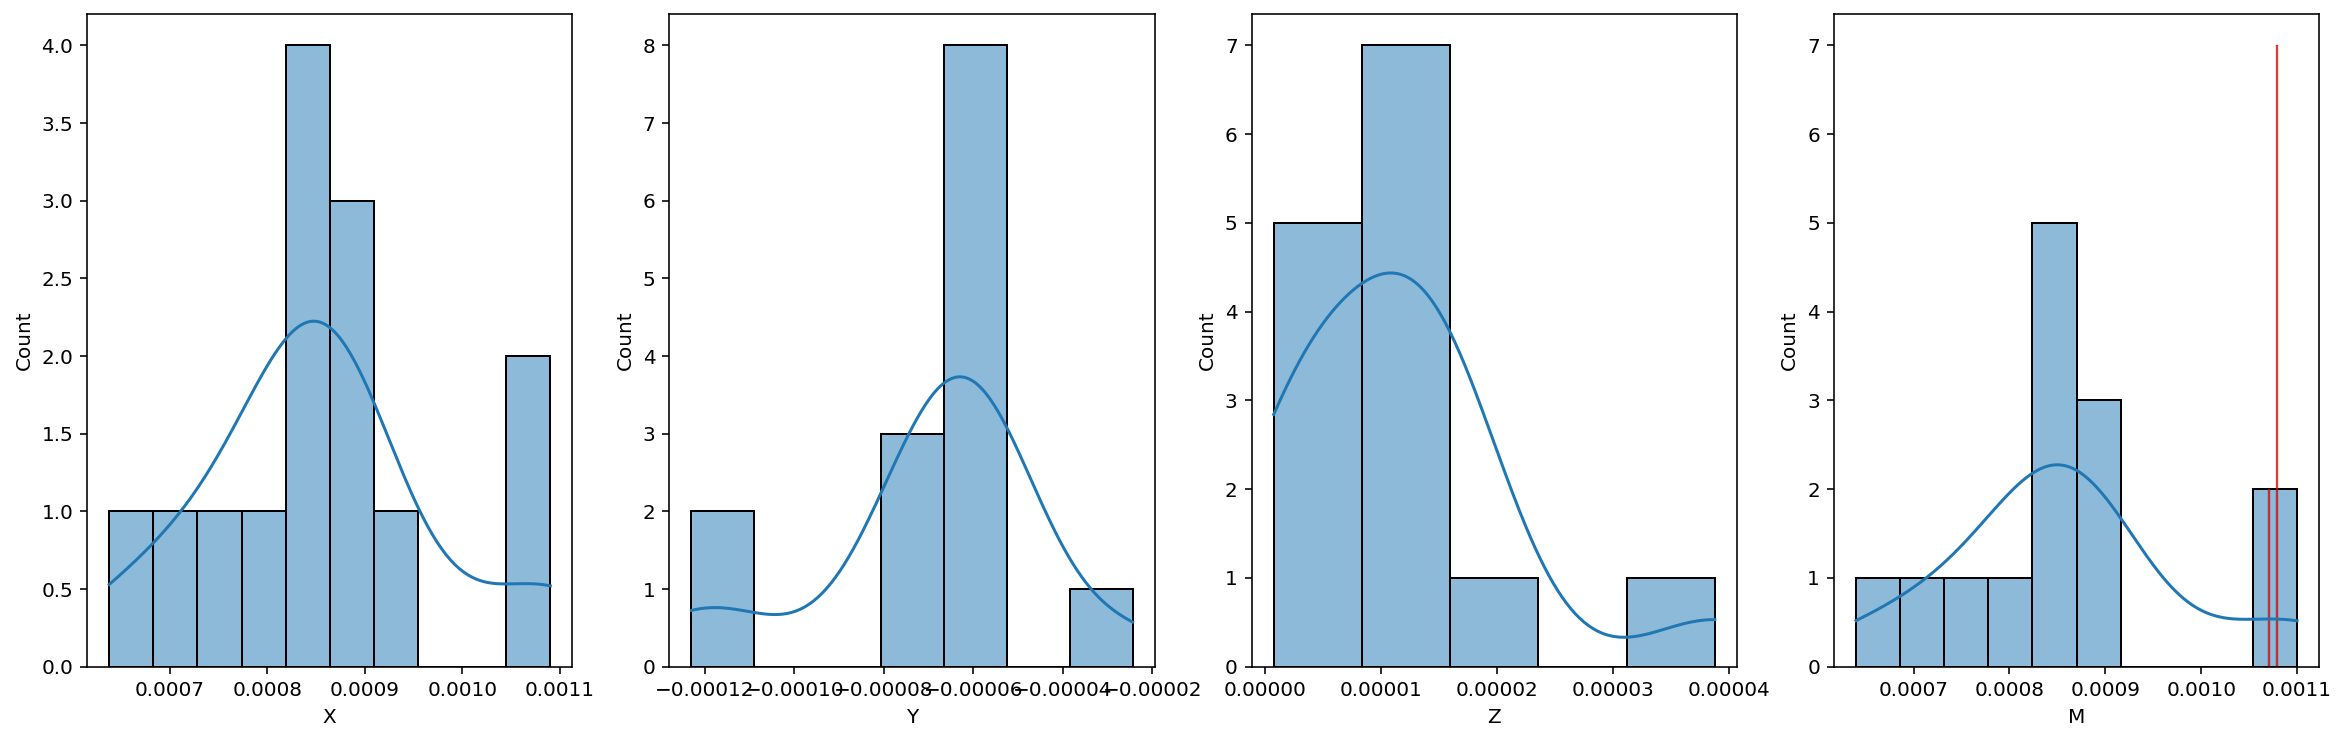

In [22]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=X_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=X_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=X_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=X_OPRM, x="M", kde=True, ax=ax[3])
sns.histplot(data=X_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## Z standard sample

### OPRM Z


In [23]:
Z_OPRM = read_OPRM_file('OPRM_data/Z.csv')
Z_OPRM = Z_OPRM[Z_OPRM['Orientation'] == 'T_4MR_T+Z-Z']
Z_OPRM = Z_OPRM.reset_index()
Z_OPRM = Z_OPRM.drop([2,4])
Z_OPRM = Z_OPRM.reset_index()
Z_OPRM

level_0  index DEMAG       CD       CI        M         X         Y  \
0        0      3   NRM 2.59E+02 8.64E+01 5.74E-04 -6.67E-06 -3.55E-05   
1        1      9   NRM 2.06E+02 8.85E+01 1.04E-03 -2.48E-05 -1.19E-05   
2        3     14   NRM 1.44E+02 8.71E+01 7.68E-04 -3.14E-05  2.27E-05   
3        5     16   NRM 2.09E+02 8.76E+01 7.61E-04 -2.80E-05 -1.53E-05   
4        6     17   NRM 2.14E+02 8.68E+01 1.16E-03 -5.30E-05 -3.61E-05   
5        7     18   NRM 2.09E+02 8.69E+01 1.12E-03 -5.35E-05 -2.97E-05   
6        8     20   NRM 2.25E+02 8.80E+01 1.06E-03 -2.62E-05 -2.64E-05   

         Z      S/D  S/H  Orientation Date&Time  Unnamed: 11 step      dec  \
0 5.73E-04 3.93E+01    0  T_4MR_T+Z-Z    19-Apr   2021 16:21  NRM 2.59E+02   
1 1.04E-03 1.74E+02    0  T_4MR_T+Z-Z    20-Apr   2021 12:34  NRM 2.06E+02   
2 7.67E-04 7.65E+02    0  T_4MR_T+Z-Z     1-Jun   2021 13:08  NRM 1.44E+02   
3 7.60E-04 3.58E+01    0  T_4MR_T+Z-Z     1-Jun   2021 13:51  NRM 2.09E+02   
4 1.16E-03 3.97E+02    0  T_4MR_T+Z-Z     1-Jun   2021 14:19  NRM 2.14E+02   
5 1.12E-03 9.64E+01    0  T_4MR_T+Z-Z     2-Jun   2021 11:52  NRM 2.09E+02   
6 1.06E-03 1.18E+03    0  T_4MR_T+Z-Z     2-Jun   2021 12:09  NRM 2.25E+02   

       inc       Ms blank quality  
0 8.64E+01 5.74E-04             g  
1 8.85E+01 1.04E-03             g  
2 8.71E+01 7.68E-04             g  
3 8.76E+01 7.61E-04             g  
4 8.68E+01 1.16E-03             g  
5 8.69E+01 1.12E-03             g  
6 8.80E+01 1.06E-03             g

### SRM Z

In [24]:
Z_SRM_DF = read_SRM_file('SRM_data/Z')
# Z_SRM_DF = Z_SRM_DF.drop(3)
Z_SRM_DF = Z_SRM_DF.reset_index()
Z_SRM_DF

index step      dec       inc       Ms blank quality
0      0  NRM 1.34E+02 -8.72E+01 1.02E-03             g

In [25]:
Z_OPRM_mean = ipmag.fisher_mean(0-Z_OPRM['dec'], -Z_OPRM['inc'])

In [26]:
ipmag.print_direction_mean(Z_OPRM_mean)


Dec: 147.7  Inc: -87.8
Number of directions in mean (n): 7
Angular radius of 95% confidence (a_95): 1.3
Precision parameter (k) estimate: 2171.1


In [27]:
angle_Z = pmag.angle([Z_OPRM_mean['dec'], Z_OPRM_mean['inc']], [Z_SRM_DF['dec'][0], Z_SRM_DF['inc'][0]])

### equal area plot for the directions

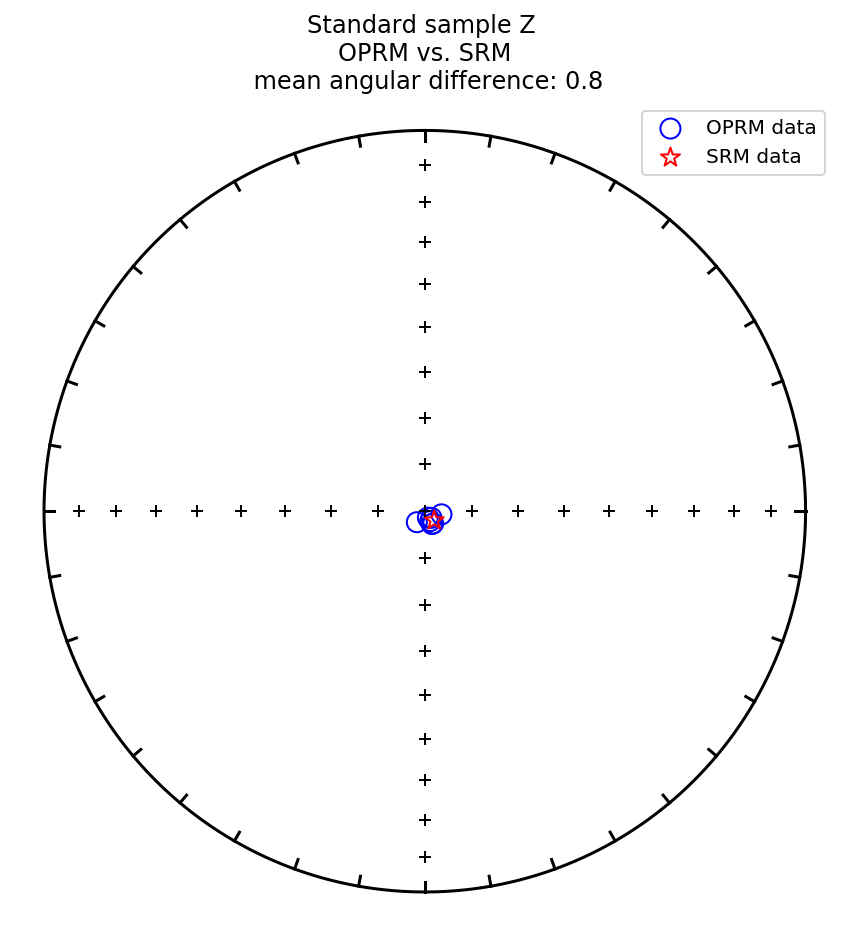

In [28]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-Z_OPRM['dec'], -Z_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(Z_SRM_DF['dec'].tolist(), Z_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 100, label = 'SRM data')
plt.legend()
plt.title('Standard sample Z \nOPRM vs. SRM\n mean angular difference: ' +str(round(angle_Z[0], 2)))
# plt.savefig('Figures/Z_equall_area.pdf', bbox_inches='tight')
plt.show()

## GB1-2b

### OPRM GB1-2b

I did 1 measurement1 of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 4.53 E-3 but OPRM gives consistently 4E-3 (emu).

In [29]:
GB1_2b_OPRM = read_OPRM_file('OPRM_data/GB1-2b.csv')
GB1_2b_OPRM = GB1_2b_OPRM.drop(1)
GB1_2b_OPRM = GB1_2b_OPRM.drop(9)
GB1_2b_OPRM = GB1_2b_OPRM.reset_index()
GB1_2b_OPRM

index DEMAG       CD        CI        M        X         Y         Z  \
0       0   NRM 3.57E+02 -7.06E+01 8.35E-03 2.78E-03 -1.44E-04 -7.88E-03   
1       2   NRM 3.30E+00 -7.04E+01 7.61E-03 2.54E-03  1.48E-04 -7.17E-03   
2       3   NRM 3.50E+00 -7.24E+01 6.22E-03 1.87E-03  1.15E-04 -5.93E-03   
3       4   NRM 2.30E+00 -7.14E+01 6.26E-03 2.00E-03  8.00E-05 -5.93E-03   
4       5   NRM 6.00E+00 -7.14E+01 6.12E-03 1.94E-03  2.05E-04 -5.81E-03   
5       6   NRM 4.10E+00 -7.25E+01 6.27E-03 1.88E-03  1.35E-04 -5.98E-03   
6       7   NRM 1.90E+00 -7.26E+01 6.25E-03 1.86E-03  6.05E-05 -5.97E-03   
7       8   NRM 3.10E+00 -7.21E+01 6.23E-03 1.91E-03  1.04E-04 -5.93E-03   
8      10   NRM 2.60E+00 -7.16E+01 6.09E-03 1.92E-03  8.76E-05 -5.78E-03   
9      11   NRM 1.30E+00 -7.17E+01 6.21E-03 1.95E-03  4.42E-05 -5.89E-03   
10     12   NRM 2.10E+00 -7.14E+01 6.34E-03 2.03E-03  7.33E-05 -6.01E-03   
11     13   NRM 1.00E+00 -7.17E+01 6.08E-03 1.91E-03  3.38E-05 -5.77E-03   

        S/D  S/H  Orientation Date&Time  Unnamed: 11 step      dec       inc  \
0  2.11E+02    0  T_4MR_T+Z-Z     1-Jun   2021 14:35  NRM 3.57E+02 -7.05E+01   
1  2.47E+02    0  T_4MR_T+Z-Z     2-Jun   2021 12:20  NRM 3.33E+00 -7.05E+01   
2  3.56E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:10  NRM 3.52E+00 -7.25E+01   
3  4.96E+03    0  T_4MR_T+Z-Z     2-Jun   2021 16:15  NRM 2.29E+00 -7.13E+01   
4  9.92E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:18  NRM 6.03E+00 -7.14E+01   
5  1.14E+03    0  T_4MR_T+Z-Z     2-Jun   2021 16:20  NRM 4.11E+00 -7.25E+01   
6  3.69E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:21  NRM 1.86E+00 -7.27E+01   
7  3.68E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:23  NRM 3.12E+00 -7.21E+01   
8  8.66E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:30  NRM 2.61E+00 -7.16E+01   
9  6.66E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:32  NRM 1.30E+00 -7.17E+01   
10 1.87E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:34  NRM 2.07E+00 -7.13E+01   
11 2.97E+02    0  T_4MR_T+Z-Z     2-Jun   2021 16:36  NRM 1.01E+00 -7.17E+01   

         Ms blank quality  
0  8.35E-03             g  
1  7.61E-03             g  
2  6.22E-03             g  
3  6.26E-03             g  
4  6.12E-03             g  
5  6.27E-03             g  
6  6.25E-03             g  
7  6.23E-03             g  
8  6.09E-03             g  
9  6.21E-03             g  
10 6.34E-03             g  
11 6.08E-03             g

### SRM GB1-2b

In [30]:
GB1_2b_SRM_DF = read_SRM_file('SRM_data/GB1-2b')
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.drop(3)
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.reset_index()
GB1_2b_SRM_DF

step      dec      inc       Ms blank quality
0  NRM 3.30E+00 7.07E+01 4.53E-03             g
1  NRM 2.70E+00 7.07E+01 4.53E-03             g
2  NRM 5.50E+00 7.07E+01 4.53E-03             g
3  NRM 4.20E+00 7.08E+01 4.53E-03             g
4  NRM 4.70E+00 7.07E+01 4.53E-03             g

In [31]:
GB1_2b_OPRM_mean = ipmag.fisher_mean(0-GB1_2b_OPRM['dec'], -GB1_2b_OPRM['inc'])
GB1_2b_SRM_mean = ipmag.fisher_mean(GB1_2b_SRM_DF['dec'].tolist(), GB1_2b_SRM_DF['inc'].tolist())

In [32]:
ipmag.print_direction_mean(GB1_2b_OPRM_mean)


Dec: 357.7  Inc: 71.7
Number of directions in mean (n): 12
Angular radius of 95% confidence (a_95): 0.5
Precision parameter (k) estimate: 6691.3


In [33]:
ipmag.print_direction_mean(GB1_2b_SRM_mean)

Dec: 4.1  Inc: 70.7
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 0.3
Precision parameter (k) estimate: 48123.5


In [34]:
GB1_2b_angle = pmag.angle([GB1_2b_OPRM_mean['dec'], GB1_2b_OPRM_mean['inc']], [GB1_2b_SRM_mean['dec'], GB1_2b_SRM_mean['inc']])

### equal area plot for the directions

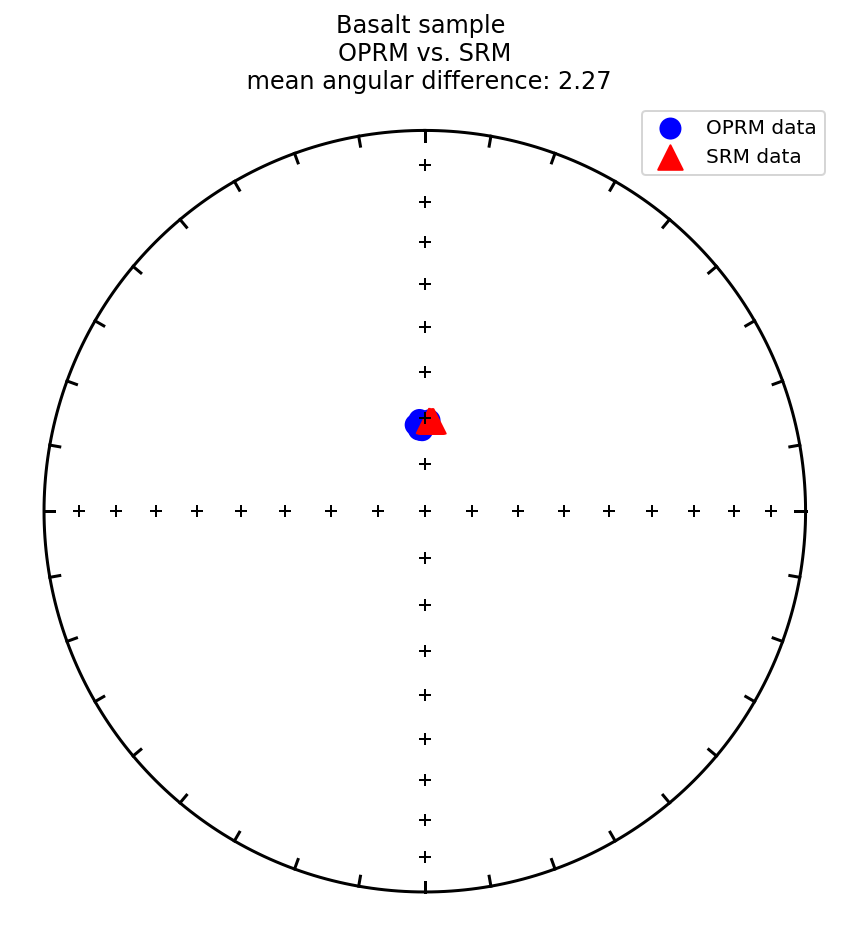

In [35]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-GB1_2b_OPRM['dec'], -GB1_2b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(GB1_2b_SRM_DF['dec'].tolist(), GB1_2b_SRM_DF['inc'].tolist(), color = 'red', marker = '^', markersize = 150, label = 'SRM data')
plt.legend()
plt.title('Basalt sample \nOPRM vs. SRM\n mean angular difference: ' +str(round(GB1_2b_angle[0], 2)))
# plt.savefig('Figures/GB1_2b_equall_area.pdf', bbox_inches='tight')
plt.show()

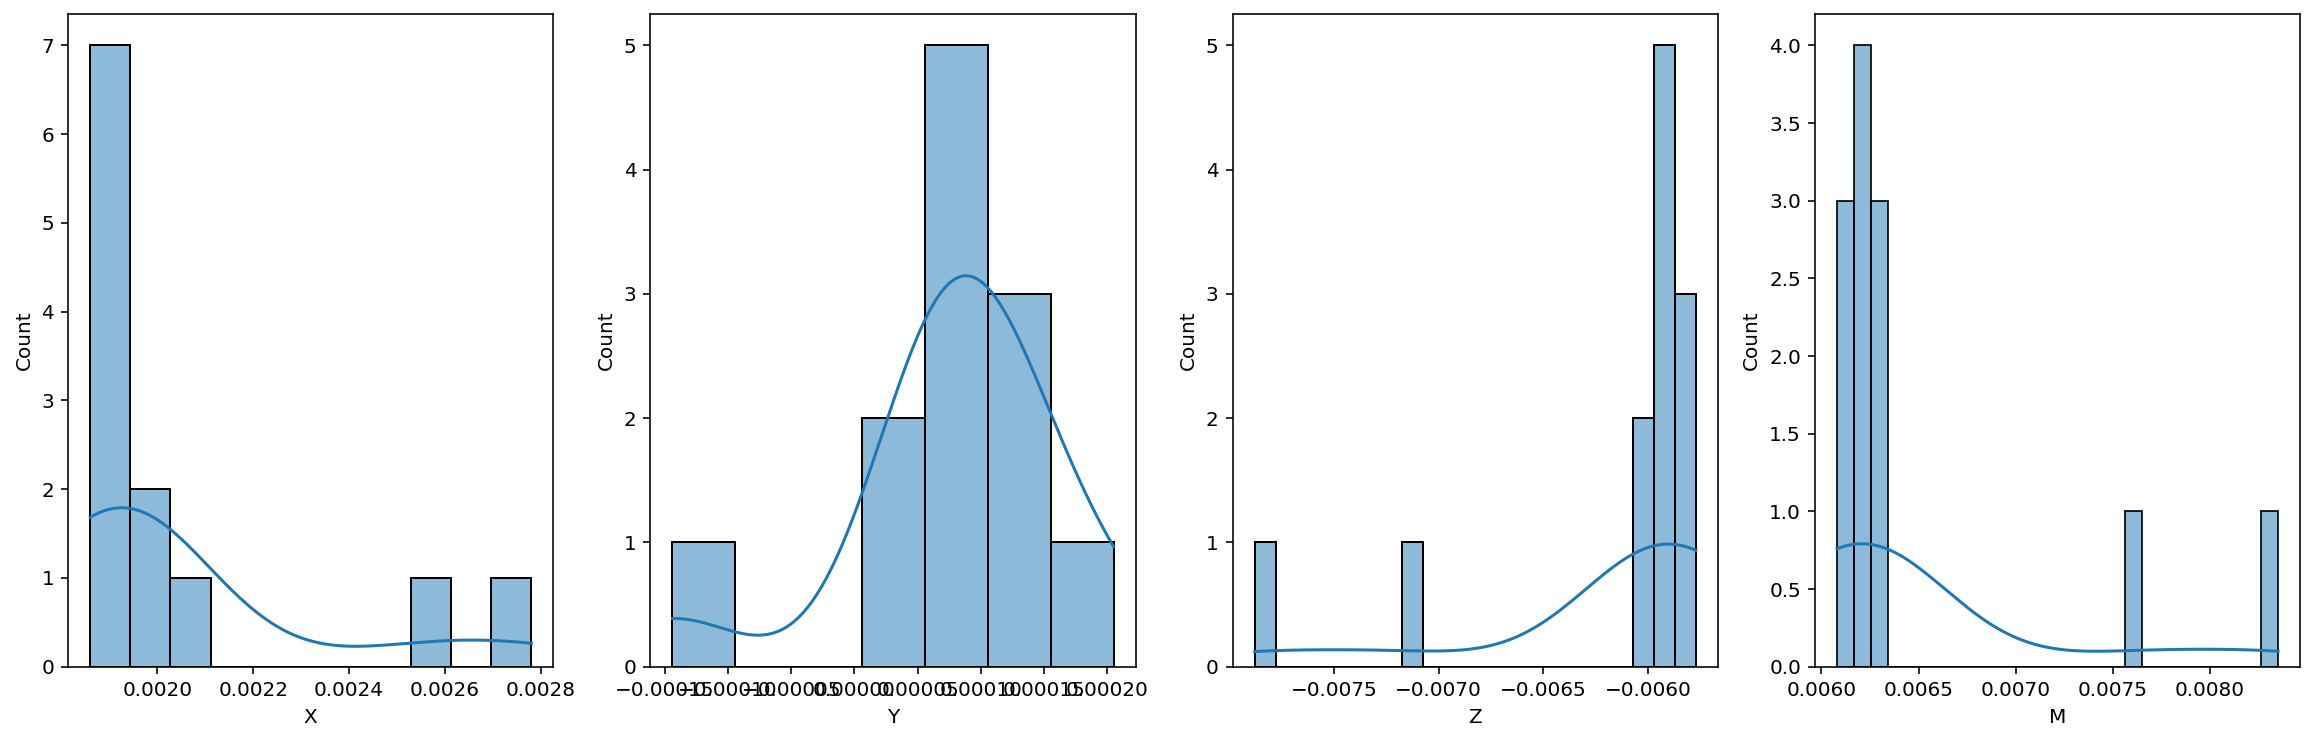

In [36]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=GB1_2b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=GB1_2b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=GB1_2b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=GB1_2b_OPRM, x="M", kde=True, ax=ax[3])
# sns.histplot(data=GB1_2b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## WP-3b

### OPRM WP-3b


In [37]:
WP_3b_OPRM = read_OPRM_file('OPRM_data/WP-3b.csv')

WP_3b_OPRM = WP_3b_OPRM.reset_index()
WP_3b_OPRM

index DEMAG       CD       CI        M        X        Y        Z      S/D  \
0      0   NRM 1.61E+01 6.48E+01 1.00E-03 4.10E-04 1.18E-04 9.08E-04 9.99E+03   
1      1   NRM 1.84E+01 6.67E+01 8.03E-04 3.01E-04 1.00E-04 7.38E-04 7.92E+02   
2      2   NRM 1.49E+01 6.49E+01 9.95E-04 4.08E-04 1.09E-04 9.01E-04 9.71E+02   
3      3   NRM 1.71E+01 6.48E+01 9.71E-04 3.95E-04 1.21E-04 8.79E-04 7.12E+03   
4      4   NRM 1.70E+01 6.46E+01 1.01E-03 4.12E-04 1.26E-04 9.09E-04 6.05E+03   
5      5   NRM 1.61E+01 6.48E+01 9.81E-04 4.01E-04 1.16E-04 8.88E-04 1.76E+03   
6      6   NRM 1.58E+01 6.52E+01 9.69E-04 3.92E-04 1.11E-04 8.80E-04 7.55E+02   
7      7   NRM 1.66E+01 6.49E+01 9.76E-04 3.96E-04 1.18E-04 8.84E-04 1.20E+04   
8      8   NRM 1.54E+01 6.53E+01 9.84E-04 3.97E-04 1.09E-04 8.93E-04 1.22E+03   
9      9   NRM 1.71E+01 6.51E+01 9.93E-04 4.00E-04 1.23E-04 9.00E-04 5.48E+03   

   S/H  Orientation Date&Time  Unnamed: 11 step      dec      inc       Ms  \
0    0  T_4MR_T+Z-Z     2-Jun   2021 16:39  NRM 1.61E+01 6.48E+01 1.00E-03   
1    0  T_4MR_T+Z-Z     2-Jun   2021 16:42  NRM 1.84E+01 6.67E+01 8.03E-04   
2    0  T_4MR_T+Z-Z     2-Jun   2021 16:45  NRM 1.50E+01 6.49E+01 9.95E-04   
3    0  T_4MR_T+Z-Z     2-Jun   2021 16:46  NRM 1.70E+01 6.48E+01 9.71E-04   
4    0  T_4MR_T+Z-Z     2-Jun   2021 16:48  NRM 1.70E+01 6.46E+01 1.01E-03   
5    0  T_4MR_T+Z-Z     2-Jun   2021 16:50  NRM 1.61E+01 6.48E+01 9.81E-04   
6    0  T_4MR_T+Z-Z     2-Jun   2021 16:51  NRM 1.58E+01 6.52E+01 9.69E-04   
7    0  T_4MR_T+Z-Z     2-Jun   2021 16:54  NRM 1.66E+01 6.49E+01 9.76E-04   
8    0  T_4MR_T+Z-Z     2-Jun   2021 16:57  NRM 1.54E+01 6.52E+01 9.84E-04   
9    0  T_4MR_T+Z-Z     2-Jun   2021 16:58  NRM 1.71E+01 6.51E+01 9.93E-04   

  blank quality  
0             g  
1             g  
2             g  
3             g  
4             g  
5             g  
6             g  
7             g  
8             g  
9             g

### SRM WP-3b

In [38]:
WP_3b_SRM_DF = read_SRM_file('SRM_data/WP-3b')
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.drop(3)
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.reset_index()
WP_3b_SRM_DF

step      dec      inc       Ms blank quality
0  NRM 1.91E+01 6.13E+01 7.11E-04             g
1  NRM 1.46E+01 6.14E+01 7.11E-04             g
2  NRM 1.85E+01 6.14E+01 7.11E-04             g
3  NRM 1.47E+01 6.14E+01 7.11E-04             g
4  NRM 1.87E+01 6.14E+01 7.11E-04             g

In [39]:
WP_3b_OPRM_mean = ipmag.fisher_mean(WP_3b_OPRM['dec'], WP_3b_OPRM['inc'])
WP_3b_SRM_mean = ipmag.fisher_mean(WP_3b_SRM_DF['dec'].tolist(), WP_3b_SRM_DF['inc'].tolist())

In [40]:
ipmag.print_direction_mean(WP_3b_OPRM_mean)

Dec: 16.4  Inc: 65.1
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 0.4
Precision parameter (k) estimate: 12404.4


In [41]:
ipmag.print_direction_mean(WP_3b_SRM_mean)

Dec: 17.1  Inc: 61.4
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 1.0
Precision parameter (k) estimate: 5568.7


In [42]:
WP_3b_angle = pmag.angle([WP_3b_OPRM_mean['dec'], WP_3b_OPRM_mean['inc']], [WP_3b_SRM_mean['dec'], WP_3b_SRM_mean['inc']])

In [43]:
WP_3b_angle

array([3.737609874603049])

### equal area plot for the directions

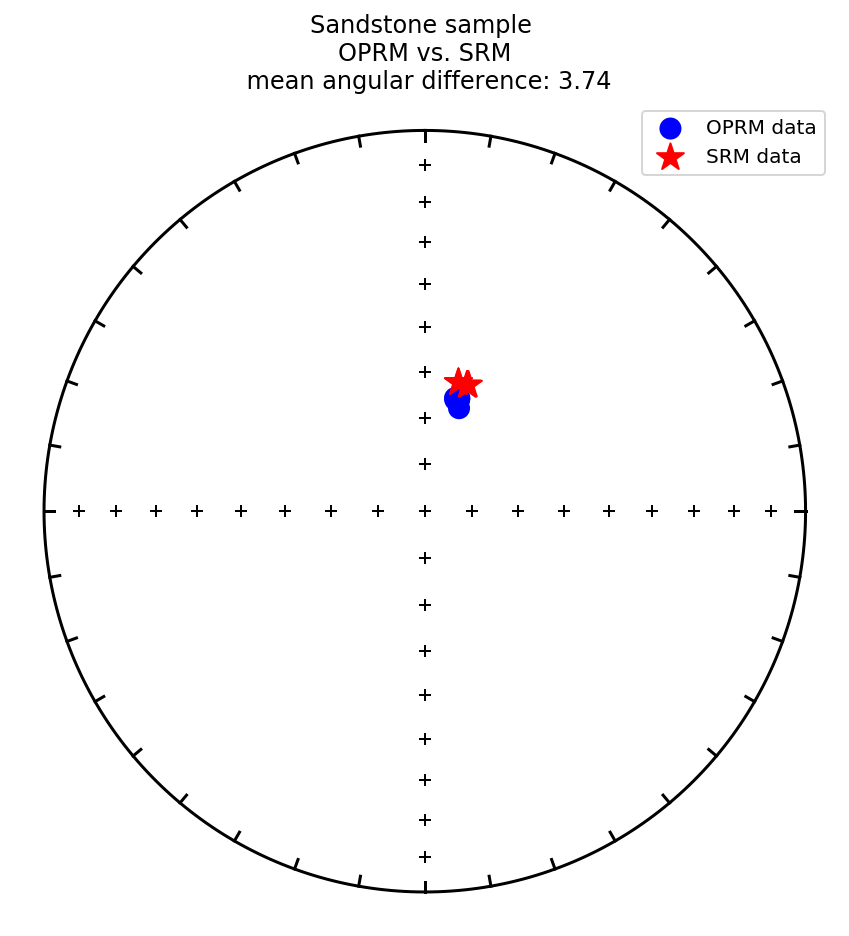

In [44]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(WP_3b_OPRM['dec'], WP_3b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(WP_3b_SRM_DF['dec'].tolist(), WP_3b_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 200, label = 'SRM data')
plt.legend()
plt.title('Sandstone sample \nOPRM vs. SRM\n mean angular difference: ' +str(round(WP_3b_angle[0], 2)))
# plt.savefig('Figures/WP_3b_equall_area.pdf', bbox_inches='tight')
plt.show()

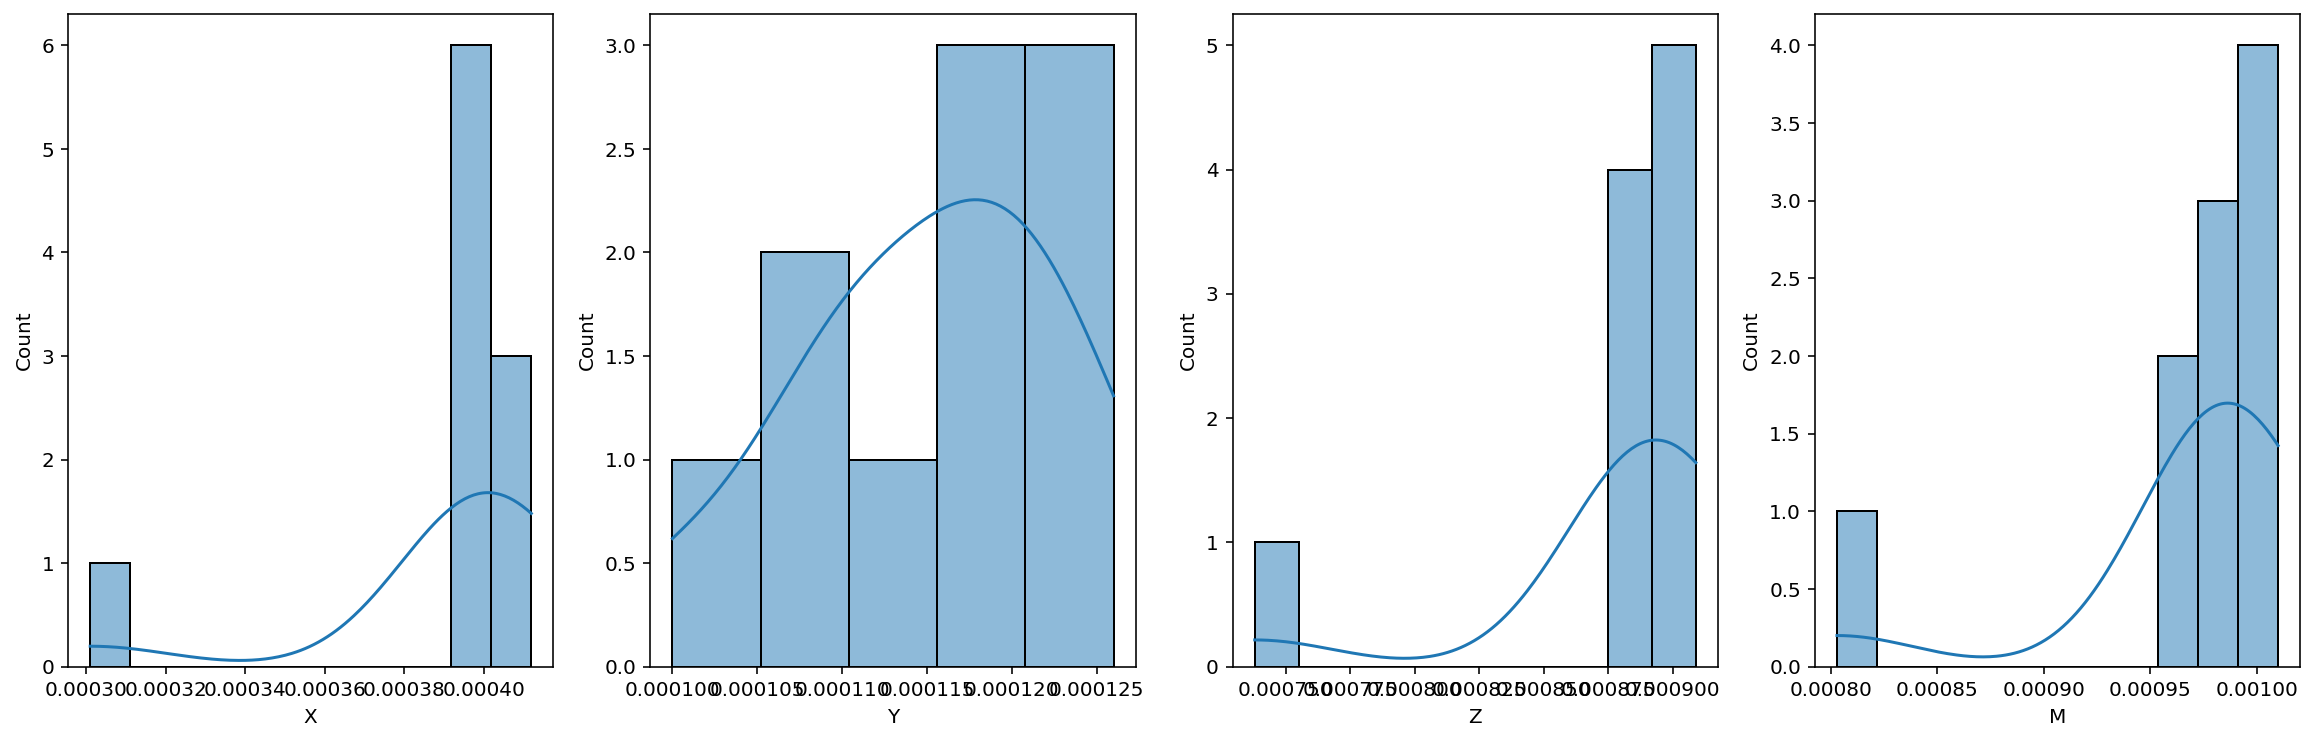

In [45]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=WP_3b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=WP_3b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=WP_3b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=WP_3b_OPRM, x="M", kde=True, ax=ax[3])
# sns.histplot(data=WP_3b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## T1-84b

### OPRM T1-84b

I did 1 measurement of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 7.1 E-4 but OPRM gives consistently 9 E-4 to 1E-3(emu).

In [46]:
T1_84b_OPRM = read_OPRM_file('OPRM_data/T1-84b.csv')
# T1_84b_OPRM = T1_84b_OPRM.drop(0)
# T1_84b_OPRM = T1_84b_OPRM.reset_index()
T1_84b_OPRM

DEMAG       CD        CI        M         X         Y         Z      S/D  \
0   NRM 2.32E+02 -4.79E+01 6.53E-06 -2.72E-06 -3.43E-06 -4.85E-06 2.78E+02   
1   NRM 2.32E+02 -4.78E+01 6.45E-06 -2.68E-06 -3.40E-06 -4.77E-06 3.33E+01   
2   NRM 2.27E+02 -4.71E+01 6.51E-06 -3.04E-06 -3.22E-06 -4.77E-06 3.67E+01   
3   NRM 2.33E+02 -4.84E+01 6.43E-06 -2.55E-06 -3.42E-06 -4.81E-06 1.54E+01   
4   NRM 2.32E+02 -4.77E+01 6.50E-06 -2.72E-06 -3.42E-06 -4.81E-06 1.80E+01   
5   NRM 2.32E+02 -4.78E+01 6.94E-06 -2.86E-06 -3.69E-06 -5.14E-06 9.06E+01   
6   NRM 2.31E+02 -4.67E+01 6.76E-06 -2.92E-06 -3.60E-06 -4.92E-06 8.05E+01   
7   NRM 2.31E+02 -4.73E+01 7.07E-06 -3.01E-06 -3.73E-06 -5.19E-06 9.91E+01   
8   NRM 2.32E+02 -4.75E+01 6.90E-06 -2.86E-06 -3.68E-06 -5.09E-06 1.40E+02   
9   NRM 2.32E+02 -4.67E+01 6.63E-06 -2.83E-06 -3.56E-06 -4.83E-06 1.96E+02   

   S/H  Orientation Date&Time  Unnamed: 11 step      dec       inc       Ms  \
0    0  T_4MR_T+Z-Z     2-Jun   2021 17:00  NRM 2.32E+02 -4.79E+01 6.53E-06   
1    0  T_4MR_T+Z-Z     2-Jun   2021 17:04  NRM 2.32E+02 -4.78E+01 6.45E-06   
2    0  T_4MR_T+Z-Z     2-Jun   2021 17:05  NRM 2.27E+02 -4.71E+01 6.51E-06   
3    0  T_4MR_T+Z-Z     2-Jun   2021 17:07  NRM 2.33E+02 -4.84E+01 6.43E-06   
4    0  T_4MR_T+Z-Z     2-Jun   2021 17:08  NRM 2.32E+02 -4.77E+01 6.50E-06   
5    0  T_4MR_T+Z-Z     2-Jun   2021 17:10  NRM 2.32E+02 -4.78E+01 6.94E-06   
6    0  T_4MR_T+Z-Z     2-Jun   2021 17:12  NRM 2.31E+02 -4.67E+01 6.76E-06   
7    0  T_4MR_T+Z-Z     2-Jun   2021 17:14  NRM 2.31E+02 -4.73E+01 7.07E-06   
8    0  T_4MR_T+Z-Z     2-Jun   2021 17:15  NRM 2.32E+02 -4.75E+01 6.90E-06   
9    0  T_4MR_T+Z-Z     2-Jun   2021 17:17  NRM 2.32E+02 -4.67E+01 6.63E-06   

  blank quality  
0             g  
1             g  
2             g  
3             g  
4             g  
5             g  
6             g  
7             g  
8             g  
9             g

### SRM T1-84b

In [47]:
T1_84b_SRM_DF = read_SRM_file('SRM_data/T1-84b')
T1_84b_SRM_DF

step      dec       inc       Ms blank quality
0  NRM 2.29E+02 -4.59E+01 4.67E-06             g
1  NRM 2.32E+02 -4.58E+01 4.67E-06             g
2  NRM 2.33E+02 -4.59E+01 4.69E-06             g
3  NRM 2.30E+02 -4.58E+01 4.67E-06             g
4  NRM 2.30E+02 -4.57E+01 4.67E-06             g

In [48]:
T1_84b_OPRM_mean = ipmag.fisher_mean(T1_84b_OPRM['dec'], T1_84b_OPRM['inc'])
T1_84b_SRM_mean = ipmag.fisher_mean(T1_84b_SRM_DF['dec'].tolist(), T1_84b_SRM_DF['inc'].tolist())

In [49]:
ipmag.print_direction_mean(T1_84b_OPRM_mean)


Dec: 231.3  Inc: -47.5
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 0.8
Precision parameter (k) estimate: 3850.8


In [50]:
ipmag.print_direction_mean(T1_84b_SRM_mean)

Dec: 230.7  Inc: -45.8
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 1.2
Precision parameter (k) estimate: 3983.1


In [51]:
T1_84b_angle = pmag.angle([T1_84b_OPRM_mean['dec'], T1_84b_OPRM_mean['inc']], [T1_84b_SRM_mean['dec'], T1_84b_SRM_mean['inc']])

### equal area plot for the directions

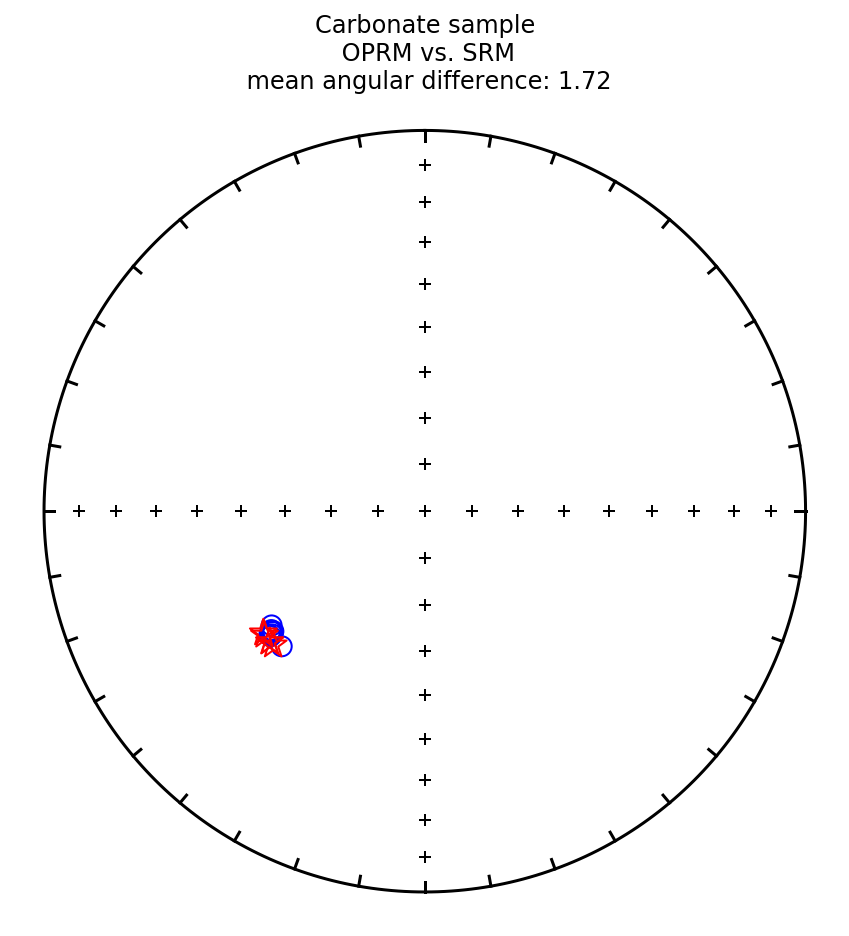

In [52]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(T1_84b_OPRM['dec'], T1_84b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(T1_84b_SRM_DF['dec'].tolist(), T1_84b_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 200, label = 'SRM data')
plt.title('Carbonate sample\n OPRM vs. SRM\n mean angular difference: ' +str(round(T1_84b_angle[0], 2)))
# plt.savefig('Figures/T1_84b_equall_area.pdf', bbox_inches='tight')
plt.show()

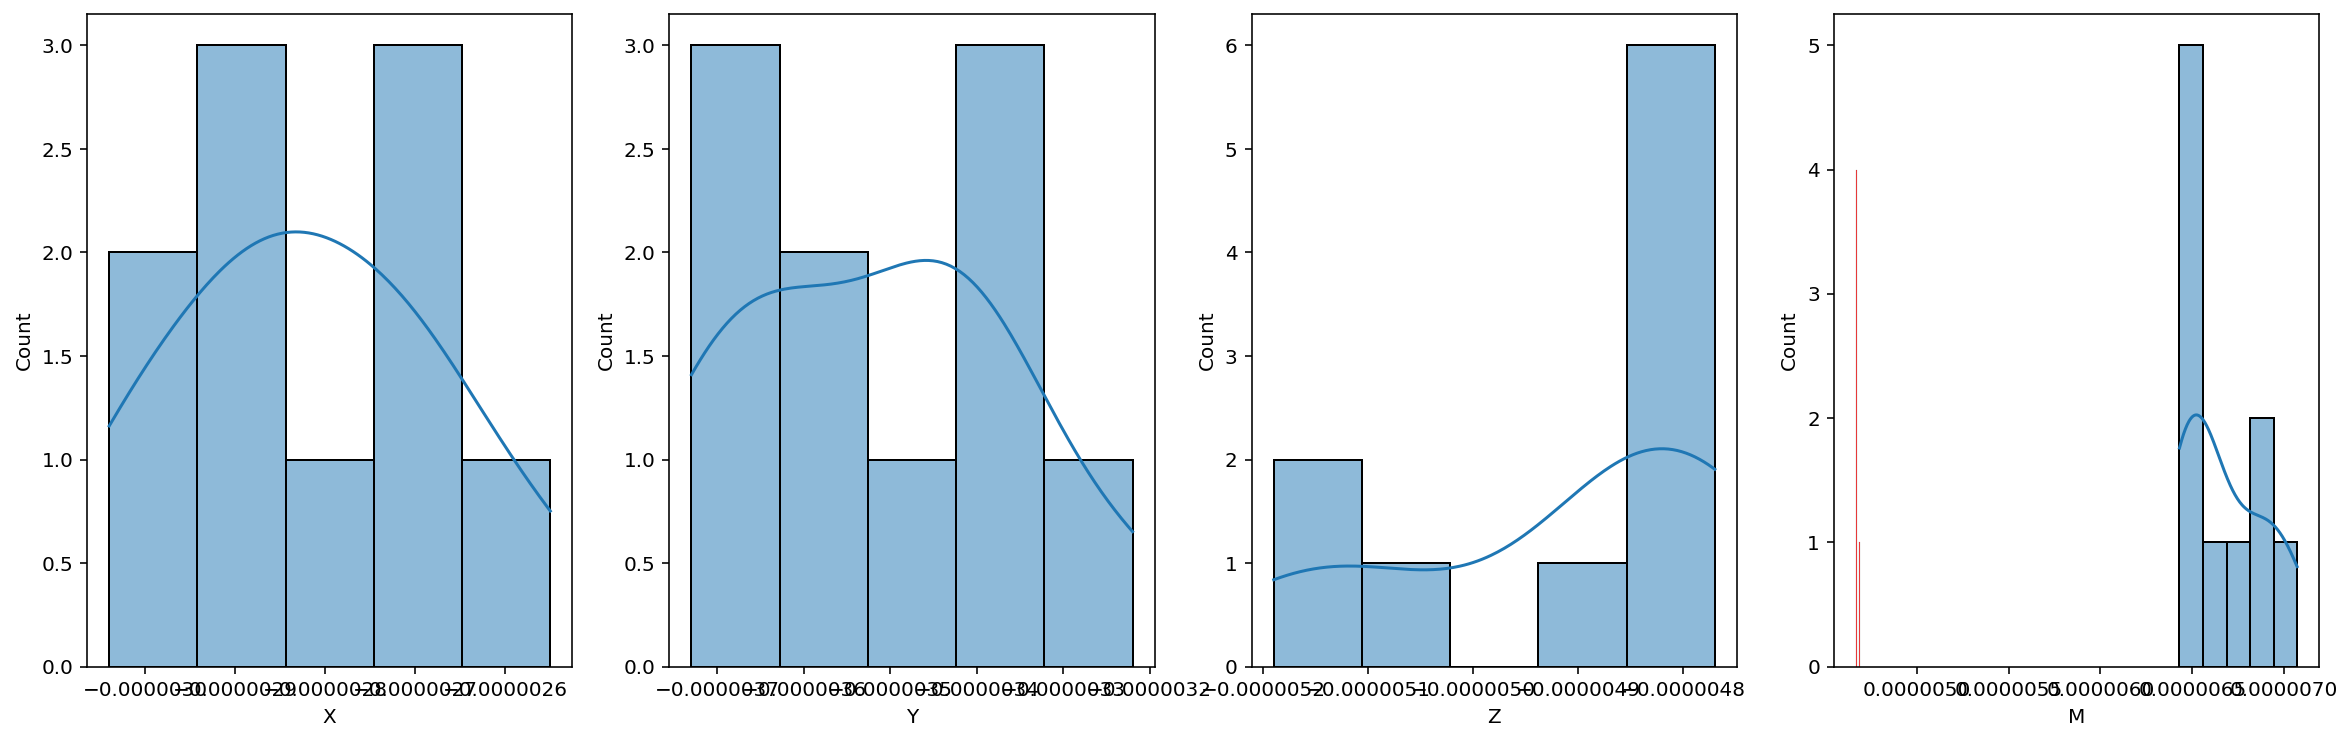

In [53]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=T1_84b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=T1_84b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=T1_84b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=T1_84b_OPRM, x="M", kde=True, ax=ax[3])
sns.histplot(data=T1_84b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## signal to drift ratio summary

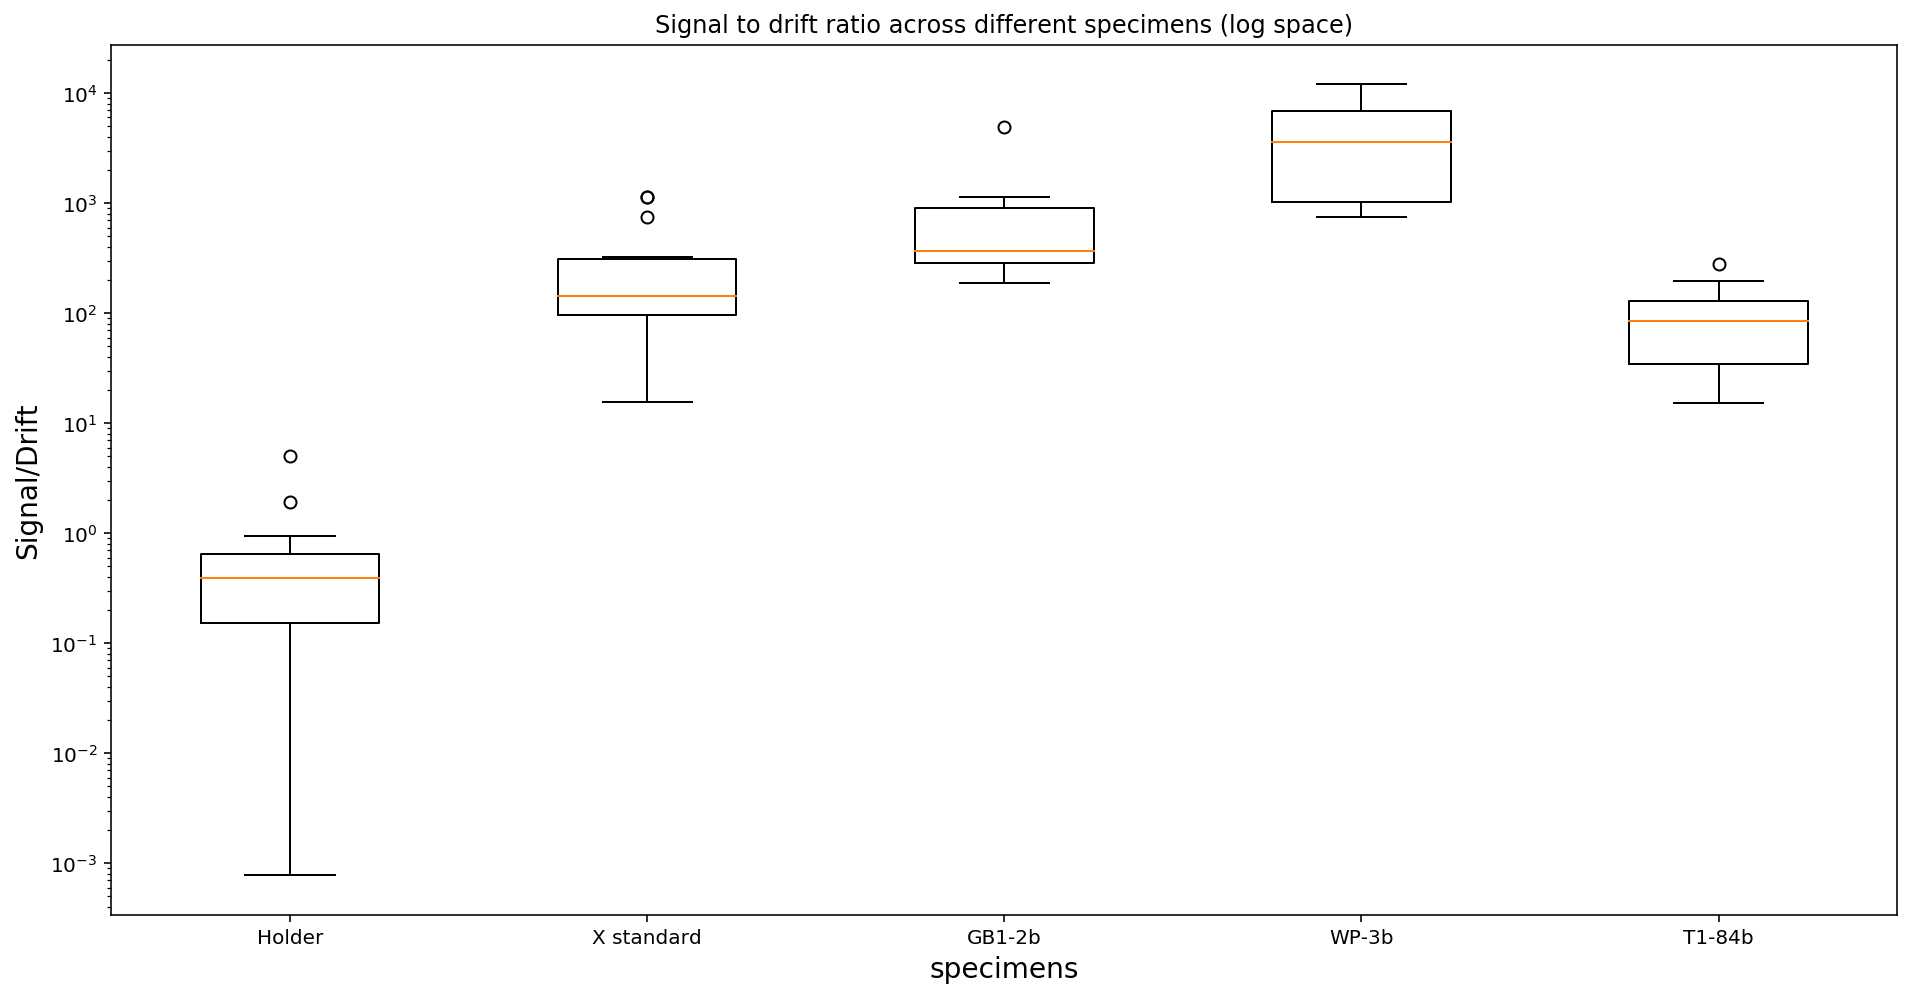

In [54]:
plt.figure(figsize=(16,8))
plt.boxplot([Holder_OPRM['S/D'], X_OPRM['S/D'], GB1_2b_OPRM['S/D'], WP_3b_OPRM['S/D'], T1_84b_OPRM['S/D']]);
plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Signal/Drift', fontdict={'fontsize':14})
plt.yscale('log')
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Signal to drift ratio across different specimens (log space)')
# plt.savefig('Figures/Signal_drift_ratio.pdf')
plt.show()

## moment summary

In [55]:
df_OPRM = pd.DataFrame([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']]).T
df_OPRM.columns = ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b']
# df_OPRM['hue'] = 'OPRM'
df_OPRM

Holder  X standard   GB1-2b    WP-3b   T1-84b
0  2.98E-05    7.43E-04 8.35E-03 1.00E-03 6.53E-06
1  3.63E-08    7.22E-04 7.61E-03 8.03E-04 6.45E-06
2  1.71E-07    1.10E-03 6.22E-03 9.95E-04 6.51E-06
3  1.74E-07    1.08E-03 6.26E-03 9.71E-04 6.43E-06
4  2.03E-07    8.41E-04 6.12E-03 1.01E-03 6.50E-06
5  1.30E-07    9.13E-04 6.27E-03 9.81E-04 6.94E-06
6  2.22E-07    8.67E-04 6.25E-03 9.69E-04 6.76E-06
7  1.89E-07    8.63E-04 6.23E-03 9.76E-04 7.07E-06
8  1.35E-07    6.40E-04 6.09E-03 9.84E-04 6.90E-06
9  1.47E-07    8.73E-04 6.21E-03 9.93E-04 6.63E-06
10 1.26E-07    8.71E-04 6.34E-03      NaN      NaN
11 1.33E-07    8.55E-04 6.08E-03      NaN      NaN
12      NaN    8.37E-04      NaN      NaN      NaN
13      NaN    8.08E-04      NaN      NaN      NaN

In [56]:
df_SRM = pd.DataFrame([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']]).T
df_SRM.columns = ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b']
# df_SRM['hue'] = 'SRM'
df_SRM

Holder  X standard   GB1-2b    WP-3b   T1-84b
0     NaN    1.08E-03 4.53E-03 7.11E-04 4.67E-06
1     NaN    1.08E-03 4.53E-03 7.11E-04 4.67E-06
2     NaN    1.08E-03 4.53E-03 7.11E-04 4.69E-06
3     NaN    1.08E-03 4.53E-03 7.11E-04 4.67E-06
4     NaN    1.07E-03 4.53E-03 7.11E-04 4.67E-06
5     NaN    1.08E-03      NaN      NaN      NaN
6     NaN    1.07E-03      NaN      NaN      NaN
7     NaN    1.08E-03      NaN      NaN      NaN
8     NaN    1.08E-03      NaN      NaN      NaN

In [57]:
all_df = pd.concat([df_OPRM,df_SRM], axis=1)
all_df

Holder  X standard   GB1-2b    WP-3b   T1-84b  Holder  X standard  \
0  2.98E-05    7.43E-04 8.35E-03 1.00E-03 6.53E-06     NaN    1.08E-03   
1  3.63E-08    7.22E-04 7.61E-03 8.03E-04 6.45E-06     NaN    1.08E-03   
2  1.71E-07    1.10E-03 6.22E-03 9.95E-04 6.51E-06     NaN    1.08E-03   
3  1.74E-07    1.08E-03 6.26E-03 9.71E-04 6.43E-06     NaN    1.08E-03   
4  2.03E-07    8.41E-04 6.12E-03 1.01E-03 6.50E-06     NaN    1.07E-03   
5  1.30E-07    9.13E-04 6.27E-03 9.81E-04 6.94E-06     NaN    1.08E-03   
6  2.22E-07    8.67E-04 6.25E-03 9.69E-04 6.76E-06     NaN    1.07E-03   
7  1.89E-07    8.63E-04 6.23E-03 9.76E-04 7.07E-06     NaN    1.08E-03   
8  1.35E-07    6.40E-04 6.09E-03 9.84E-04 6.90E-06     NaN    1.08E-03   
9  1.47E-07    8.73E-04 6.21E-03 9.93E-04 6.63E-06     NaN         NaN   
10 1.26E-07    8.71E-04 6.34E-03      NaN      NaN     NaN         NaN   
11 1.33E-07    8.55E-04 6.08E-03      NaN      NaN     NaN         NaN   
12      NaN    8.37E-04      NaN      NaN      NaN     NaN         NaN   
13      NaN    8.08E-04      NaN      NaN      NaN     NaN         NaN   

     GB1-2b    WP-3b   T1-84b  
0  4.53E-03 7.11E-04 4.67E-06  
1  4.53E-03 7.11E-04 4.67E-06  
2  4.53E-03 7.11E-04 4.69E-06  
3  4.53E-03 7.11E-04 4.67E-06  
4  4.53E-03 7.11E-04 4.67E-06  
5       NaN      NaN      NaN  
6       NaN      NaN      NaN  
7       NaN      NaN      NaN  
8       NaN      NaN      NaN  
9       NaN      NaN      NaN  
10      NaN      NaN      NaN  
11      NaN      NaN      NaN  
12      NaN      NaN      NaN  
13      NaN      NaN      NaN

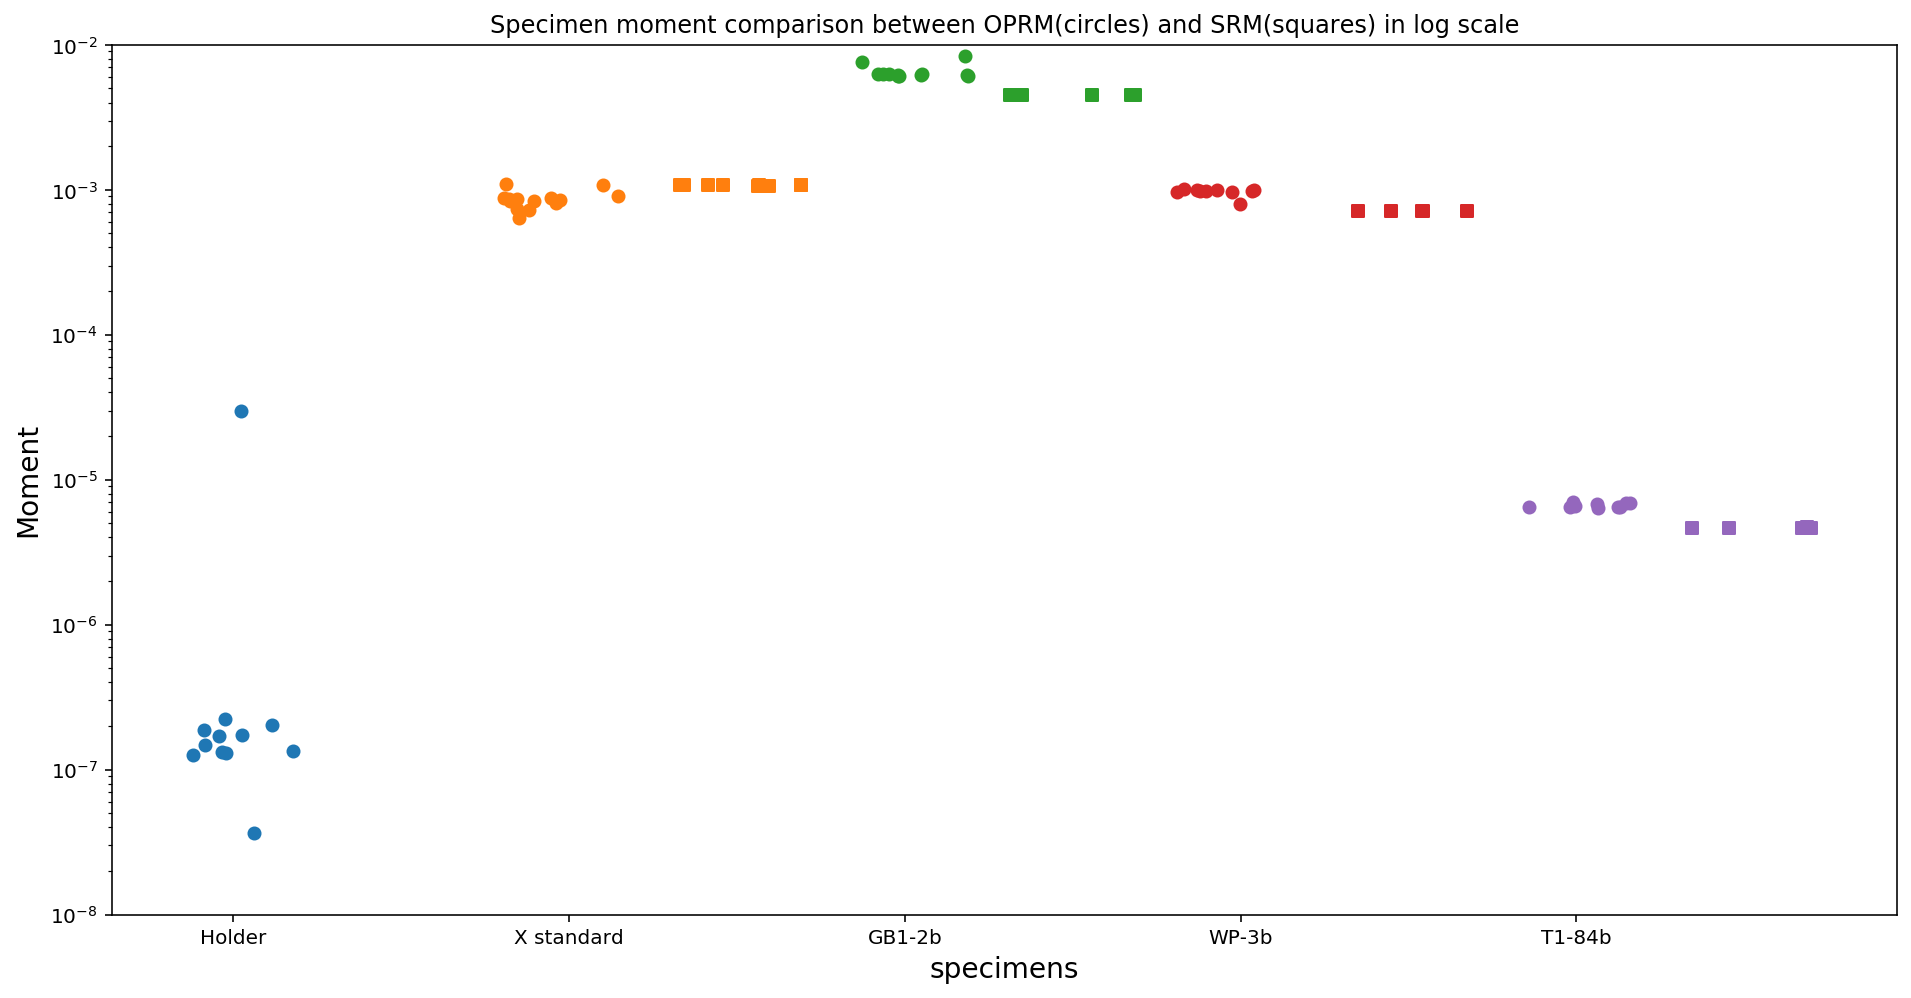

In [58]:

c1 = 'b'
c2 = 'r'
plt.figure(figsize=(16,8))
def stripplot(list_of_list, shift=0, random=False, marker='o', label=None):

    for i in range(len(list_of_list)):
        for j in list_of_list[i]:
            if random:
                plt.scatter(i+shift+np.random.uniform(-0.2,0.2), j, color = 'C'+str(i), marker = marker, label = label)
            else:
                plt.scatter(i+shift, j, color = 'C'+str(i), marker = marker, label = label)

                   
stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], random = True, label = 'OPRM measurements')  
stripplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], random = True, 
          shift = 0.5, marker = 's', label = 'SM measurements')
# sns.stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c1, color=c1),
#             capprops=dict(color=c1),
#             whiskerprops=dict(color=c1),
#             flierprops=dict(color=c1, markeredgecolor=c1),
#             medianprops=dict(color=c1),
#             )
# sns.stripplot(Holder_OPRM['M'])
# sns.stripplot(X_OPRM['M'])
# sns.stripplot(GB1_2b_OPRM['M'])
# sns.stripplot(WP_3b_OPRM['M'])
# sns.stripplot(T1_84b_OPRM['M'])
# plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c2, color=c2),
#             capprops=dict(color=c2),
#             whiskerprops=dict(color=c2),
#             flierprops=dict(color=c2, markeredgecolor=c2),
#             medianprops=dict(color=c2),
#             )

# plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
plt.yscale('log')
plt.ylim(1e-8, 1e-2)
plt.xticks([0,1,2,3,4], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])

plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Specimen moment comparison between OPRM(circles) and SRM(squares) in log scale')
# plt.legend()
# plt.savefig('Figures/Moment_comparison_log.pdf')
plt.show()

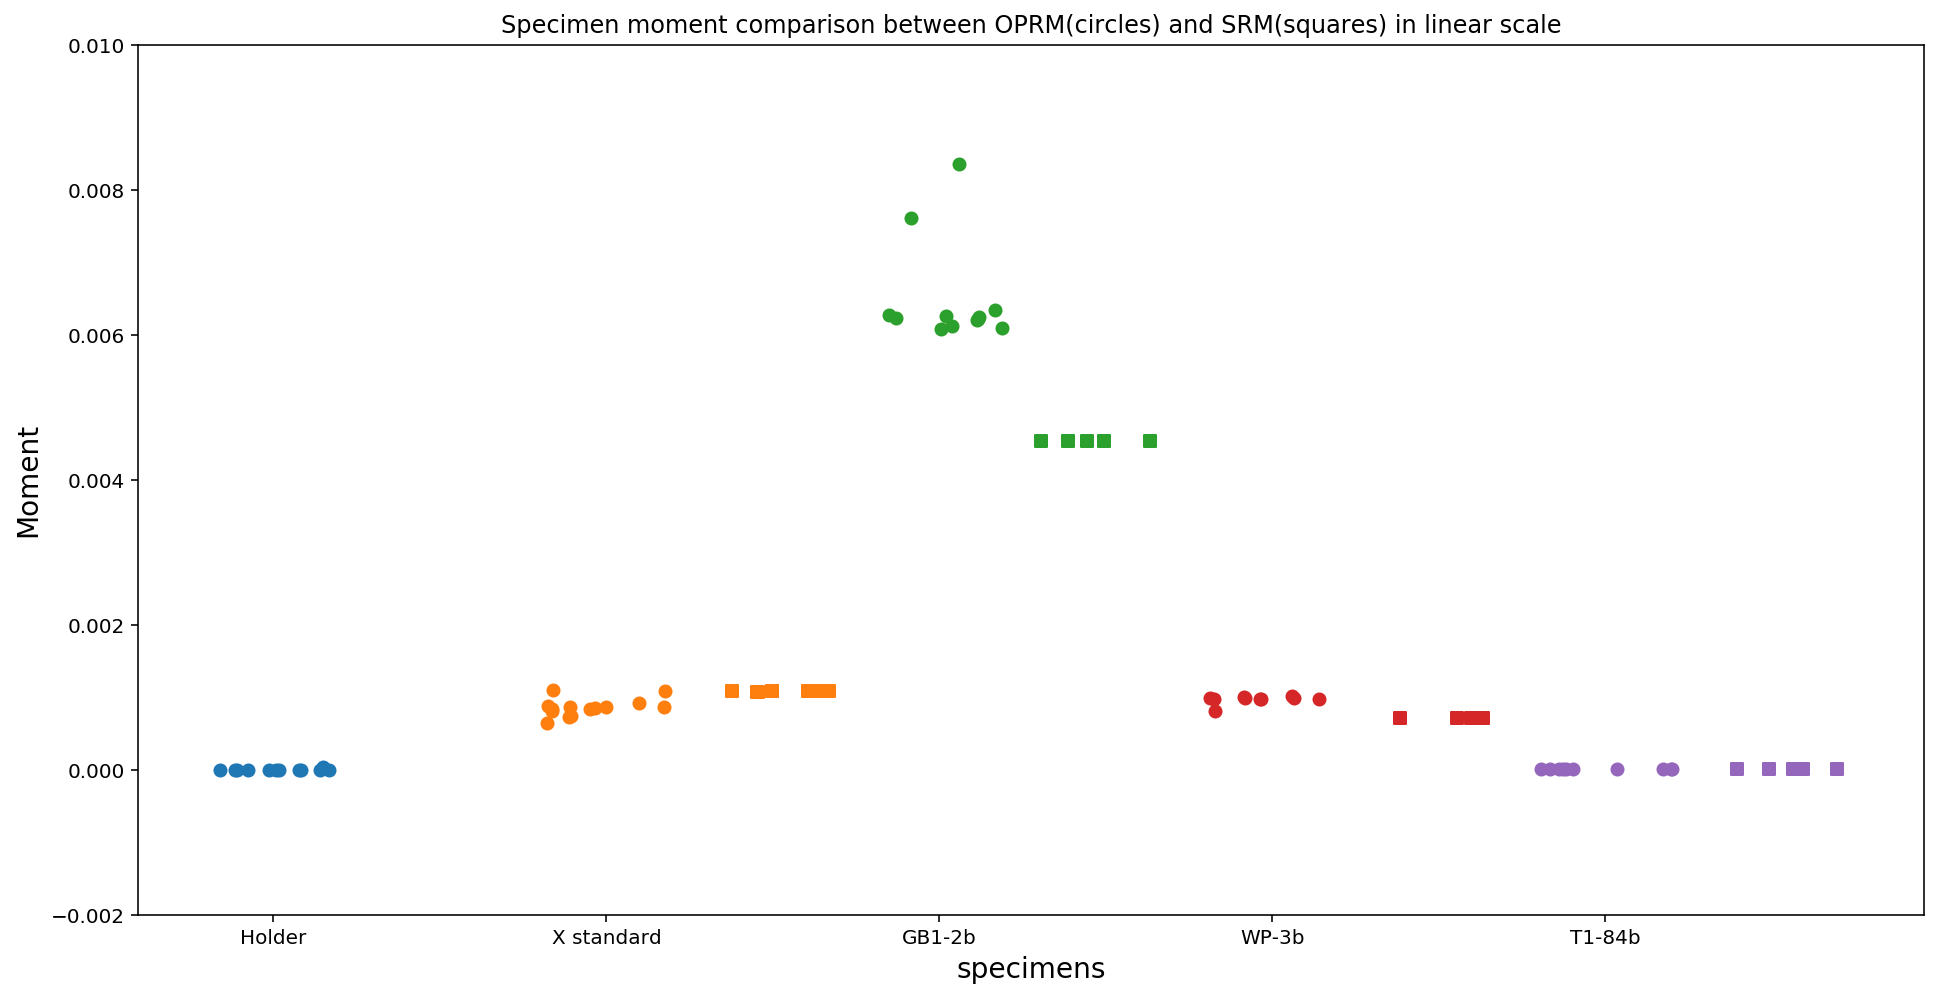

In [59]:

c1 = 'b'
c2 = 'r'
plt.figure(figsize=(16,8))
def stripplot(list_of_list, shift=0, random=False, marker='o', label=None):

    for i in range(len(list_of_list)):
        for j in list_of_list[i]:
            if random:
                plt.scatter(i+shift+np.random.uniform(-0.2,0.2), j, color = 'C'+str(i), marker = marker, label = label)
            else:
                plt.scatter(i+shift, j, color = 'C'+str(i), marker = marker, label = label)

                   
stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], random = True, label = 'OPRM measurements')  
stripplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], random = True, 
          shift = 0.5, marker = 's', label = 'SM measurements')
# sns.stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c1, color=c1),
#             capprops=dict(color=c1),
#             whiskerprops=dict(color=c1),
#             flierprops=dict(color=c1, markeredgecolor=c1),
#             medianprops=dict(color=c1),
#             )
# sns.stripplot(Holder_OPRM['M'])
# sns.stripplot(X_OPRM['M'])
# sns.stripplot(GB1_2b_OPRM['M'])
# sns.stripplot(WP_3b_OPRM['M'])
# sns.stripplot(T1_84b_OPRM['M'])
# plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c2, color=c2),
#             capprops=dict(color=c2),
#             whiskerprops=dict(color=c2),
#             flierprops=dict(color=c2, markeredgecolor=c2),
#             medianprops=dict(color=c2),
#             )

# plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
# plt.yscale('log')
plt.ylim(-0.002, 1e-2)
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.xticks([0,1,2,3,4], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.title('Specimen moment comparison between OPRM(circles) and SRM(squares) in linear scale')
# plt.legend()
# plt.savefig('Figures/Moment_comparison.pdf')
plt.show()

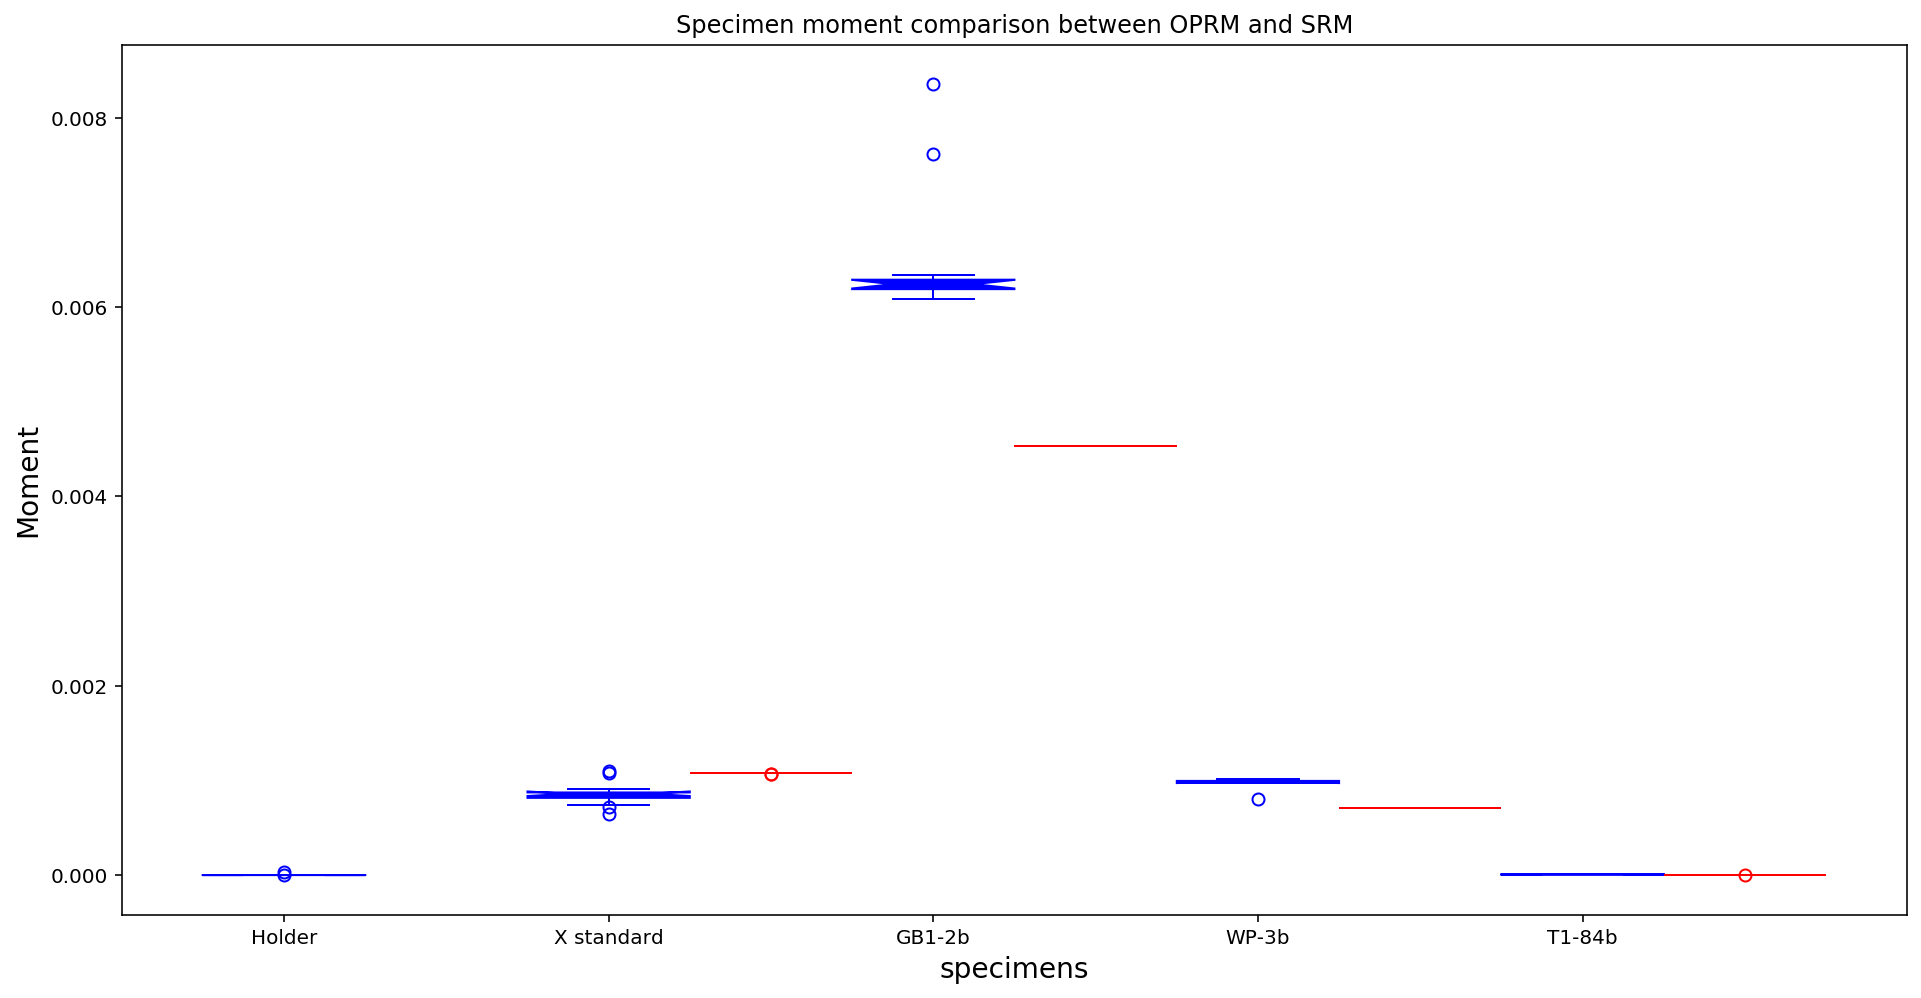

In [60]:
plt.figure(figsize=(16,8))
c1 = 'b'
c2 = 'r'
plt.boxplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c1, color=c1),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c1),
            flierprops=dict(color=c1, markeredgecolor=c1),
            medianprops=dict(color=c1),
            )

plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
            boxprops=dict(facecolor=c2, color=c2),
            capprops=dict(color=c2),
            whiskerprops=dict(color=c2),
            flierprops=dict(color=c2, markeredgecolor=c2),
            medianprops=dict(color=c2),
            )

plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
# plt.yscale('log')
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Specimen moment comparison between OPRM and SRM')
# plt.savefig('Figures/Moment_comparison.pdf')
plt.show()

In [61]:
pmag.dir_df_fisher_mean??

Signature: pmag.dir_df_fisher_mean(dir_df)
Source:   
def dir_df_fisher_mean(dir_df):
    """
    calculates fisher mean for Pandas data frame

    Parameters
    __________
    dir_df: pandas data frame with columns:
        dir_dec : declination
        dir_inc : inclination
    Returns
    -------
    fpars : dictionary containing the Fisher mean and statistics
        dec : mean declination
        inc : mean inclination
        r : resultant vector length
        n : number of data points
        k : Fisher k value
        csd : Fisher circular standard deviation
        alpha95 : Fisher circle of 95% confidence
    """
    N = dir_df.dir_dec.values.shape[0]  # number of data points
    fpars = {}
    if N < 2:
        return fpars
    dirs = dir_df[['dir_dec', 'dir_inc']].values
    X = dir2cart(dirs).transpose()
    Xbar = np.array([X[0].sum(), X[1].sum(), X[2].sum()])
    R = np.sqrt(Xbar[0]**2+Xbar[1]**2+Xbar[2]**2)
    Xbar = Xbar/R
    dir = cart2dir(Xbar)
    fpars["dec"] =

## Crystal Springs diabase test samples

### CS1-1a

In [62]:
CS1_1a_SRM_file = read_SRM_file('SRM_data/CS1-1a')
CS1_1a_OPRM_file = read_OPRM_file('OPRM_data/CS1-1a.csv')
CS1_1a_OPRM_file_mean = average_measurements(CS1_1a_OPRM_file)

In [63]:
display(CS1_1a_SRM_file.head())
display(CS1_1a_OPRM_file_mean.head())

step      dec       inc       Ms blank quality
0   NRM 2.13E+02  1.20E+00 4.20E-04             g
1  100  2.12E+02  4.00E-01 4.13E-04             g
2  150  2.12E+02 -0.00E+00 4.01E-04             g
3  200  2.14E+02 -3.00E+00 3.32E-04             g
4  250  2.10E+02 -4.00E+00 3.11E-04             g

step      dec       inc       Ms blank quality
0  100 2.13E+02  6.98E-01 6.13E-04             g
1  150 2.14E+02 -2.78E-01 5.74E-04             g
2  200 2.13E+02 -2.88E+00 5.04E-04             g
3  250 2.12E+02 -3.49E+00 4.59E-04             g
4  300 2.13E+02 -5.89E+00 3.91E-04             g

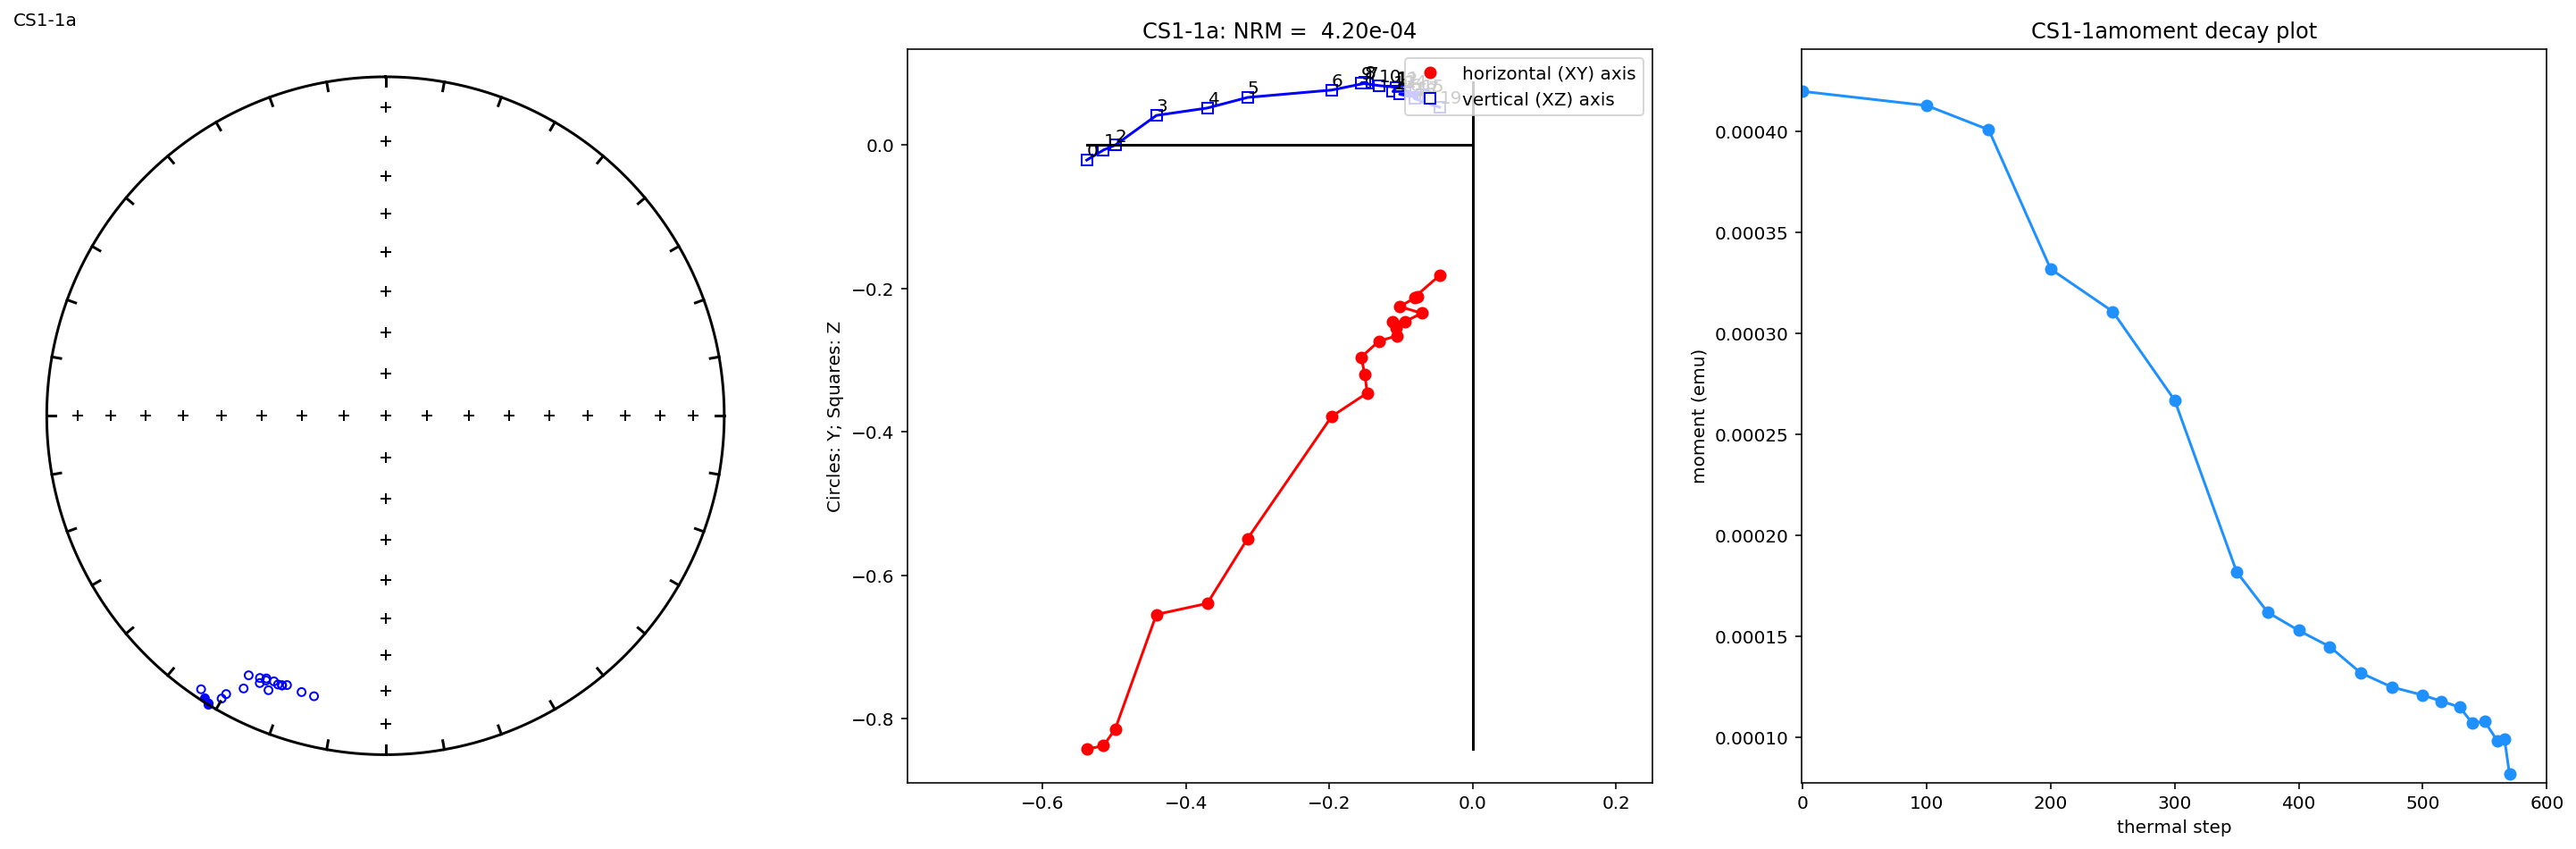

In [64]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS1_1a_SRM_file[['dec','inc']].values.tolist(), 'CS1-1a')
fig.add_subplot(132)
plot_zij(CS1_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS1-1a')
fig.add_subplot(133)
CS1_1a_SRM_step, CS1_1a_SRM_Ms =plot_mag(CS1_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS1-1a')
plt.subplots_adjust(wspace = 0.2 )

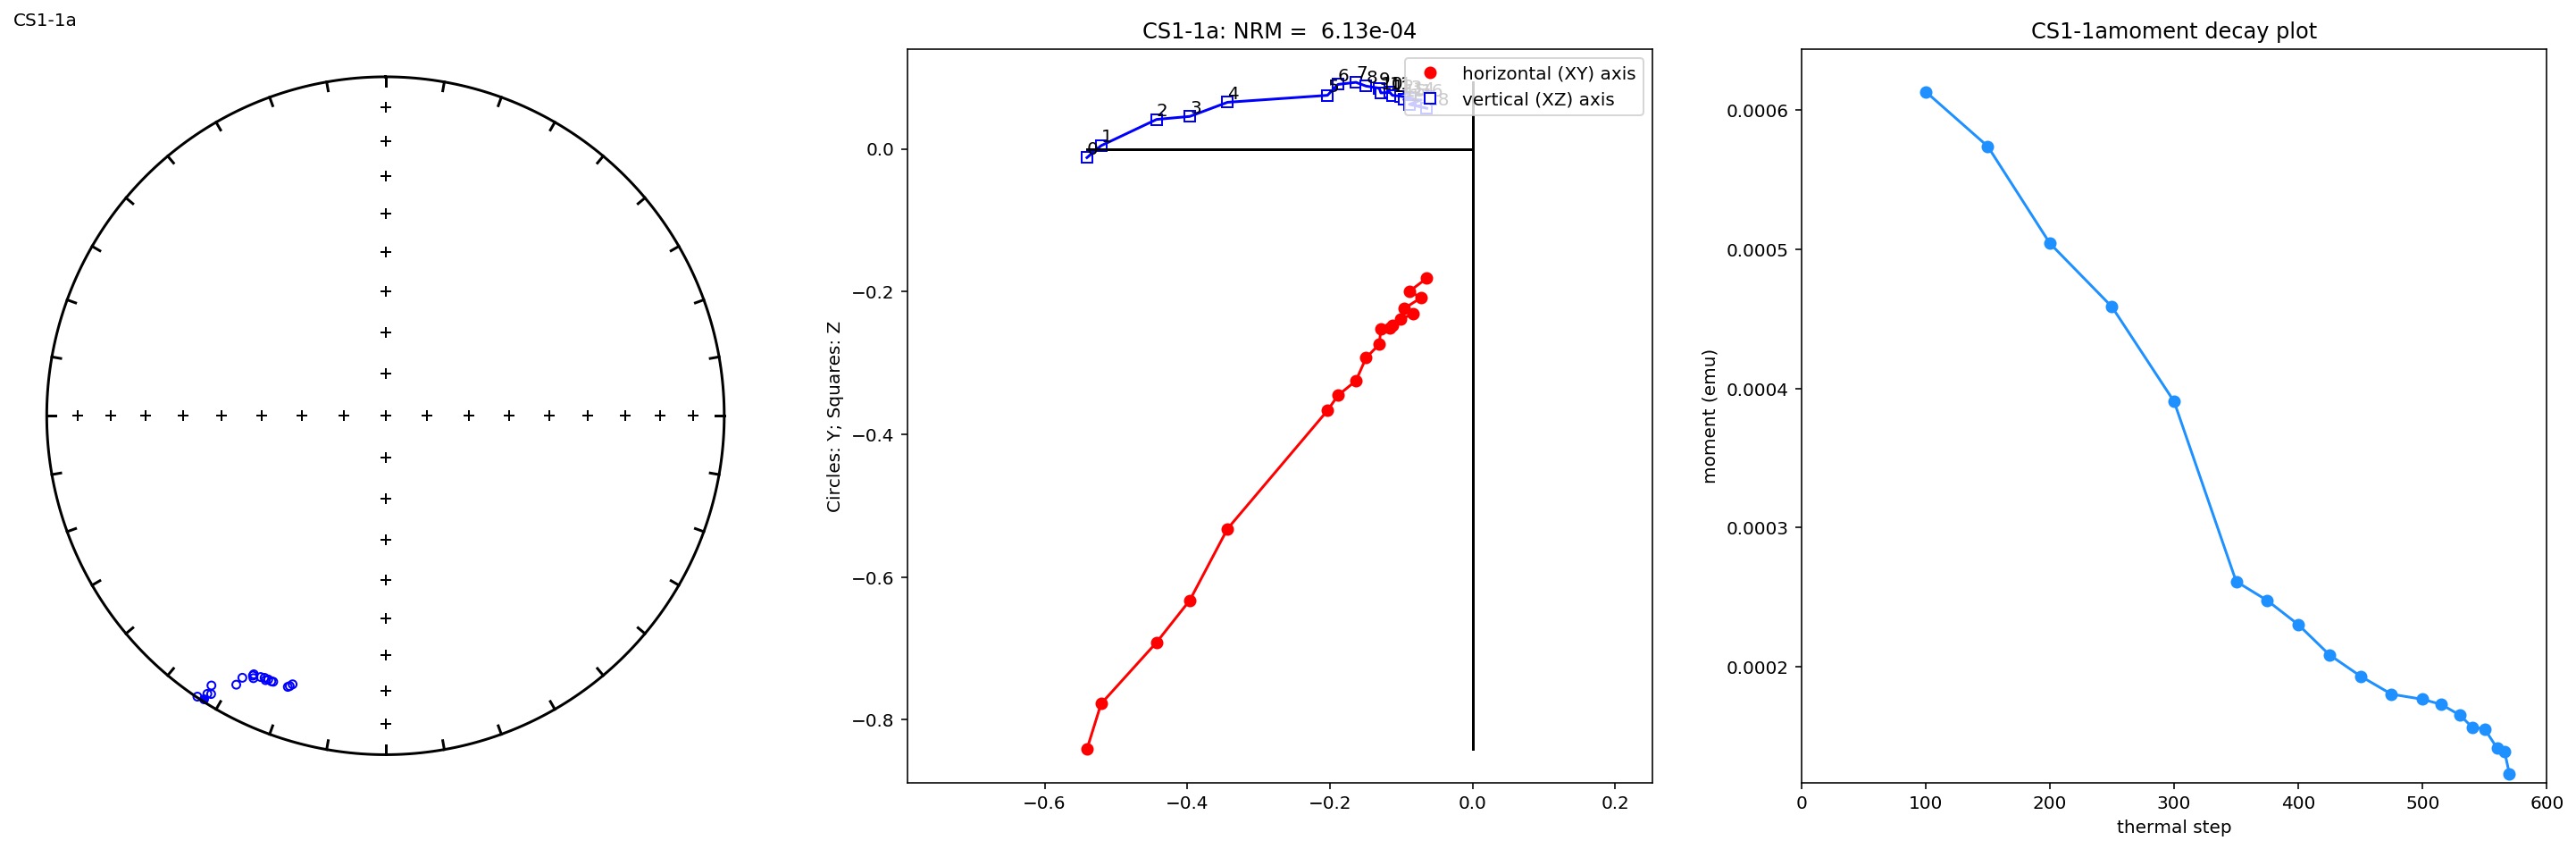

In [65]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS1_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS1-1a')
fig.add_subplot(132)
plot_zij(CS1_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS1-1a')
fig.add_subplot(133)
CS1_1a_OPRM_step, CS1_1a_OPRM_Ms  = plot_mag(CS1_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS1-1a')
plt.subplots_adjust(wspace = 0.2 )

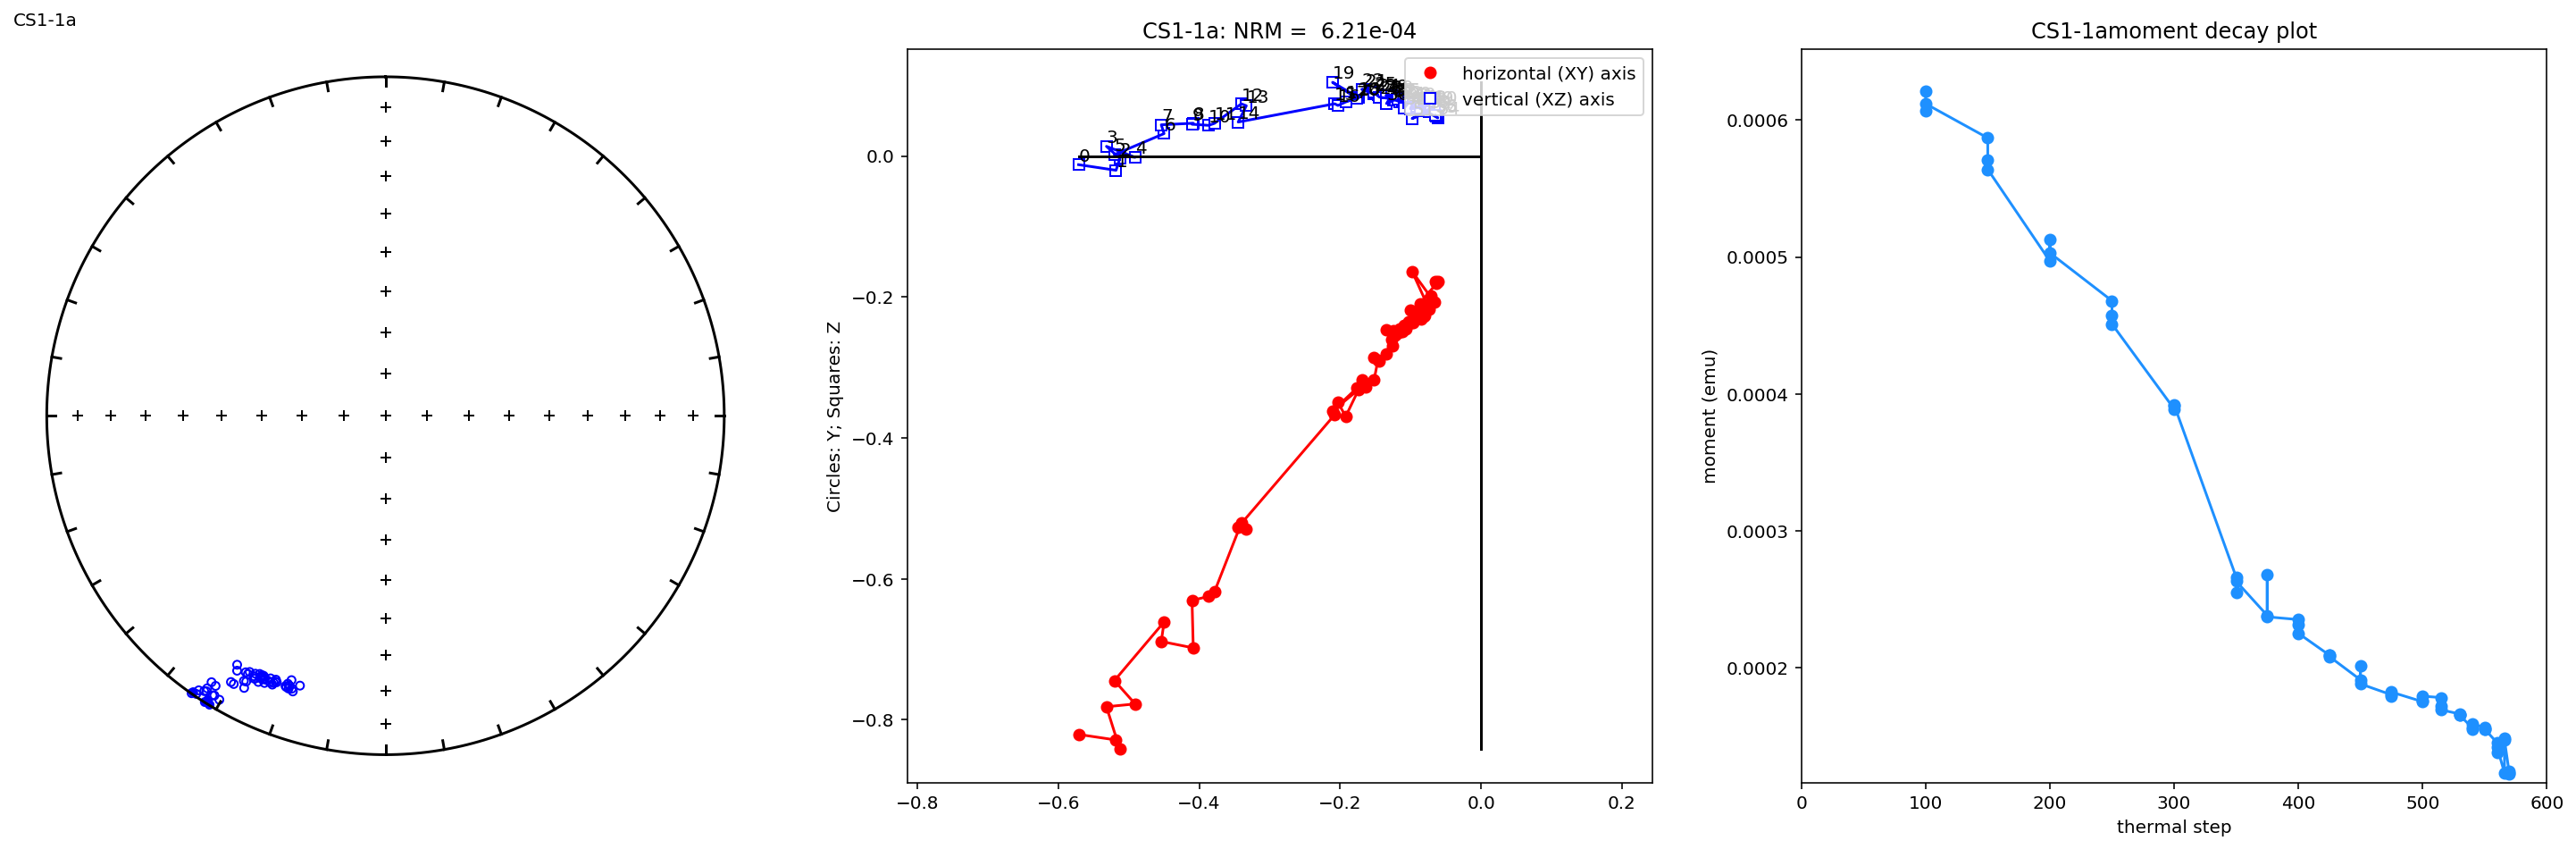

In [66]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS1_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS1-1a')
fig.add_subplot(132)
plot_zij(CS1_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS1-1a')
fig.add_subplot(133)
CS1_1a_OPRM_step_all, CS1_1a_OPRM_Ms_all  = plot_mag(CS1_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS1-1a')
plt.subplots_adjust(wspace = 0.2 )

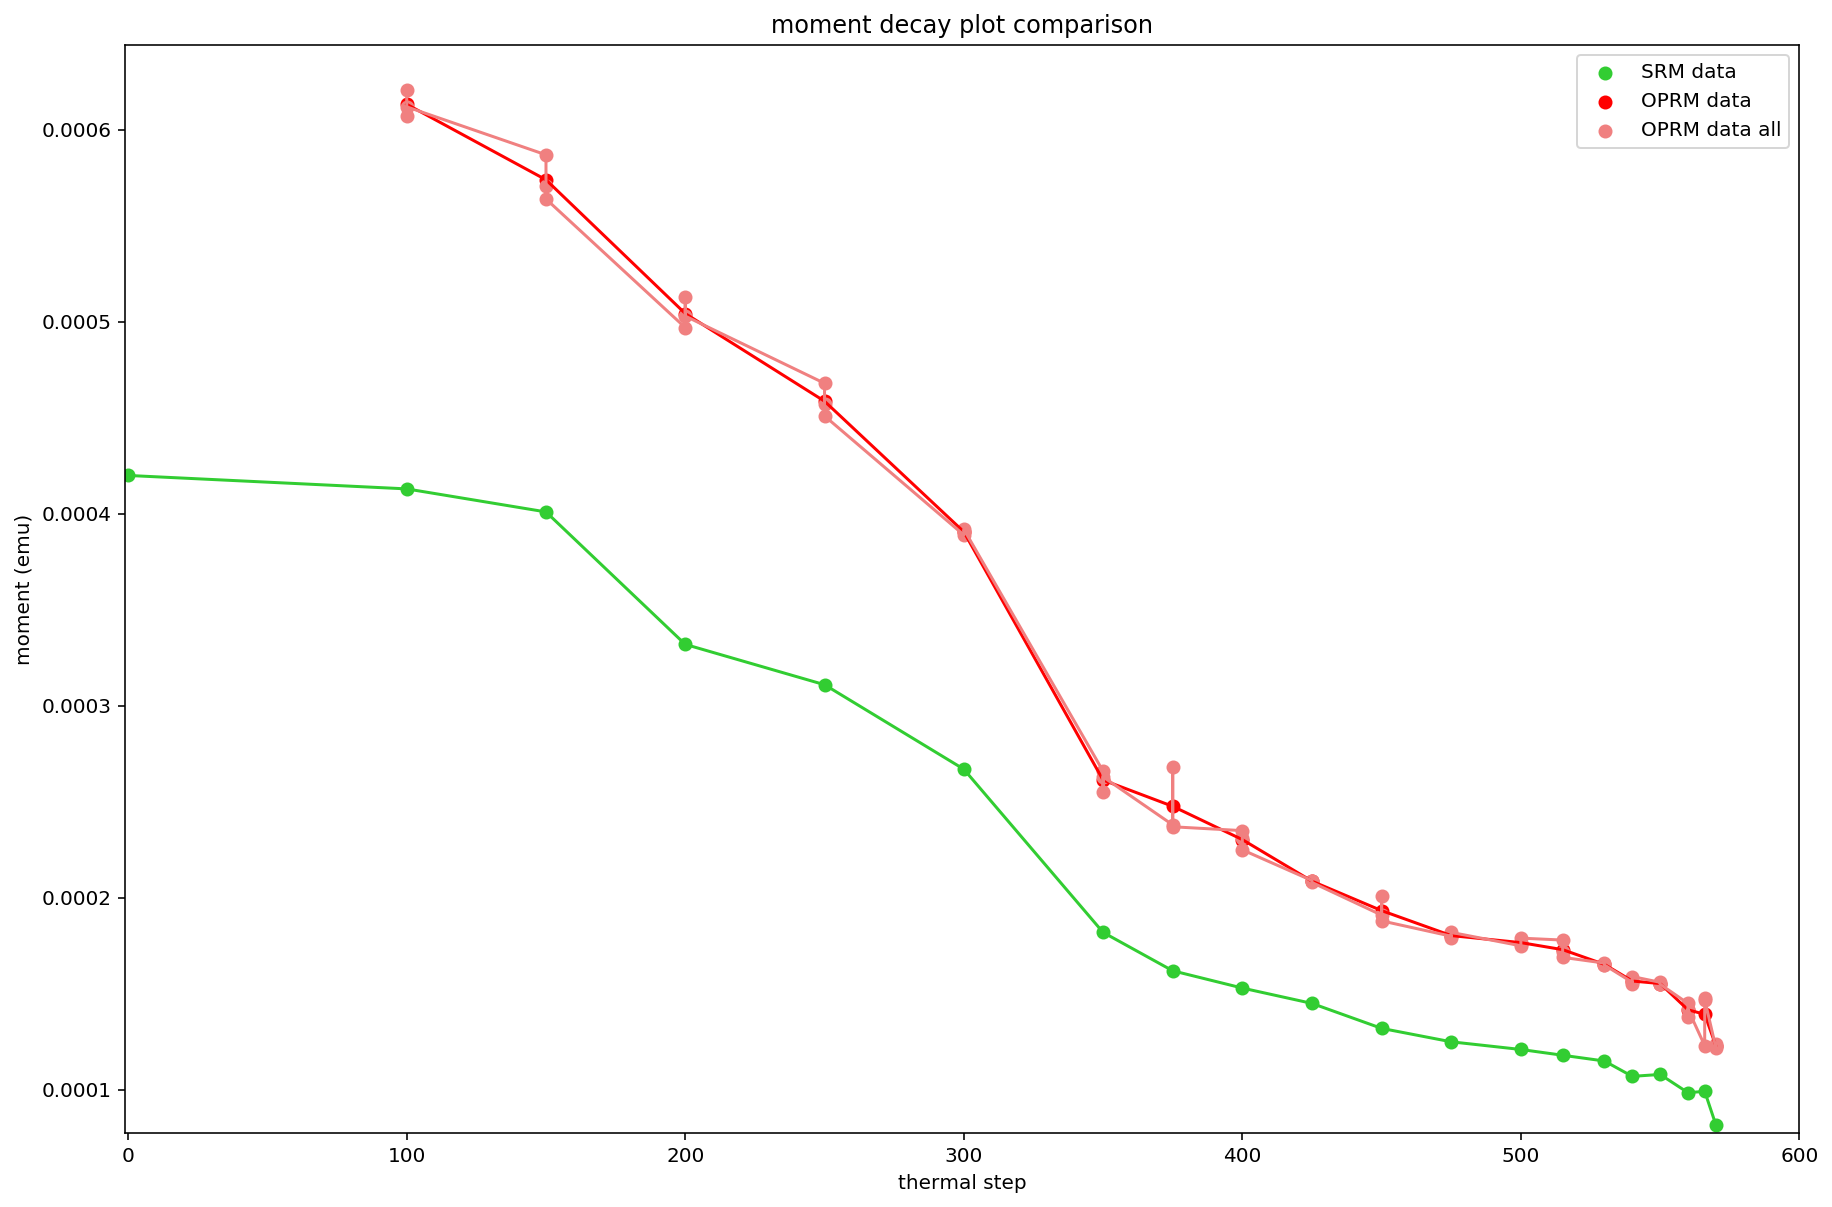

In [67]:
moment_comparison(CS1_1a_SRM_step, CS1_1a_SRM_Ms, CS1_1a_OPRM_step, CS1_1a_OPRM_Ms, CS1_1a_OPRM_step_all, CS1_1a_OPRM_Ms_all, 'CS1-1a')

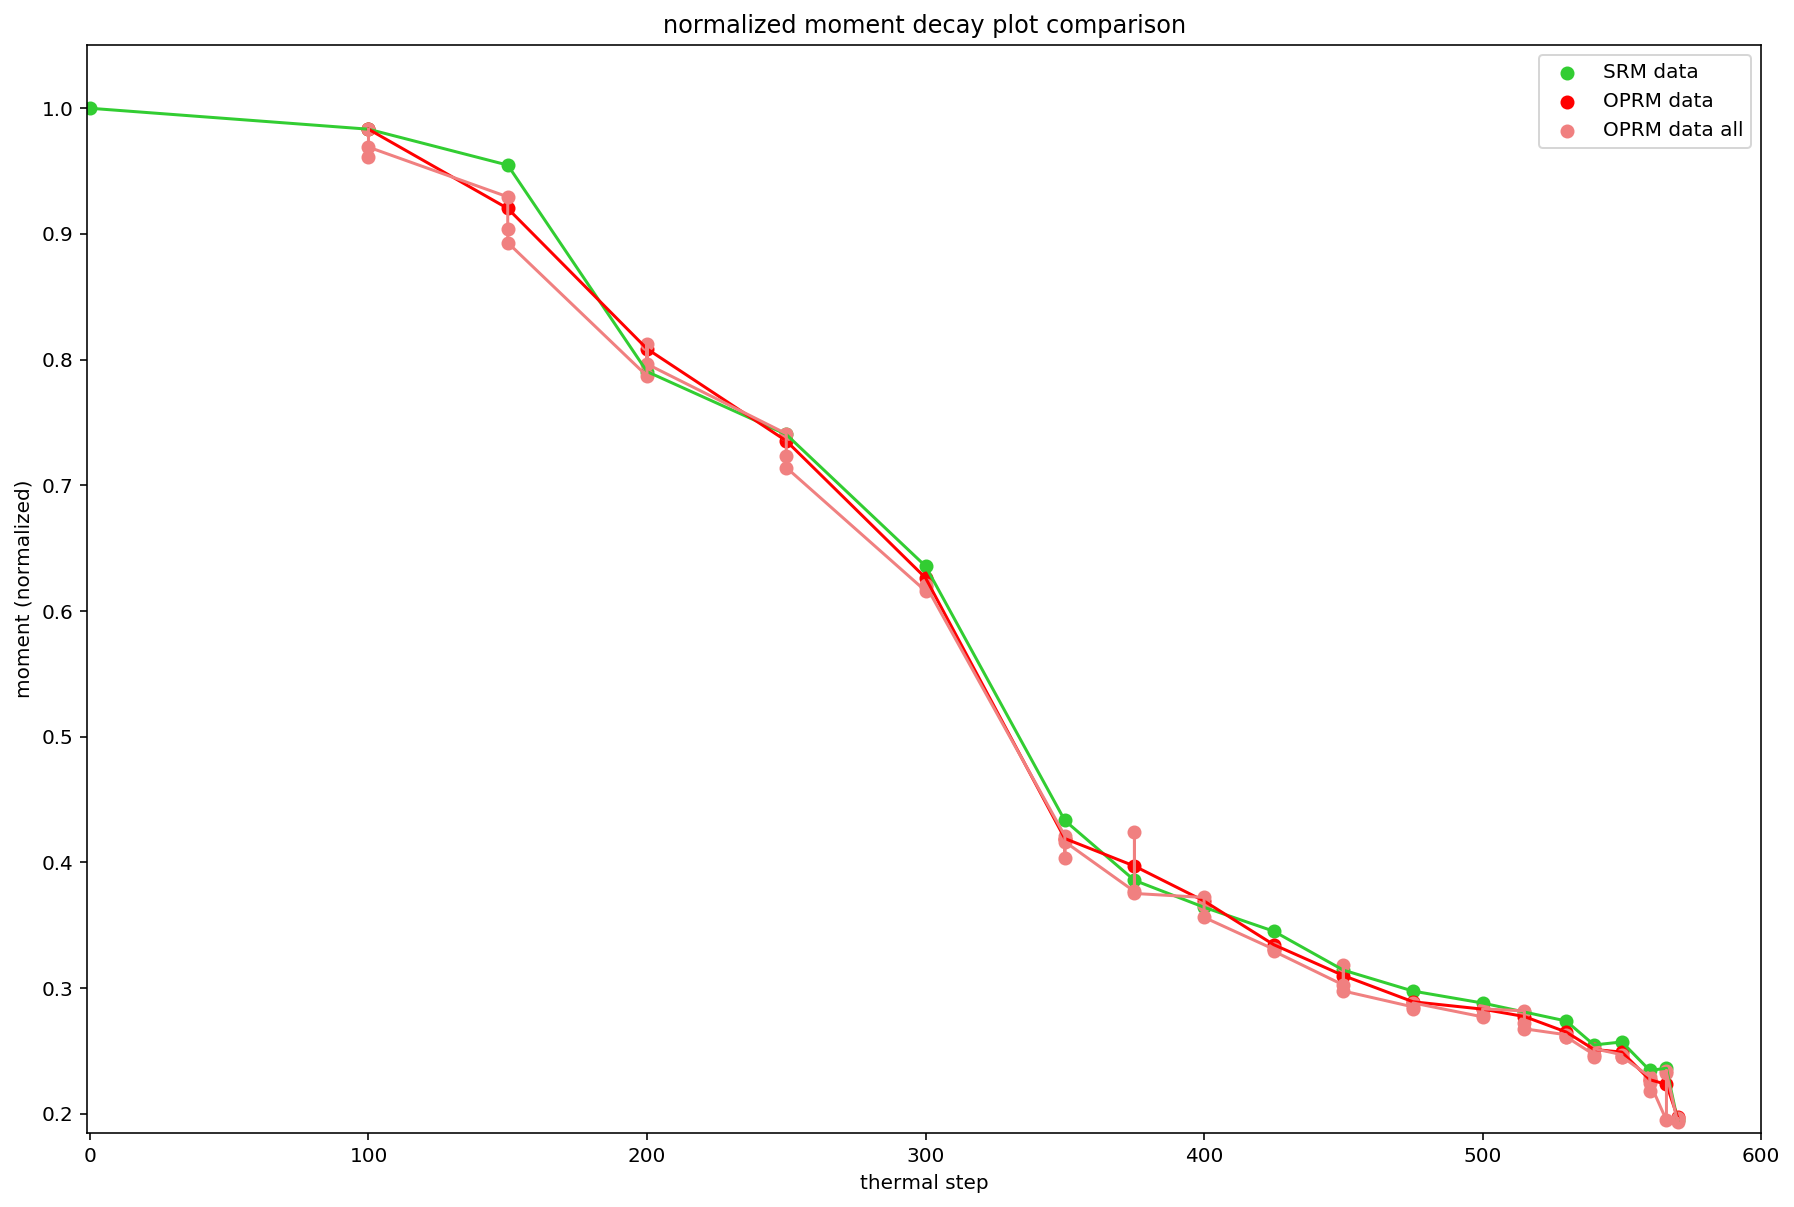

In [108]:
moment_comparison_normalized(CS1_1a_SRM_step, CS1_1a_SRM_Ms, CS1_1a_OPRM_step, CS1_1a_OPRM_Ms, CS1_1a_OPRM_step_all, CS1_1a_OPRM_Ms_all, 'CS1-1a')

### CS2-1a

In [69]:
CS2_1a_SRM_file = read_SRM_file('SRM_data/CS2-1a')
CS2_1a_OPRM_file = read_OPRM_file('OPRM_data/CS2-1a.csv')
CS2_1a_OPRM_file_mean = average_measurements(CS2_1a_OPRM_file)

In [70]:
display(CS2_1a_SRM_file.head())
display(CS2_1a_OPRM_file_mean.head())

step      dec       inc       Ms blank quality
0   NRM 1.55E+02 -1.82E+01 1.33E-04             g
1  100  1.60E+02 -1.75E+01 1.17E-04             g
2  150  1.51E+02 -1.41E+01 9.51E-05             g
3  200  1.43E+02 -1.28E+01 8.38E-05             g
4  250  1.46E+02 -1.22E+01 8.00E-05             g

step      dec       inc       Ms blank quality
0  100 1.51E+02 -1.91E+01 1.80E-04             g
1  150 1.46E+02 -1.54E+01 1.41E-04             g
2  200 1.43E+02 -1.31E+01 1.28E-04             g
3  250 1.39E+02 -1.43E+01 1.12E-04             g
4  300 1.45E+02 -1.44E+01 1.14E-04             g

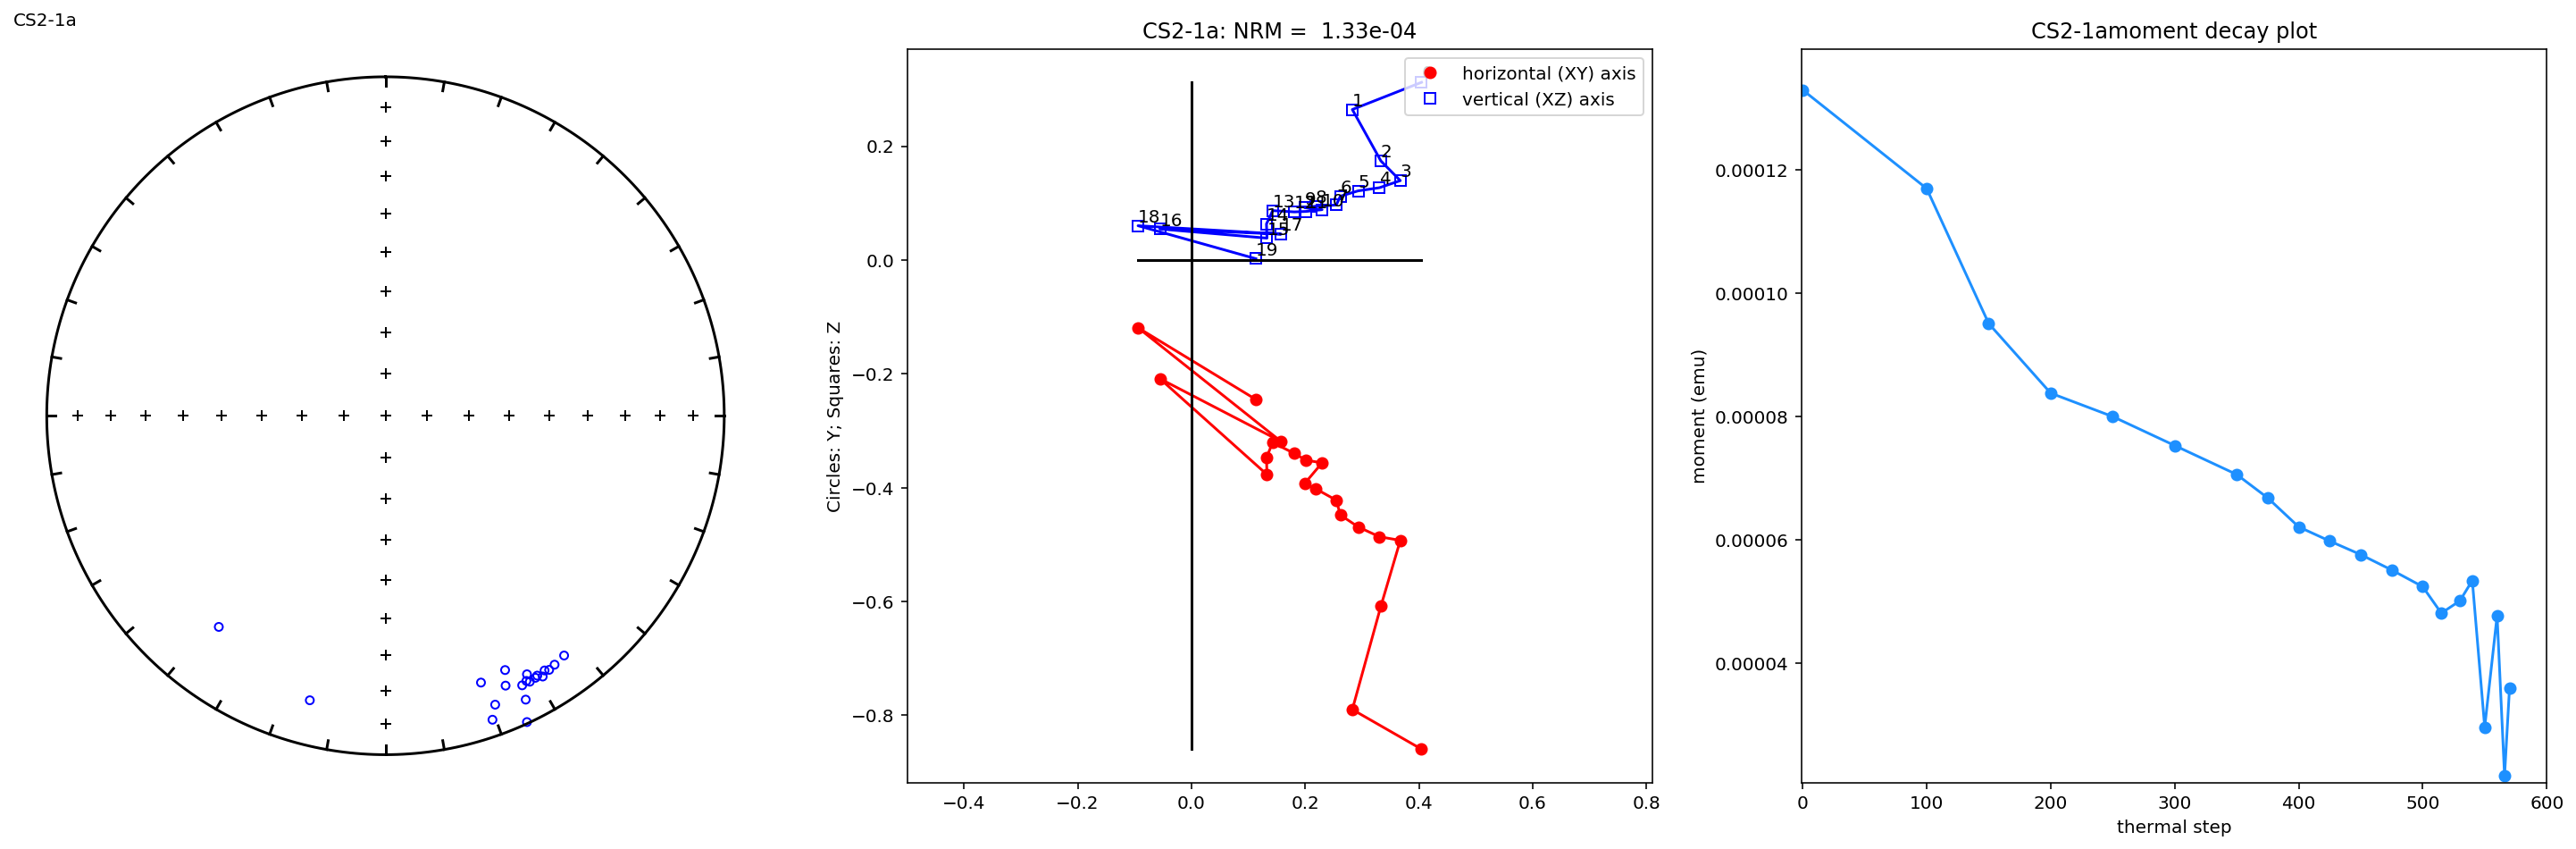

In [71]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS2_1a_SRM_file[['dec','inc']].values.tolist(), 'CS2-1a')
fig.add_subplot(132)
plot_zij(CS2_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS2-1a')
fig.add_subplot(133)
CS2_1a_SRM_step, CS2_1a_SRM_Ms = plot_mag(CS2_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS2-1a')
plt.subplots_adjust(wspace = 0.2 )

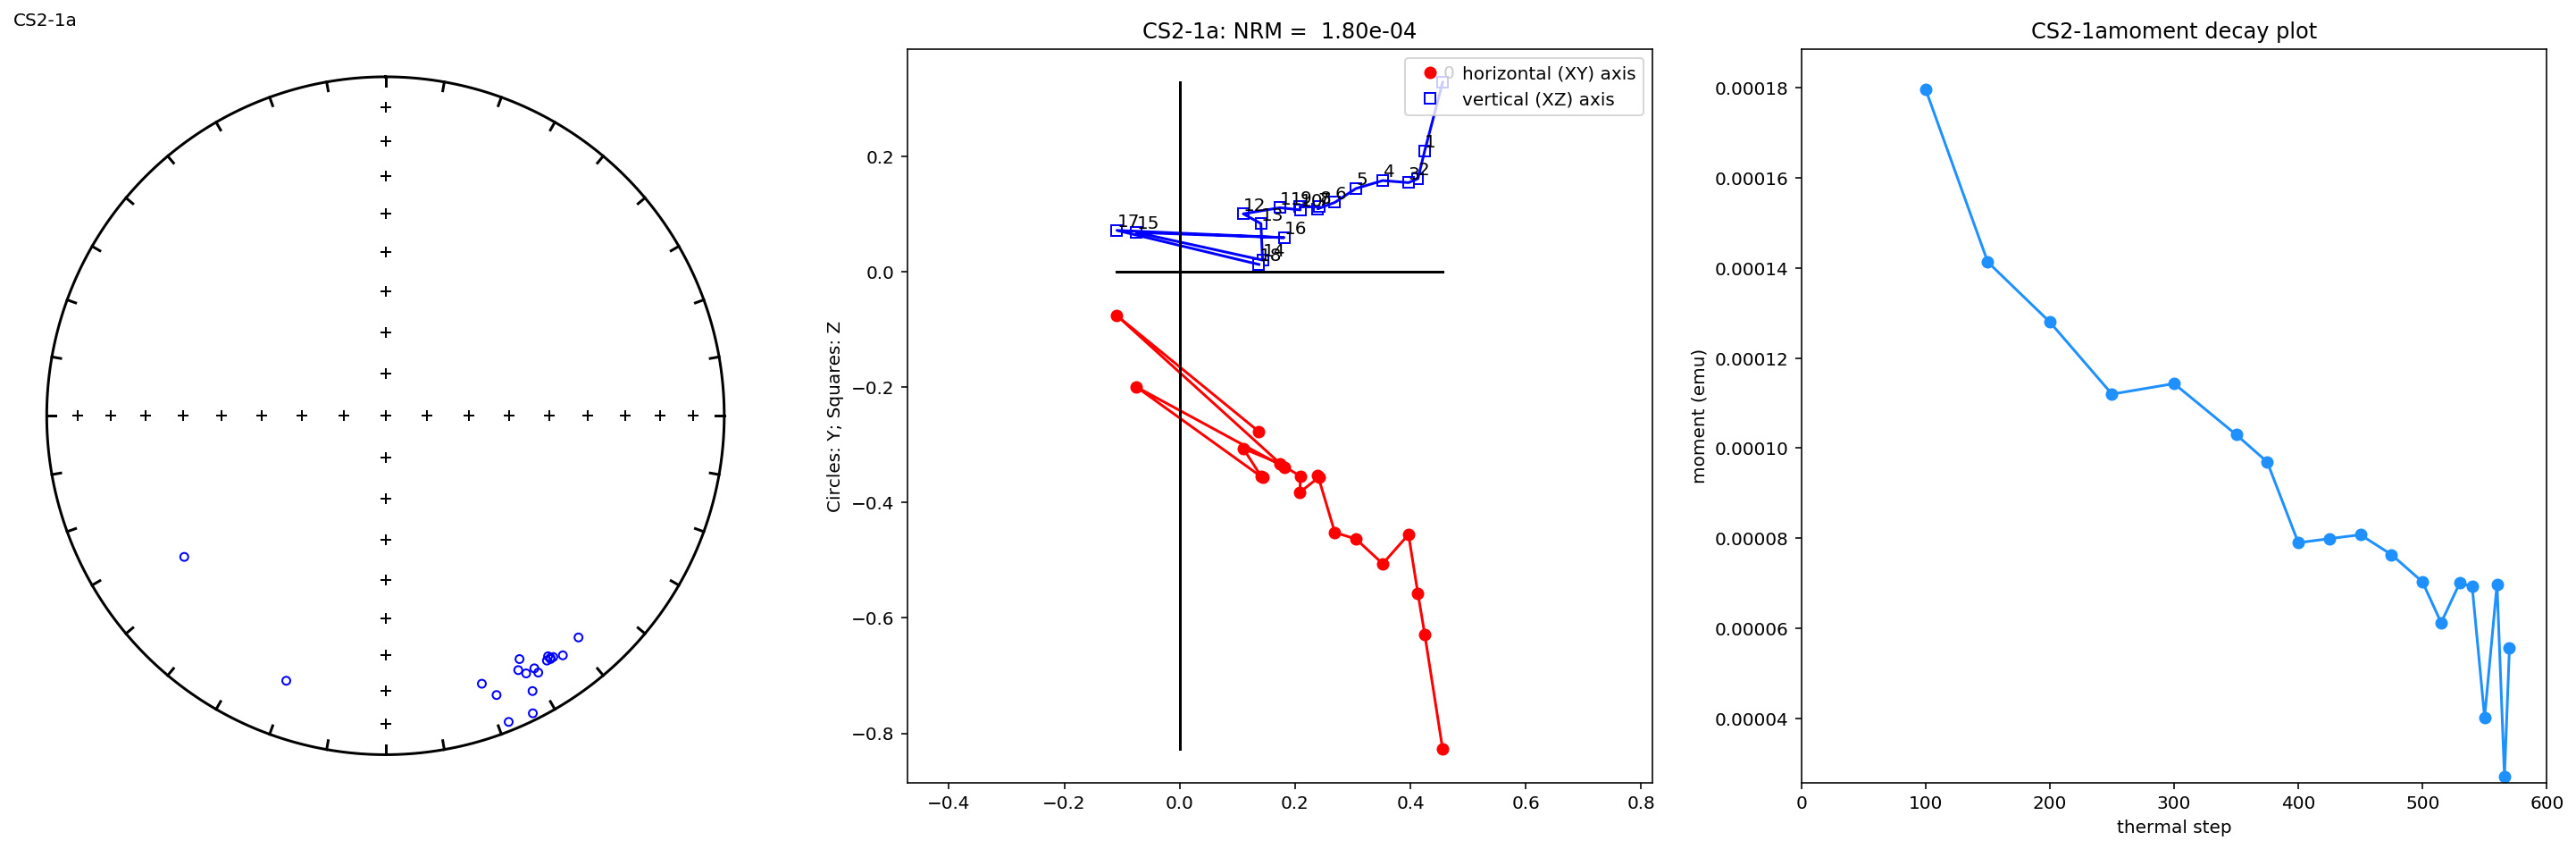

In [72]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS2_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS2-1a')
fig.add_subplot(132)
plot_zij(CS2_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS2-1a')
fig.add_subplot(133)
CS2_1a_OPRM_step, CS2_1a_OPRM_Ms = plot_mag(CS2_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS2-1a')
plt.subplots_adjust(wspace = 0.2 )

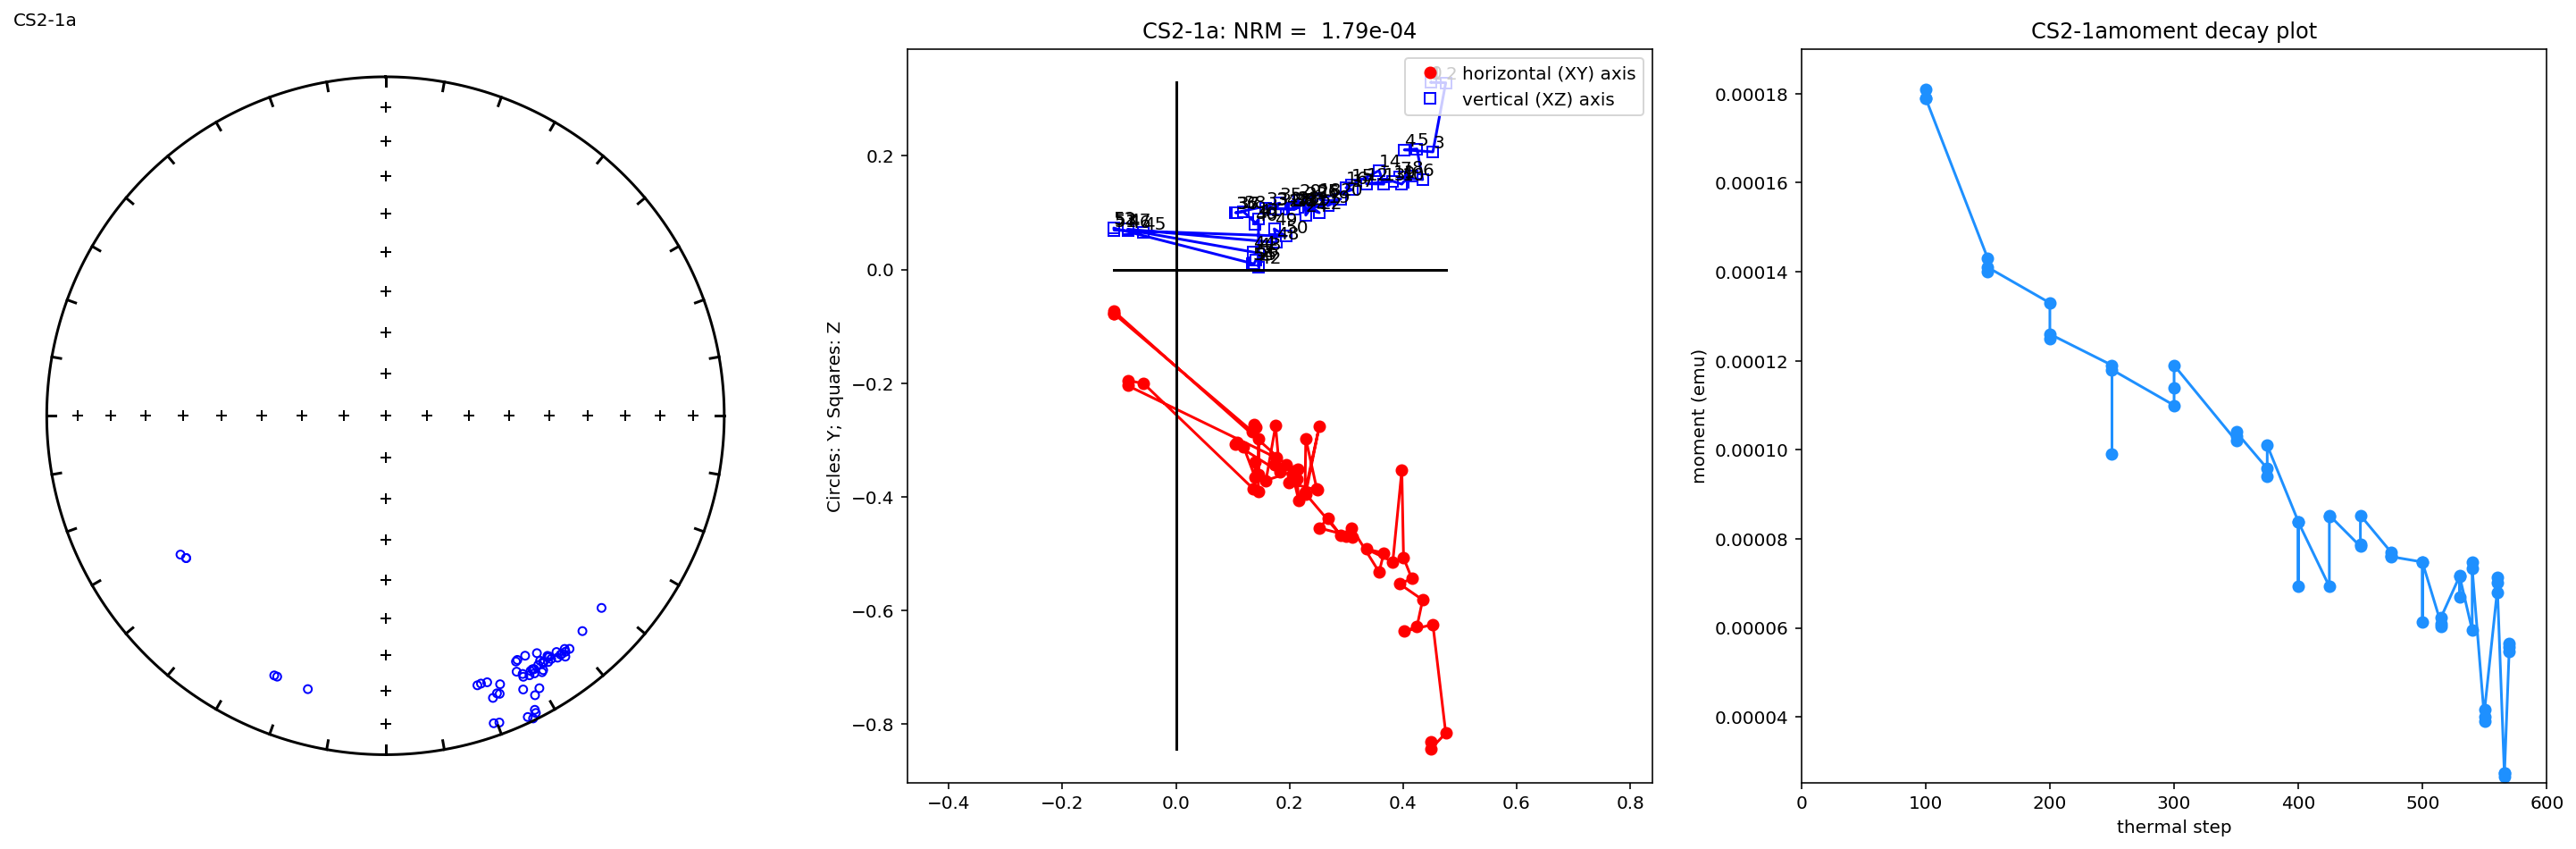

In [73]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS2_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS2-1a')
fig.add_subplot(132)
plot_zij(CS2_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS2-1a')
fig.add_subplot(133)
CS2_1a_OPRM_step_all, CS2_1a_OPRM_Ms_all  = plot_mag(CS2_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS2-1a')
plt.subplots_adjust(wspace = 0.2 )

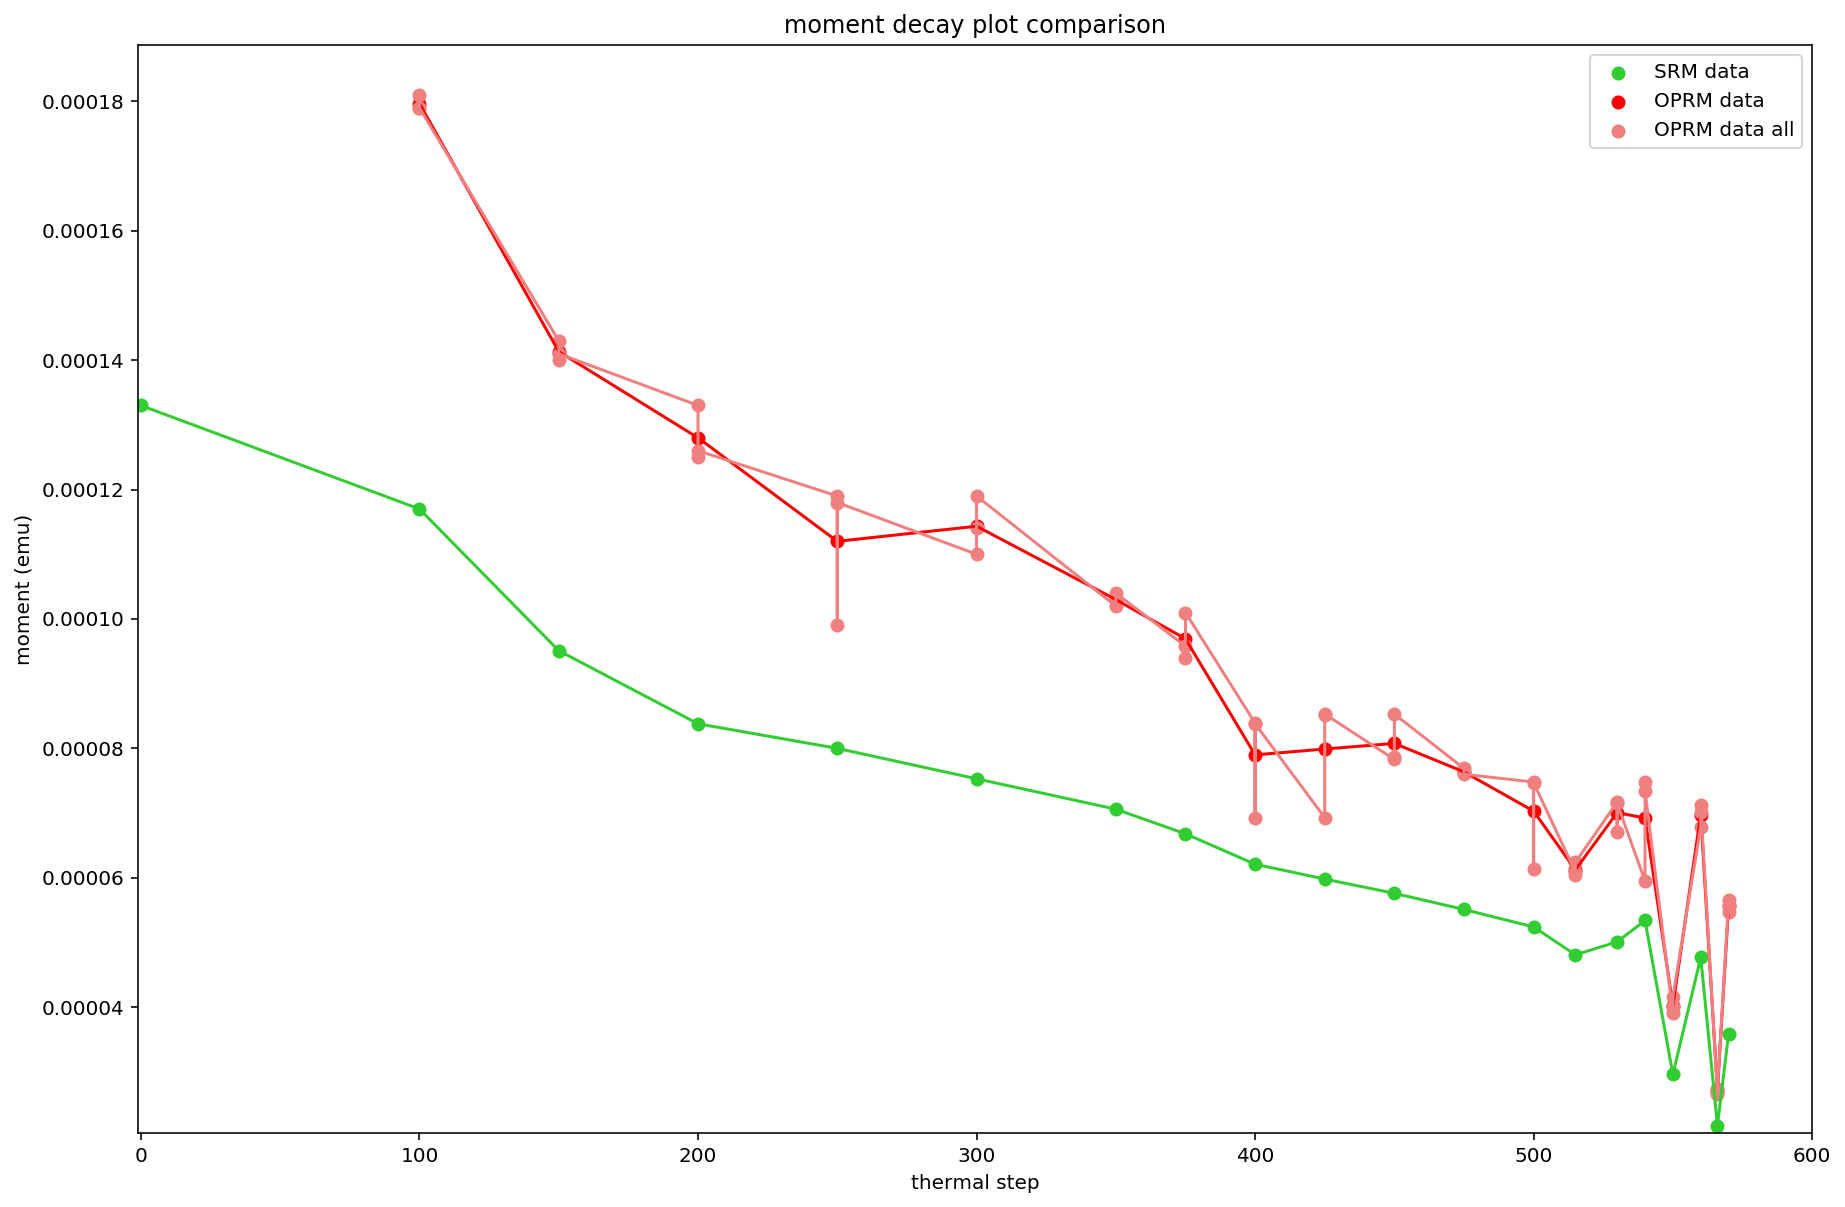

In [74]:
moment_comparison(CS2_1a_SRM_step, CS2_1a_SRM_Ms, CS2_1a_OPRM_step, CS2_1a_OPRM_Ms, CS2_1a_OPRM_step_all, CS2_1a_OPRM_Ms_all, 'CS2-1a')

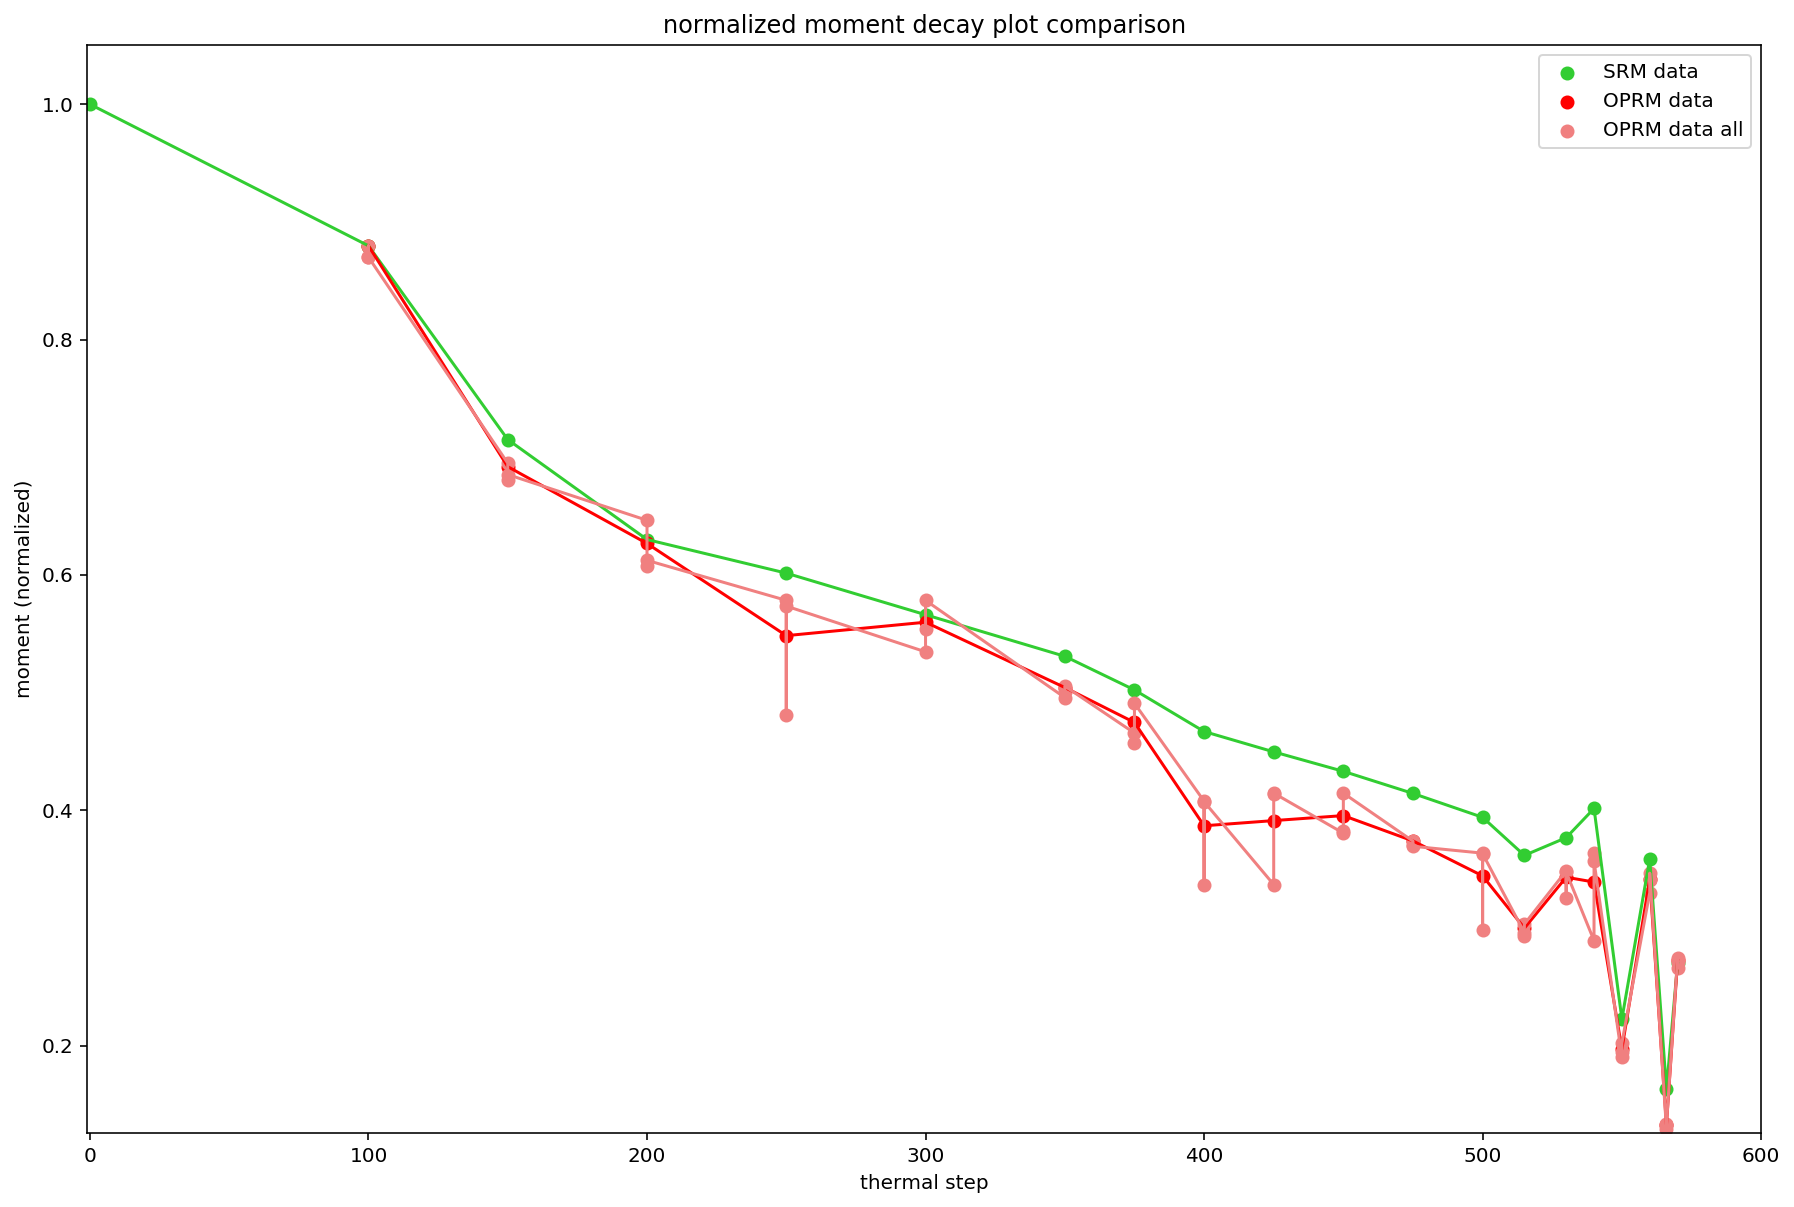

In [109]:
moment_comparison_normalized(CS2_1a_SRM_step, CS2_1a_SRM_Ms, CS2_1a_OPRM_step, CS2_1a_OPRM_Ms, CS2_1a_OPRM_step_all, CS2_1a_OPRM_Ms_all, 'CS2-1a')

### CS3-1a

In [76]:
CS3_1a_SRM_file = read_SRM_file('SRM_data/CS3-1a')
CS3_1a_SRM_file = CS3_1a_SRM_file.drop(4)
CS3_1a_OPRM_file = read_OPRM_file('OPRM_data/CS3-1a.csv')
CS3_1a_OPRM_file_mean = average_measurements(CS3_1a_OPRM_file)

In [77]:
display(CS3_1a_SRM_file.head())
display(CS3_1a_OPRM_file_mean.head())

step      dec      inc       Ms blank quality
0   NRM 7.43E+01 7.48E+01 4.40E-03             g
1  100  7.16E+01 7.17E+01 2.98E-03             g
2  150  6.54E+01 7.12E+01 1.62E-03             g
3  200  6.06E+01 7.06E+01 1.12E-03             g
5  250  5.55E+01 7.12E+01 8.29E-04             g

step      dec      inc       Ms blank quality
0  100 8.01E+01 7.24E+01 4.72E-03             g
1  150 7.34E+01 7.19E+01 2.66E-03             g
2  200 7.34E+01 7.13E+01 2.13E-03             g
3  250 7.68E+01 7.05E+01 1.32E-03             g
4  300 8.52E+01 7.01E+01 1.09E-03             g

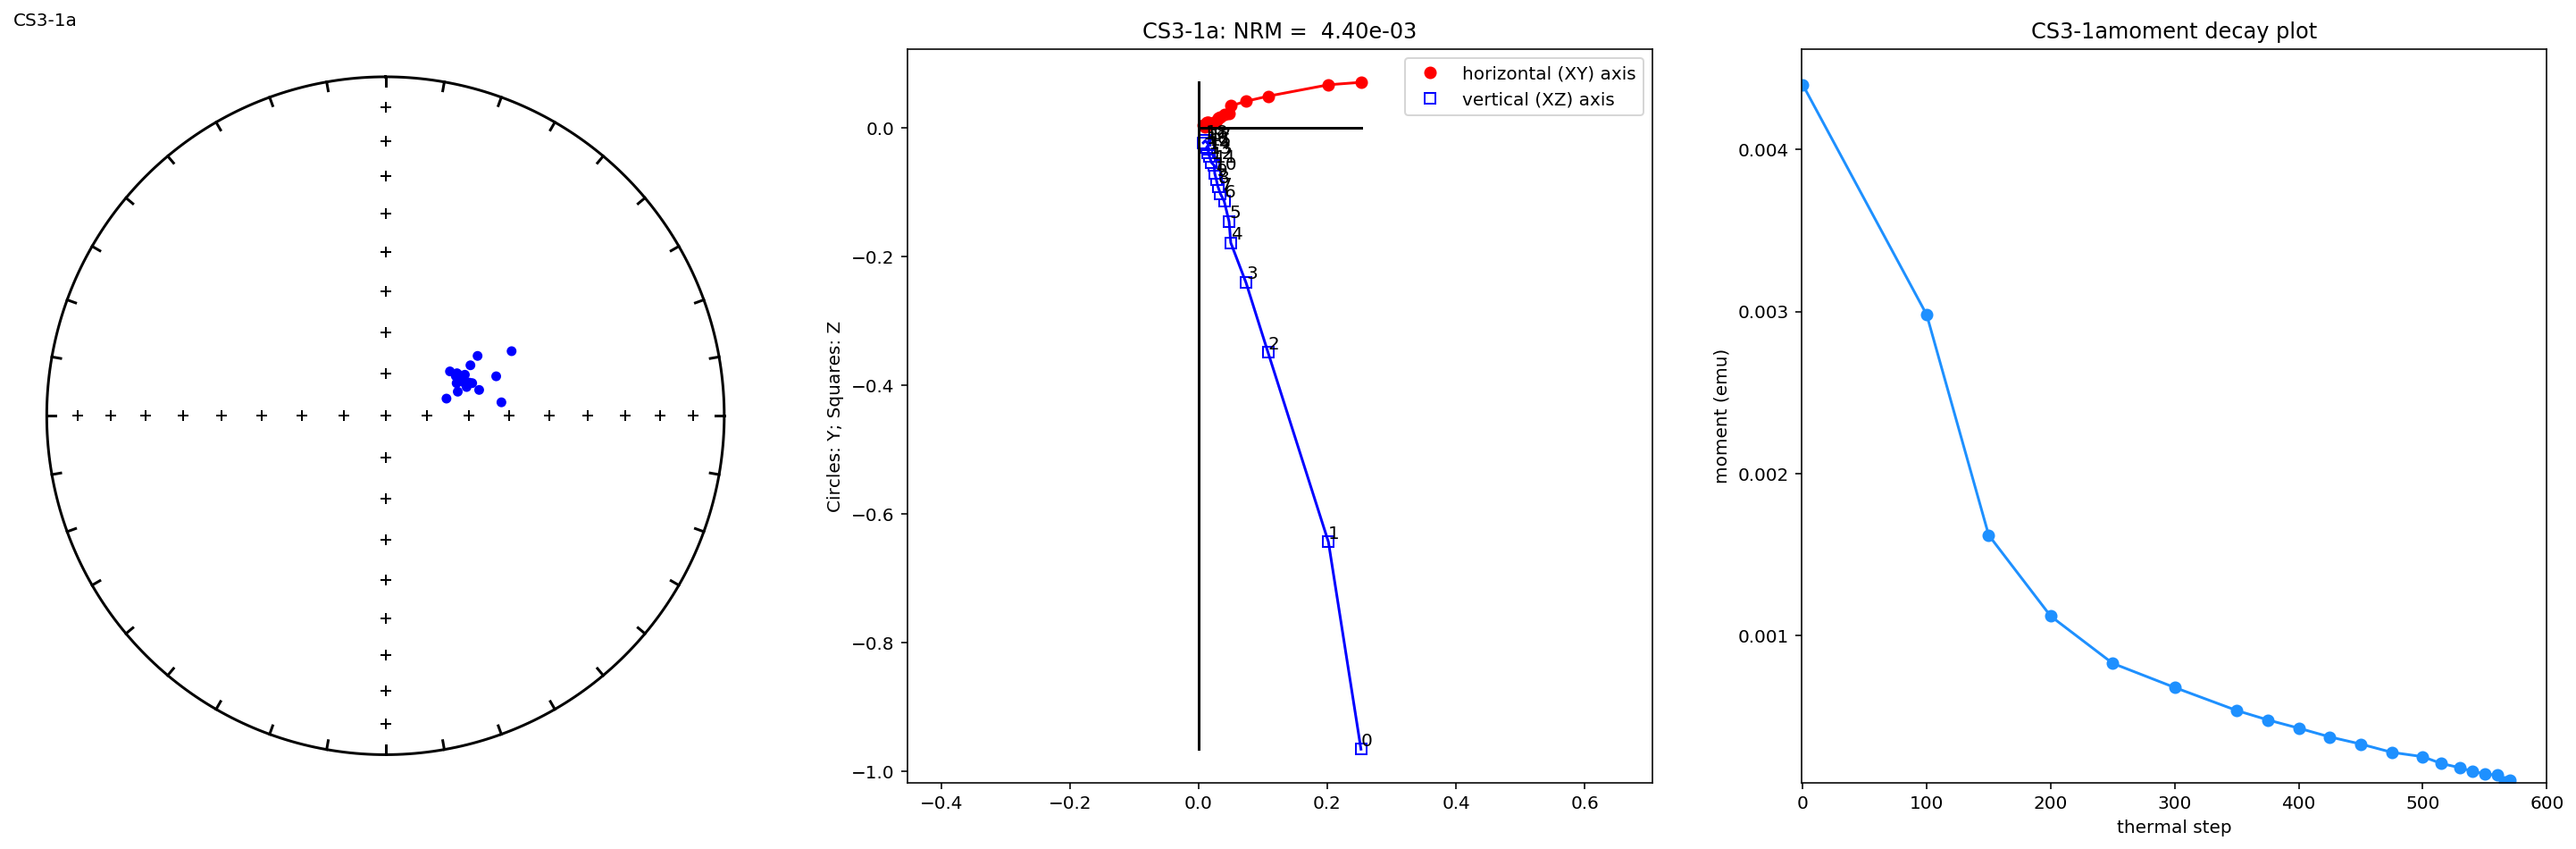

In [78]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS3_1a_SRM_file[['dec','inc']].values.tolist(), 'CS3-1a')
fig.add_subplot(132)
plot_zij(CS3_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS3-1a')
fig.add_subplot(133)
CS3_1a_SRM_step, CS3_1a_SRM_Ms = plot_mag(CS3_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS3-1a')
plt.subplots_adjust(wspace = 0.2 )

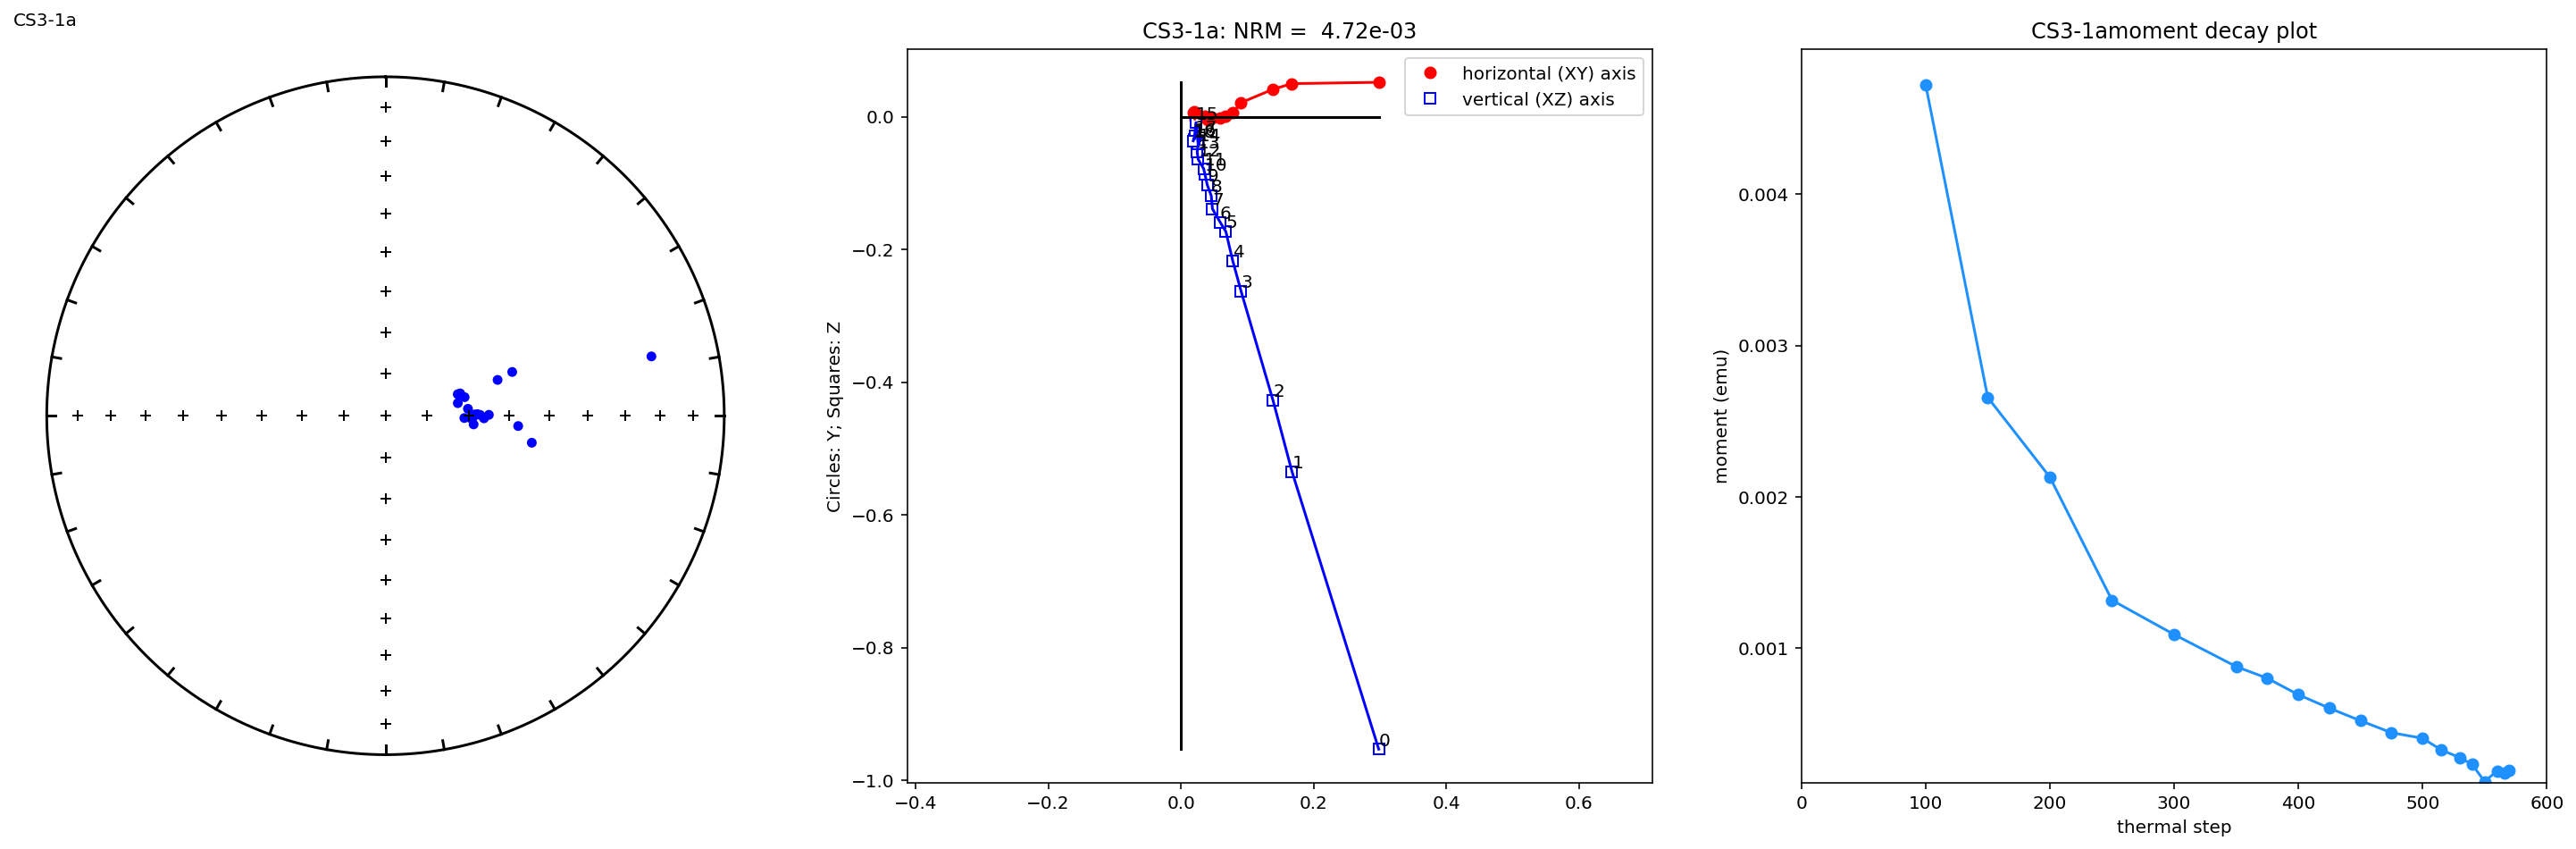

In [79]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS3_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS3-1a')
fig.add_subplot(132)
plot_zij(CS3_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS3-1a')
fig.add_subplot(133)
CS3_1a_OPRM_step, CS3_1a_OPRM_Ms  = plot_mag(CS3_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS3-1a')
plt.subplots_adjust(wspace = 0.2 )

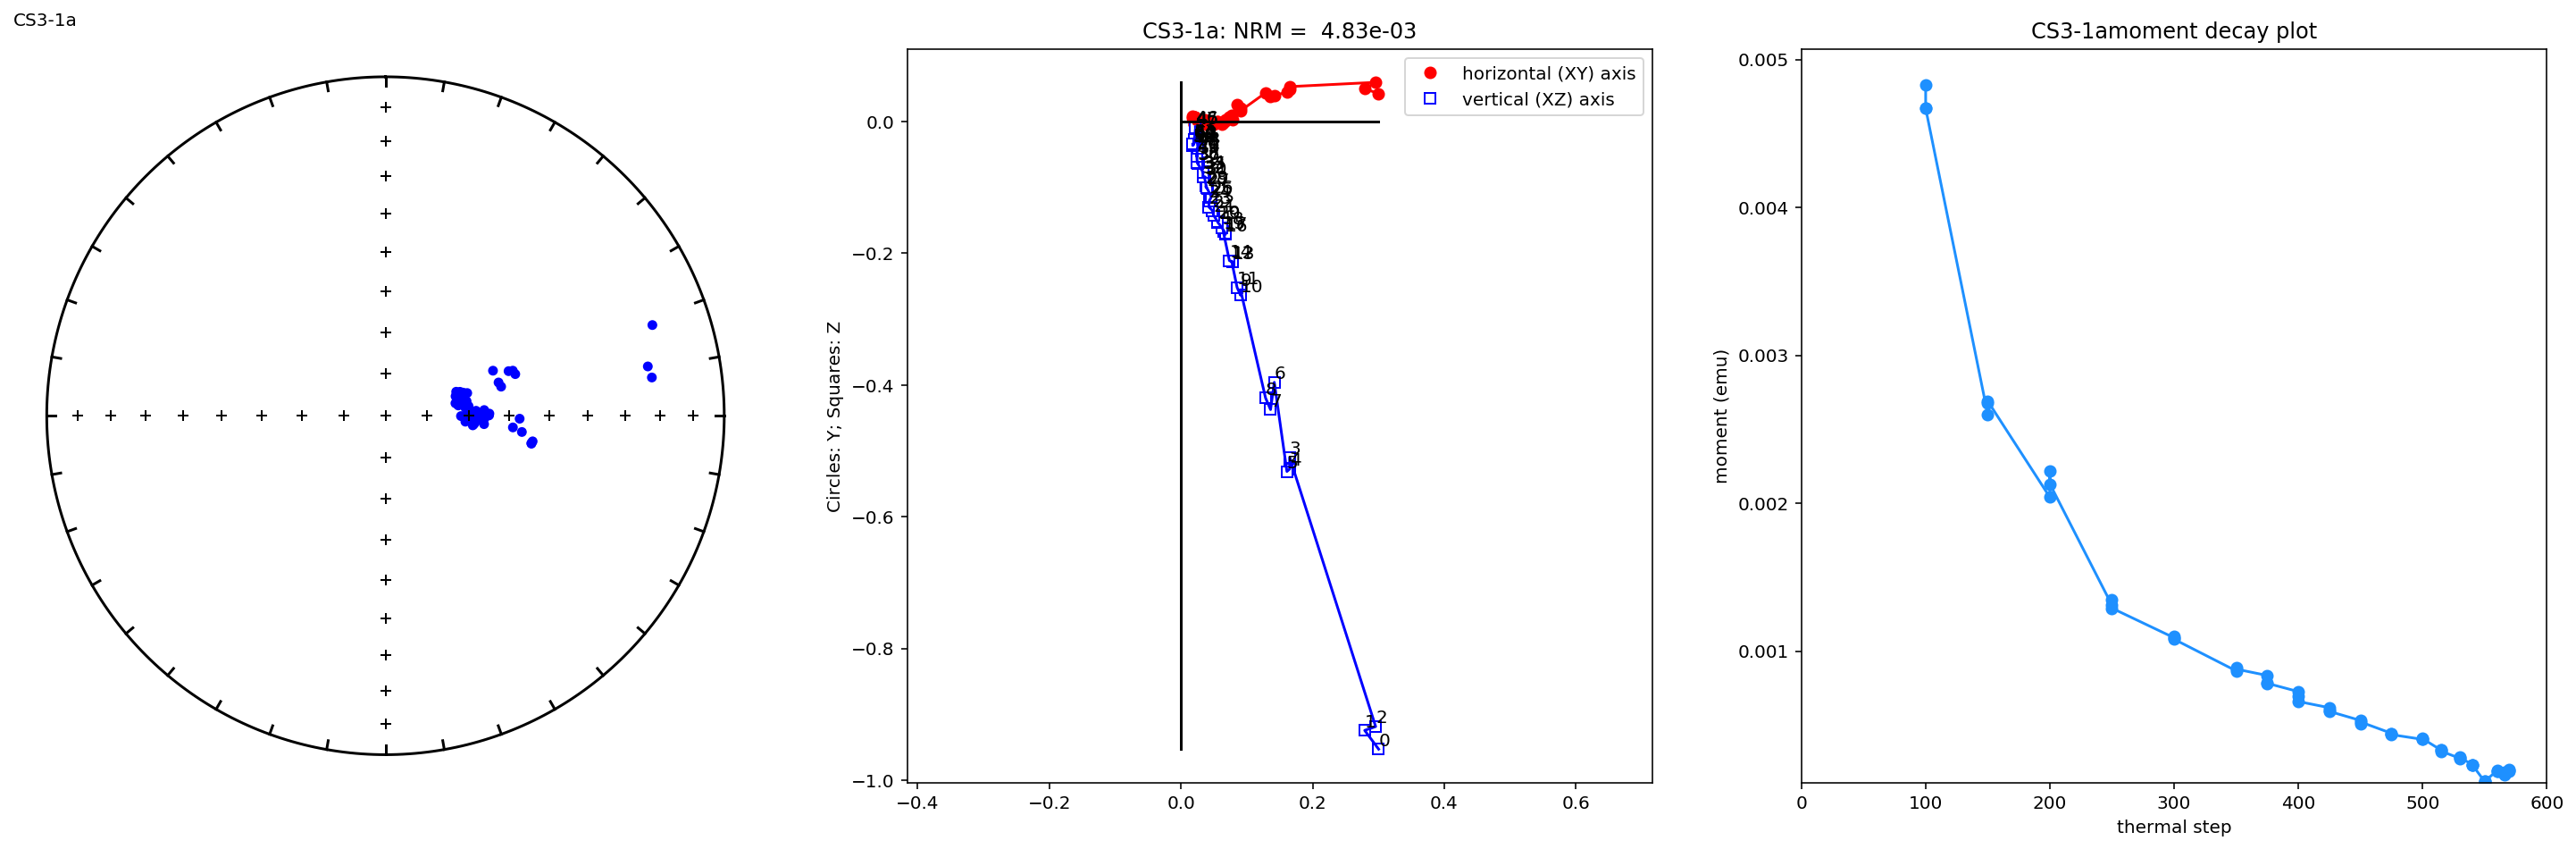

In [80]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS3_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS3-1a')
fig.add_subplot(132)
plot_zij(CS3_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS3-1a')
fig.add_subplot(133)
CS3_1a_OPRM_step_all, CS3_1a_OPRM_Ms_all  = plot_mag(CS3_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS3-1a')
plt.subplots_adjust(wspace = 0.2 )

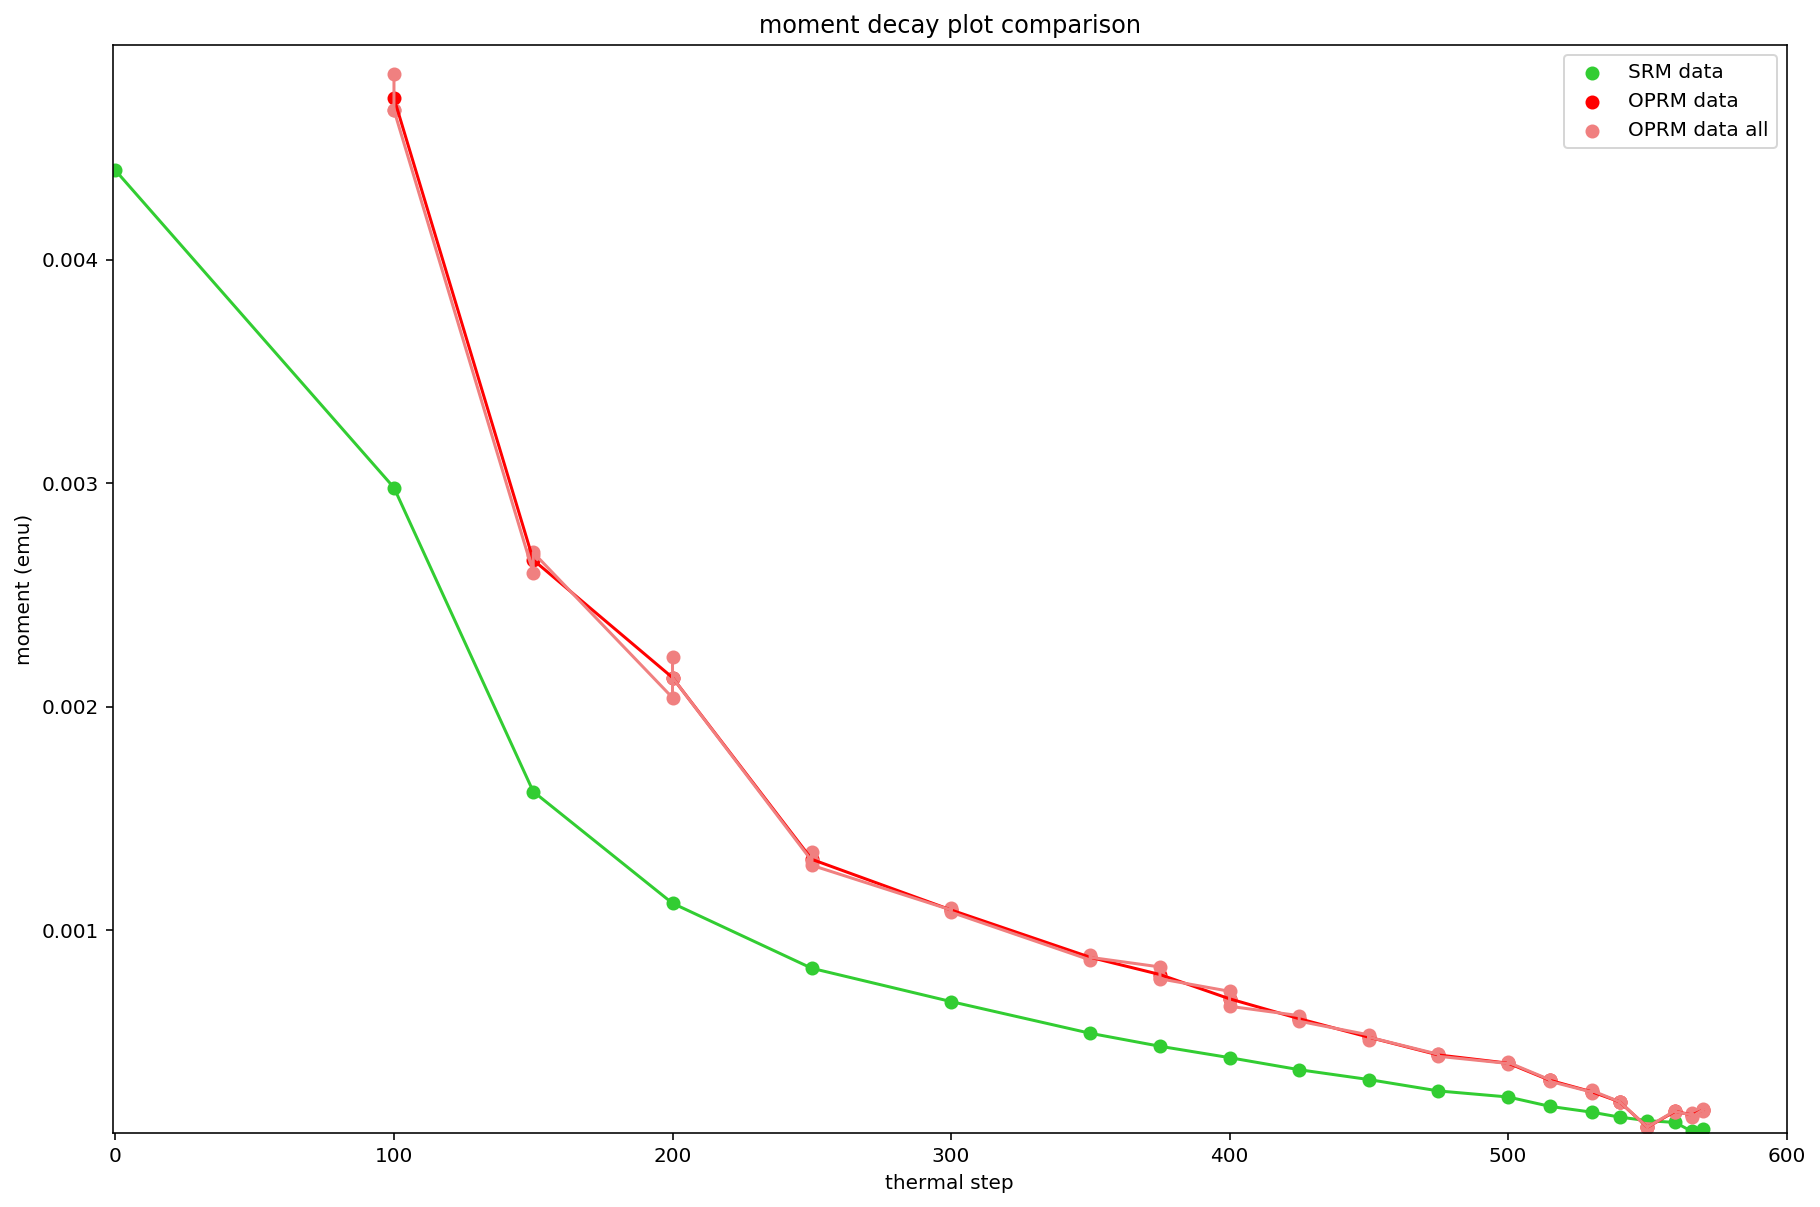

In [81]:
moment_comparison(CS3_1a_SRM_step, CS3_1a_SRM_Ms, CS3_1a_OPRM_step, CS3_1a_OPRM_Ms, CS3_1a_OPRM_step_all, CS3_1a_OPRM_Ms_all, 'CS3-1a')

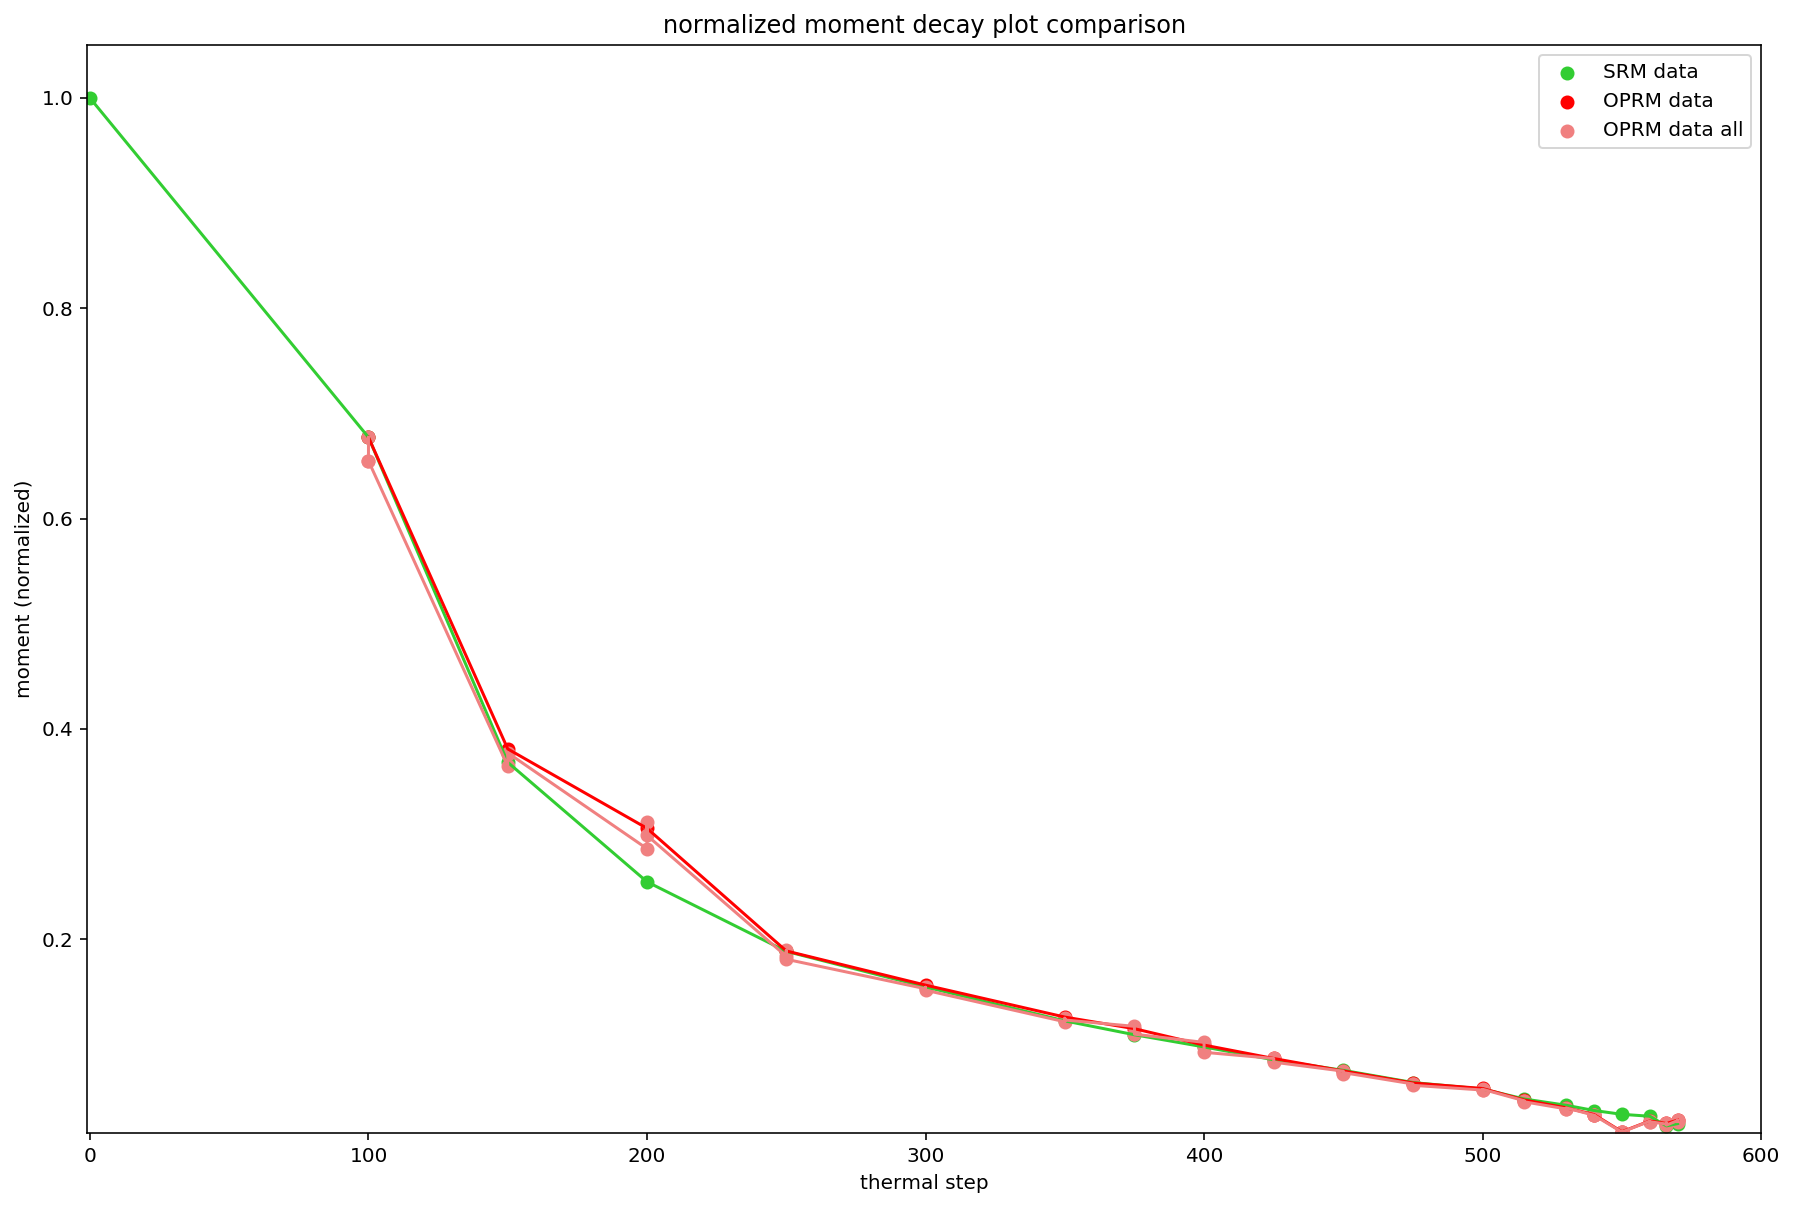

In [110]:
moment_comparison_normalized(CS3_1a_SRM_step, CS3_1a_SRM_Ms, CS3_1a_OPRM_step, CS3_1a_OPRM_Ms, CS3_1a_OPRM_step_all, CS3_1a_OPRM_Ms_all, 'CS3-1a')

### CS7-1a

In [83]:
CS7_1a_SRM_file = read_SRM_file('SRM_data/CS7-1a')
CS7_1a_SRM_file = CS7_1a_SRM_file.drop([8,10,26,28])
CS7_1a_OPRM_file = read_OPRM_file('OPRM_data/CS7-1a.csv')
CS7_1a_OPRM_file_mean = average_measurements(CS7_1a_OPRM_file)

In [84]:
display(CS7_1a_SRM_file.head())
display(CS7_1a_OPRM_file_mean.head())

step      dec      inc       Ms blank quality
0   NRM 6.56E+01 7.07E+01 9.90E-05             g
1  100  5.25E+01 7.21E+01 7.92E-05             g
2  150  4.63E+01 7.20E+01 6.52E-05             g
3  200  3.71E+01 7.12E+01 5.38E-05             g
4  250  1.83E+01 6.91E+01 4.50E-05             g

step      dec      inc       Ms blank quality
0  450 3.59E+02 6.47E+01 3.14E-05             g
1  475 3.56E+02 6.32E+01 2.81E-05             g
2  500 3.55E+02 6.22E+01 2.17E-05             g
3  515 3.54E+02 5.91E+01 2.09E-05             g
4  530 3.60E+02 5.92E+01 1.89E-05             g

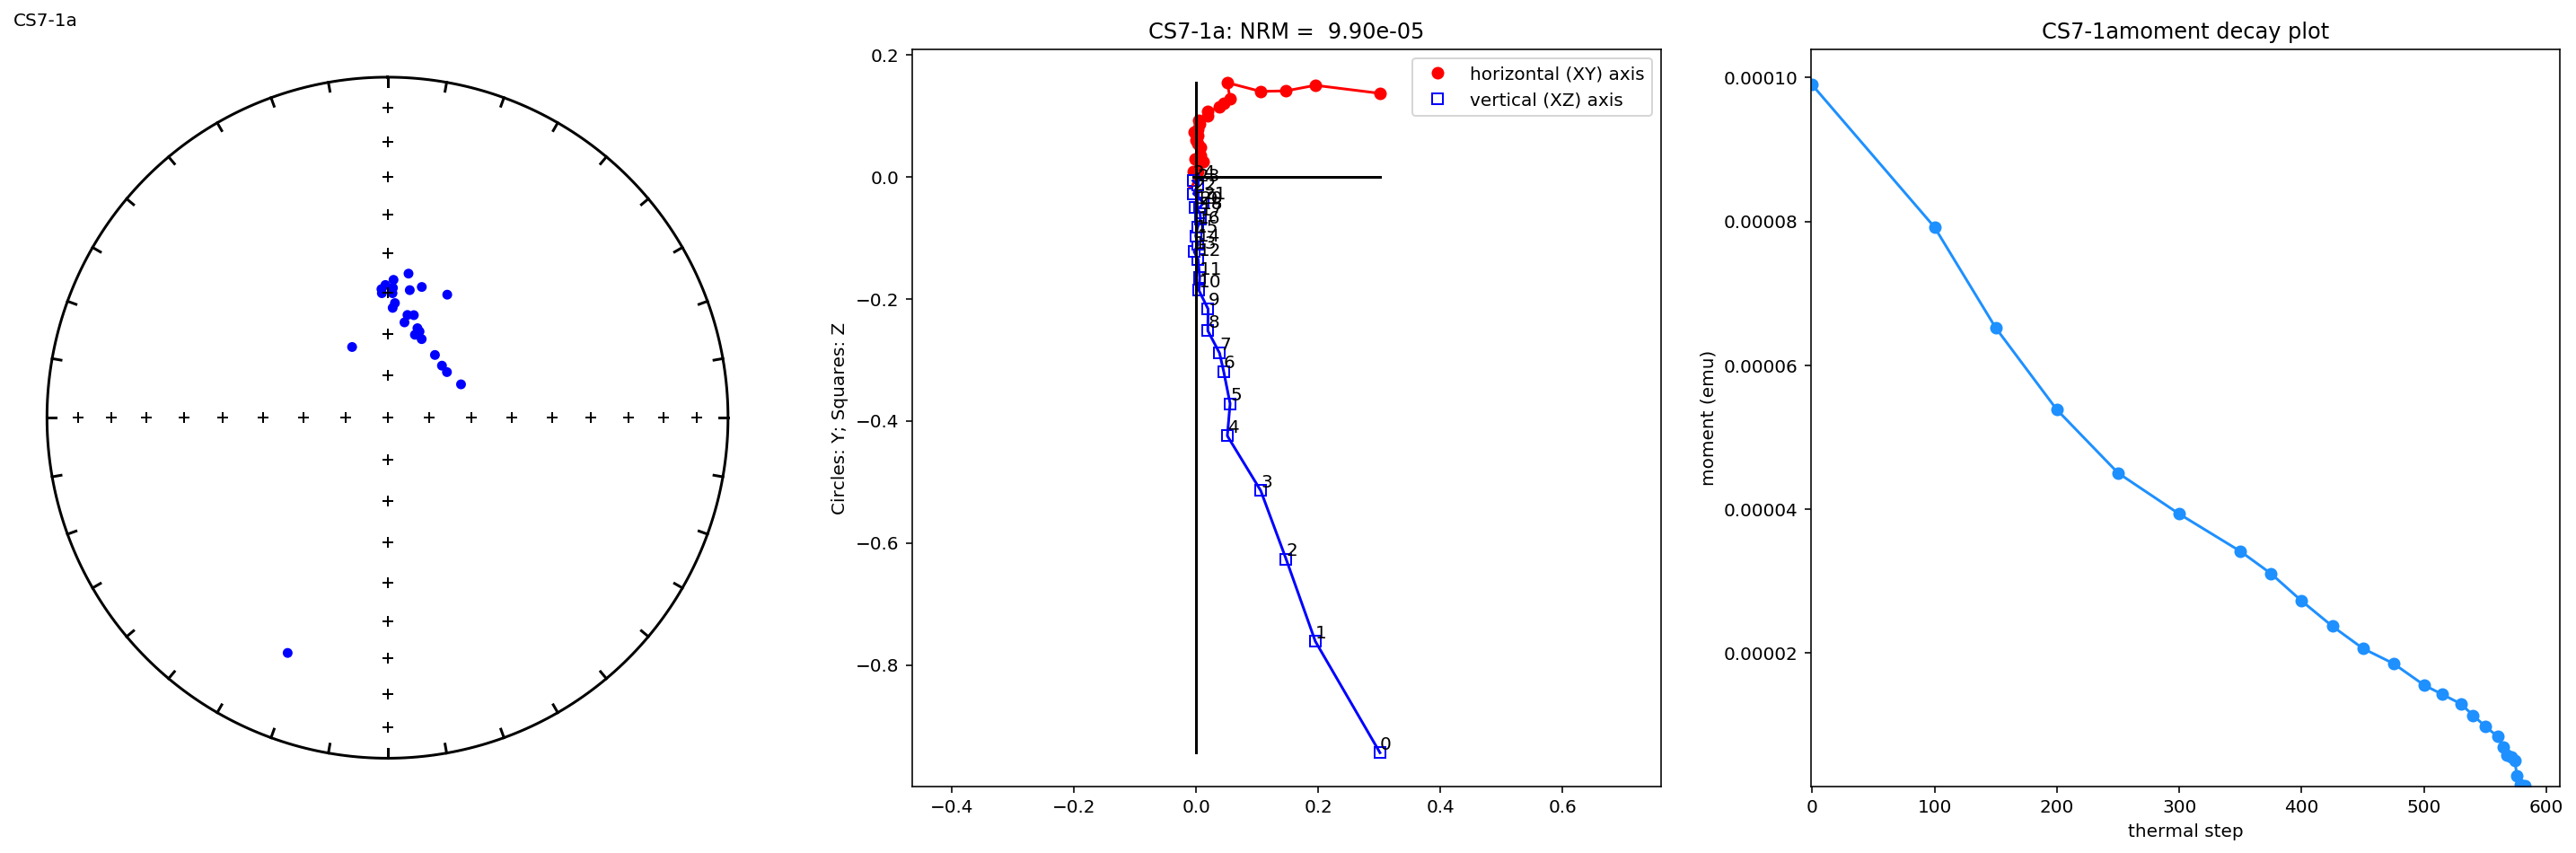

In [85]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS7_1a_SRM_file[['dec','inc']].values.tolist(), 'CS7-1a')
fig.add_subplot(132)
plot_zij(CS7_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS7-1a')
fig.add_subplot(133)
CS7_1a_SRM_step, CS7_1a_SRM_Ms = plot_mag(CS7_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS7-1a')
plt.subplots_adjust(wspace = 0.2 )

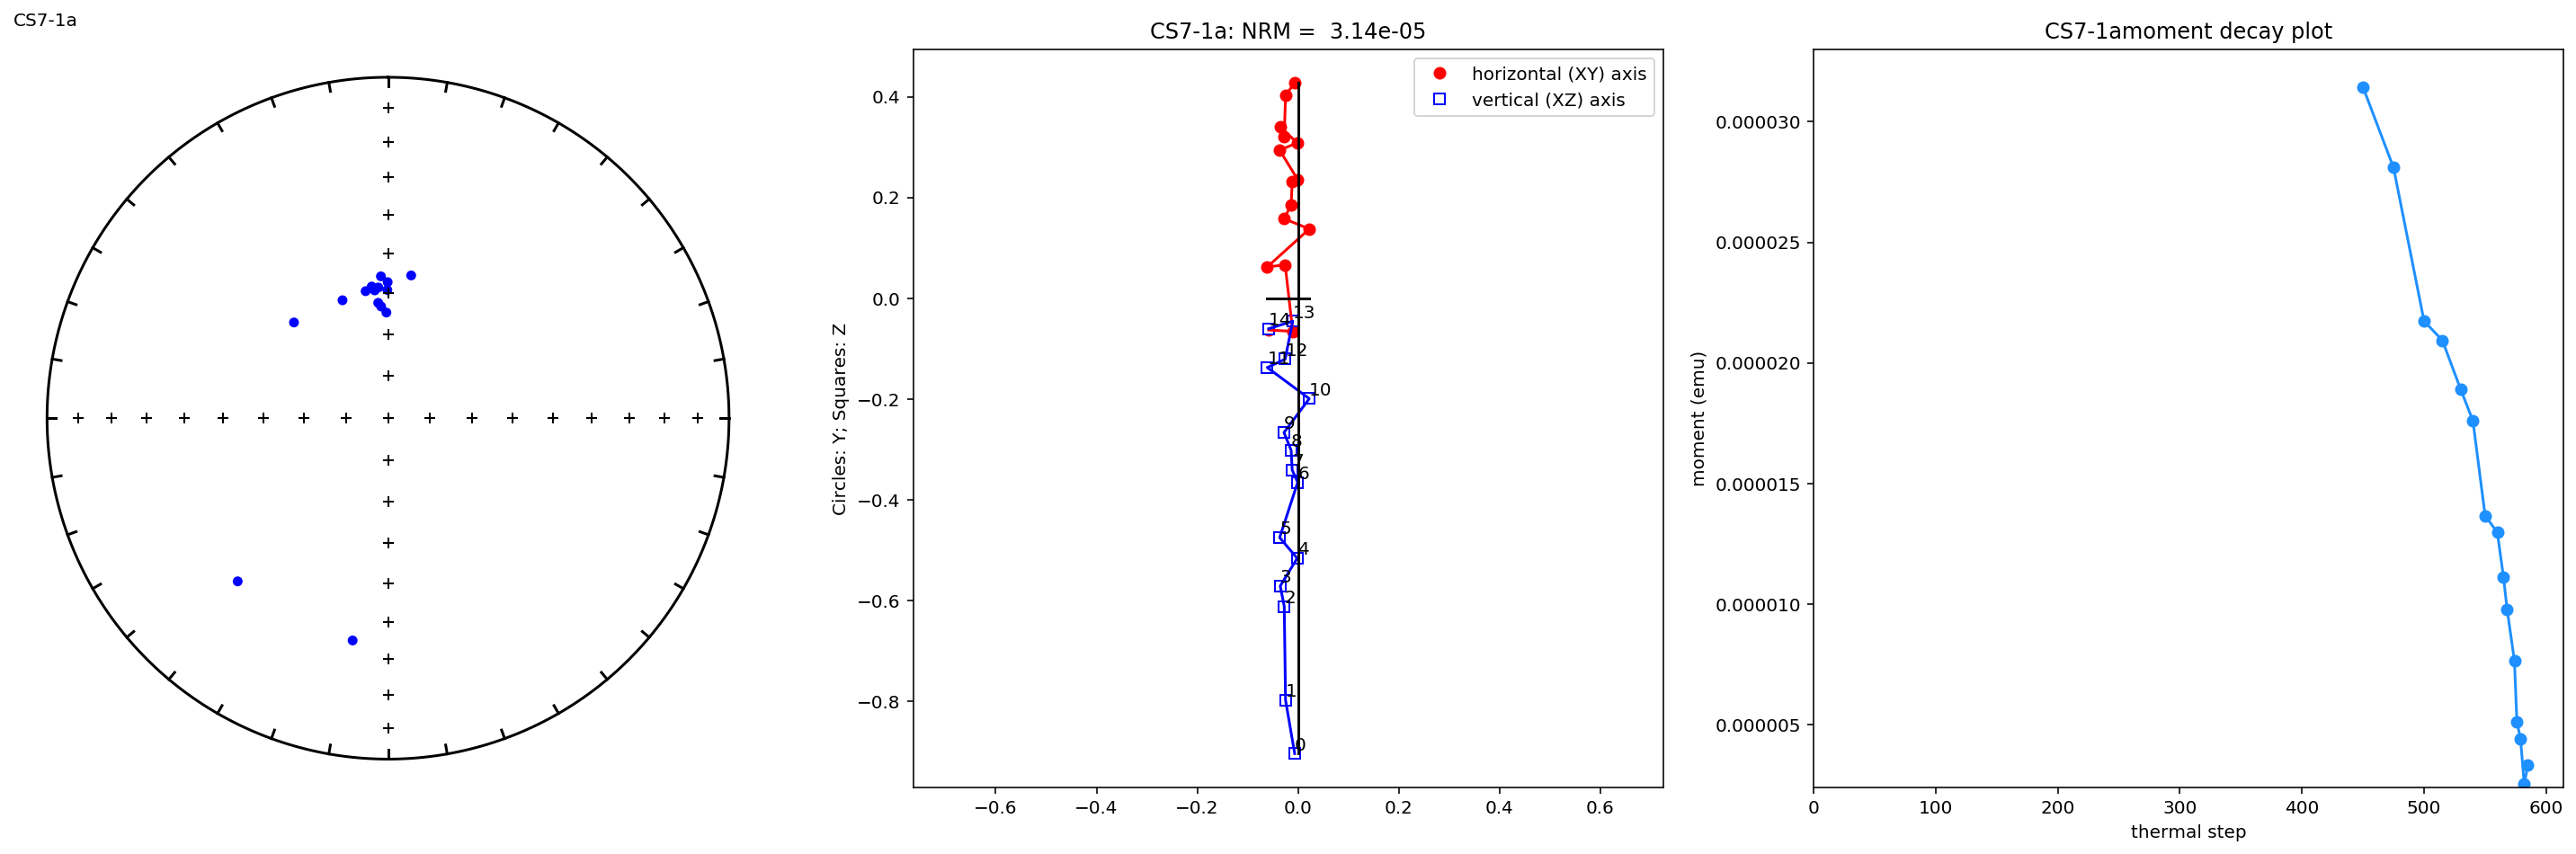

In [86]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS7_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS7-1a')
fig.add_subplot(132)
plot_zij(CS7_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS7-1a')
fig.add_subplot(133)
CS7_1a_OPRM_step, CS7_1a_OPRM_Ms = plot_mag(CS7_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS7-1a')
plt.subplots_adjust(wspace = 0.2 )

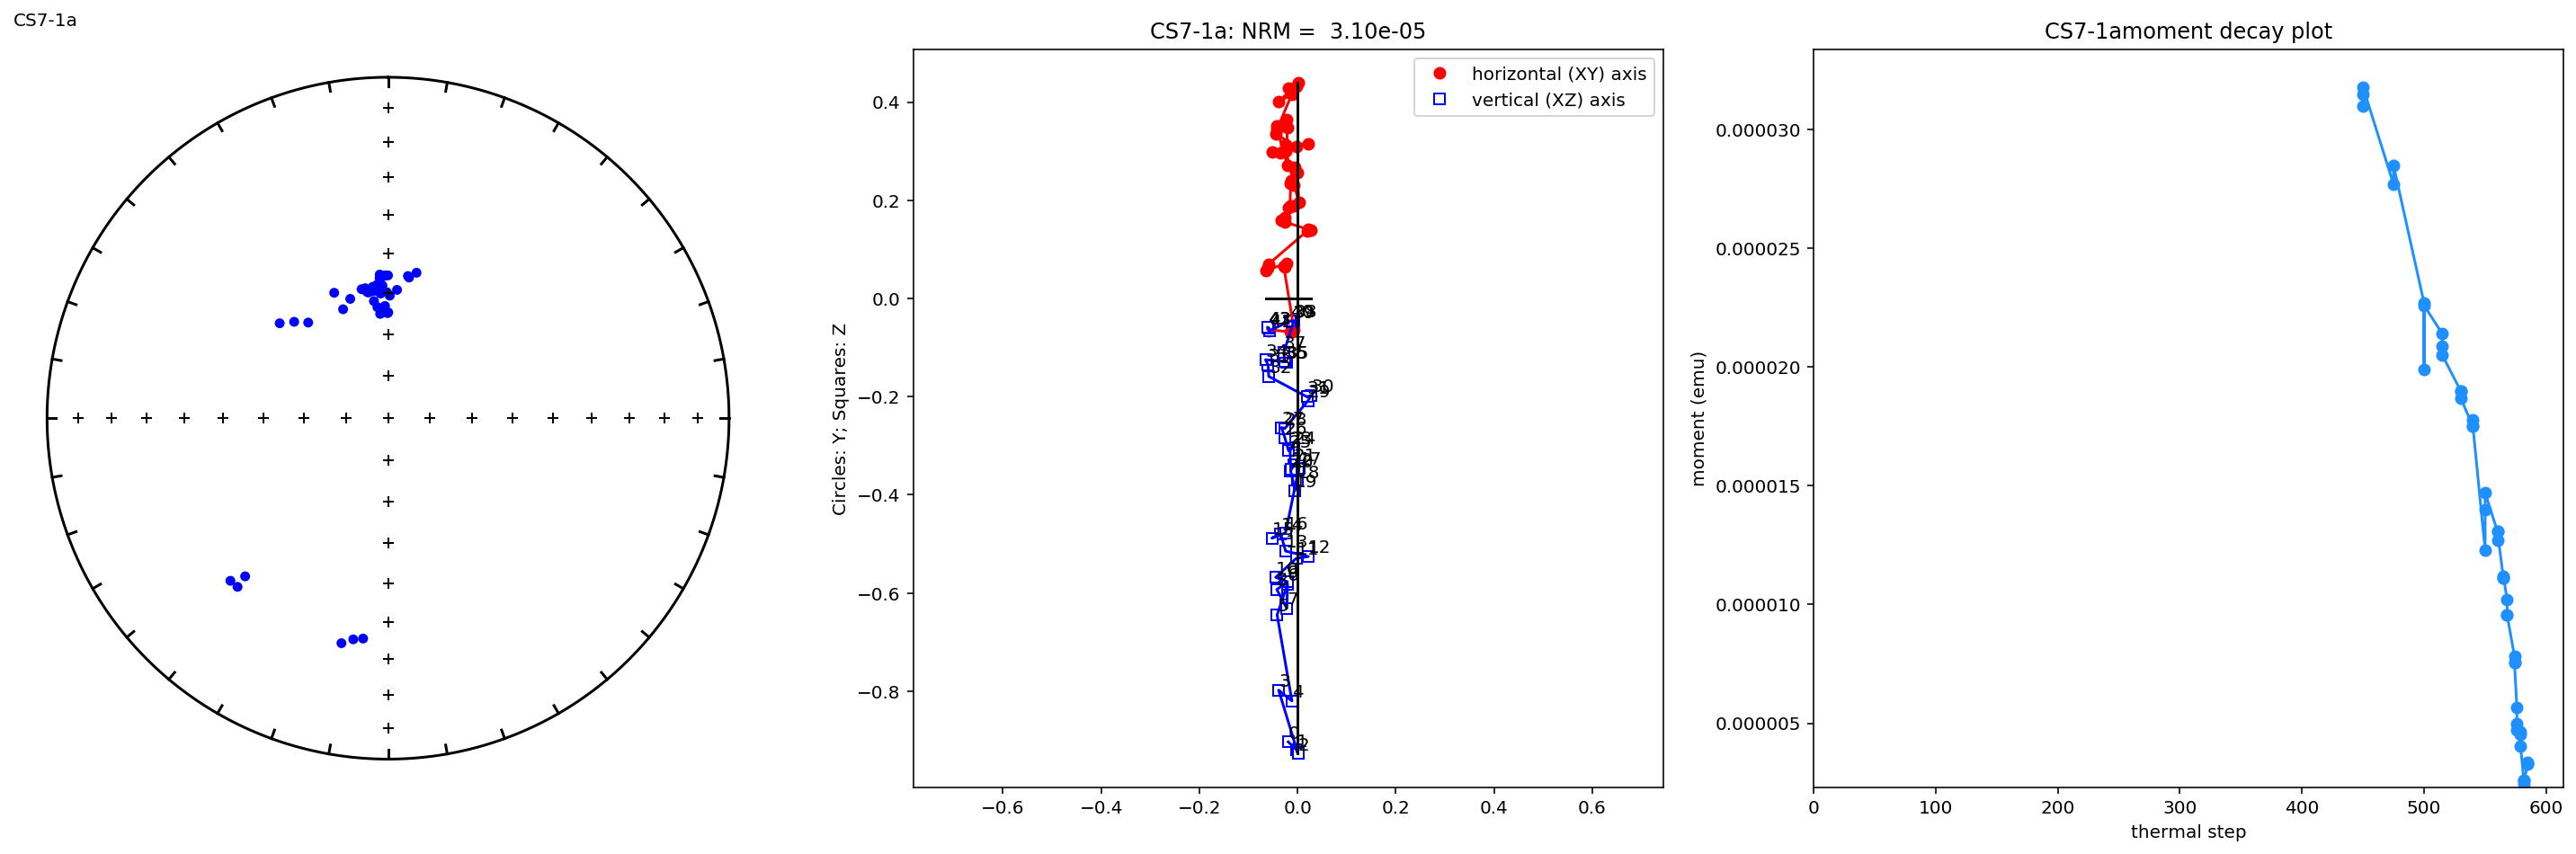

In [87]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS7_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS7-1a')
fig.add_subplot(132)
plot_zij(CS7_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS7-1a')
fig.add_subplot(133)
CS7_1a_OPRM_step_all, CS7_1a_OPRM_Ms_all  = plot_mag(CS7_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS7-1a')
plt.subplots_adjust(wspace = 0.2 )

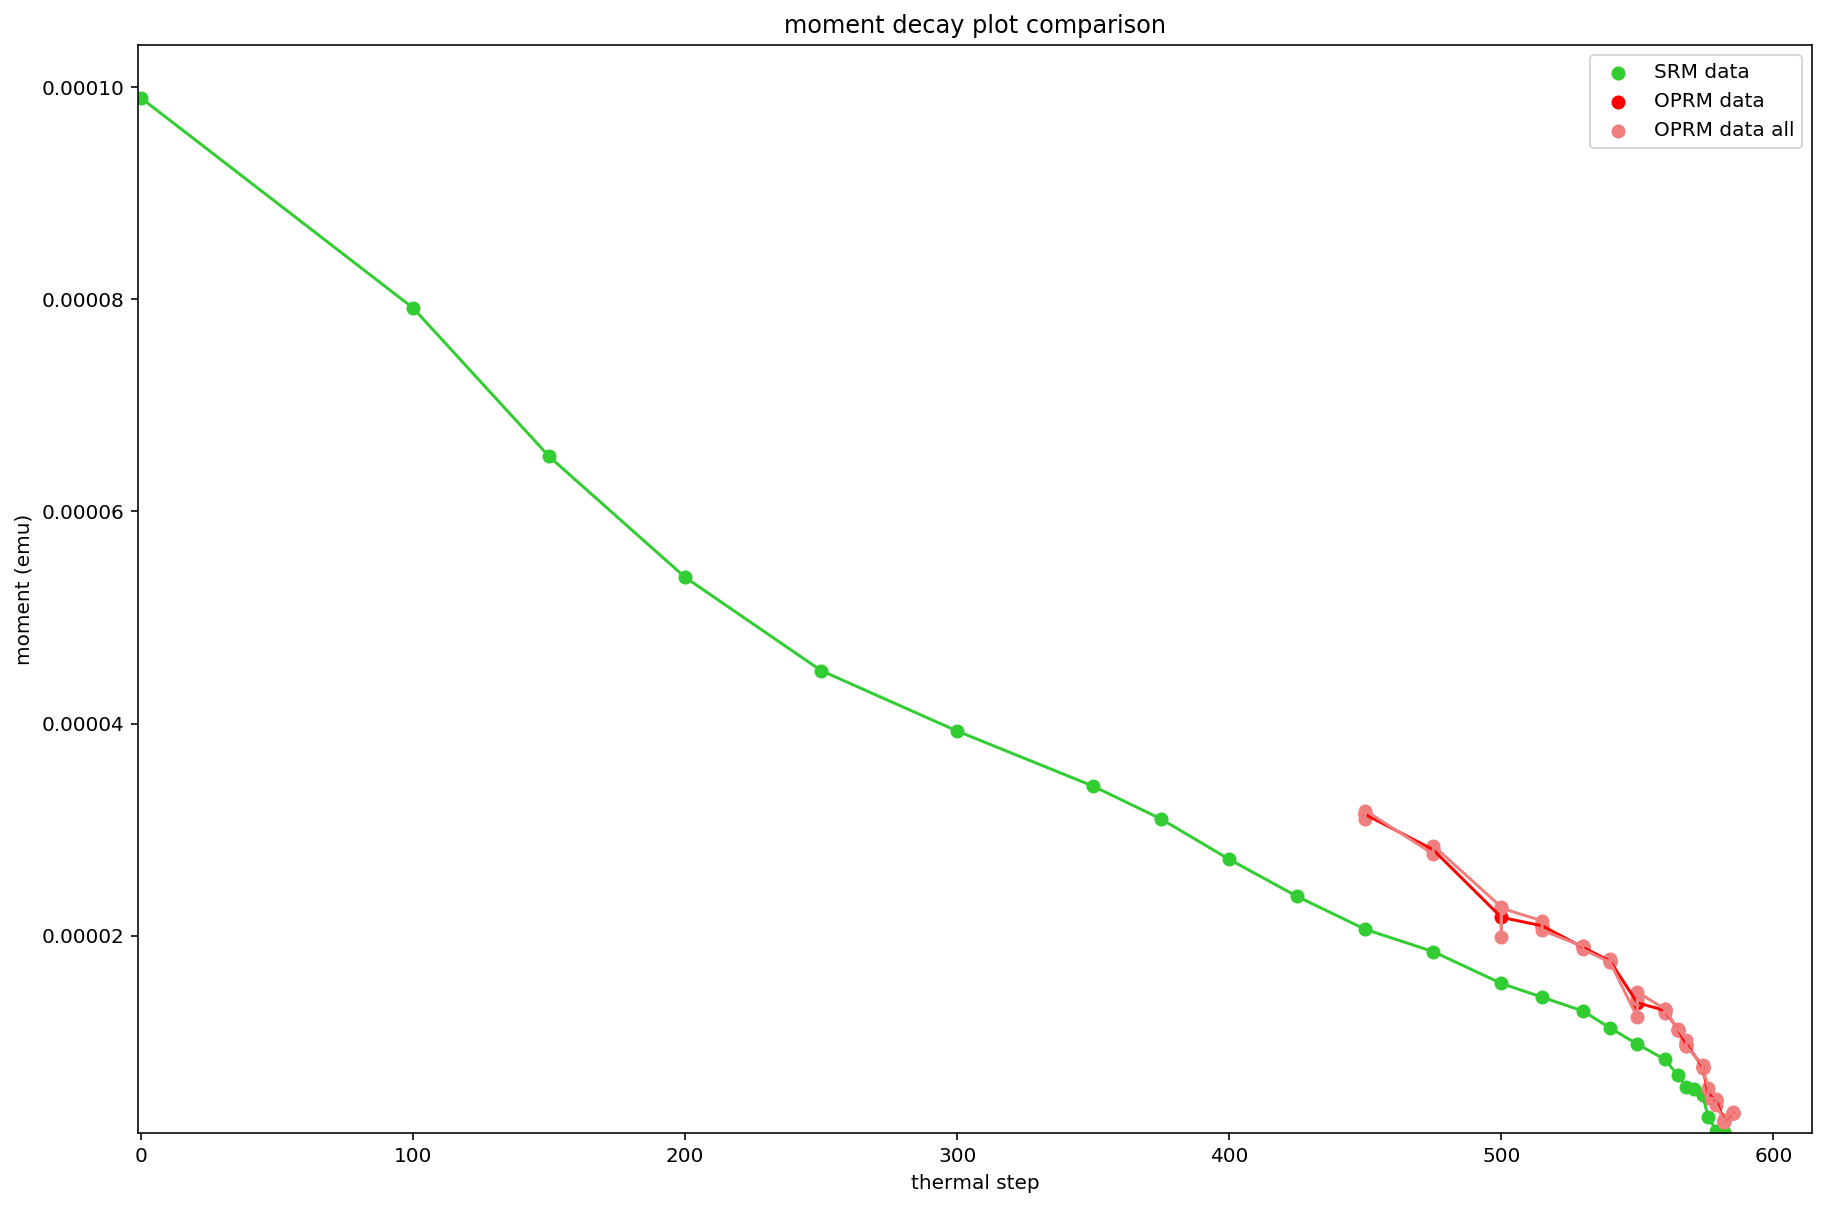

In [88]:
moment_comparison(CS7_1a_SRM_step, CS7_1a_SRM_Ms, CS7_1a_OPRM_step, CS7_1a_OPRM_Ms, CS7_1a_OPRM_step_all, CS7_1a_OPRM_Ms_all, 'CS7-1a')

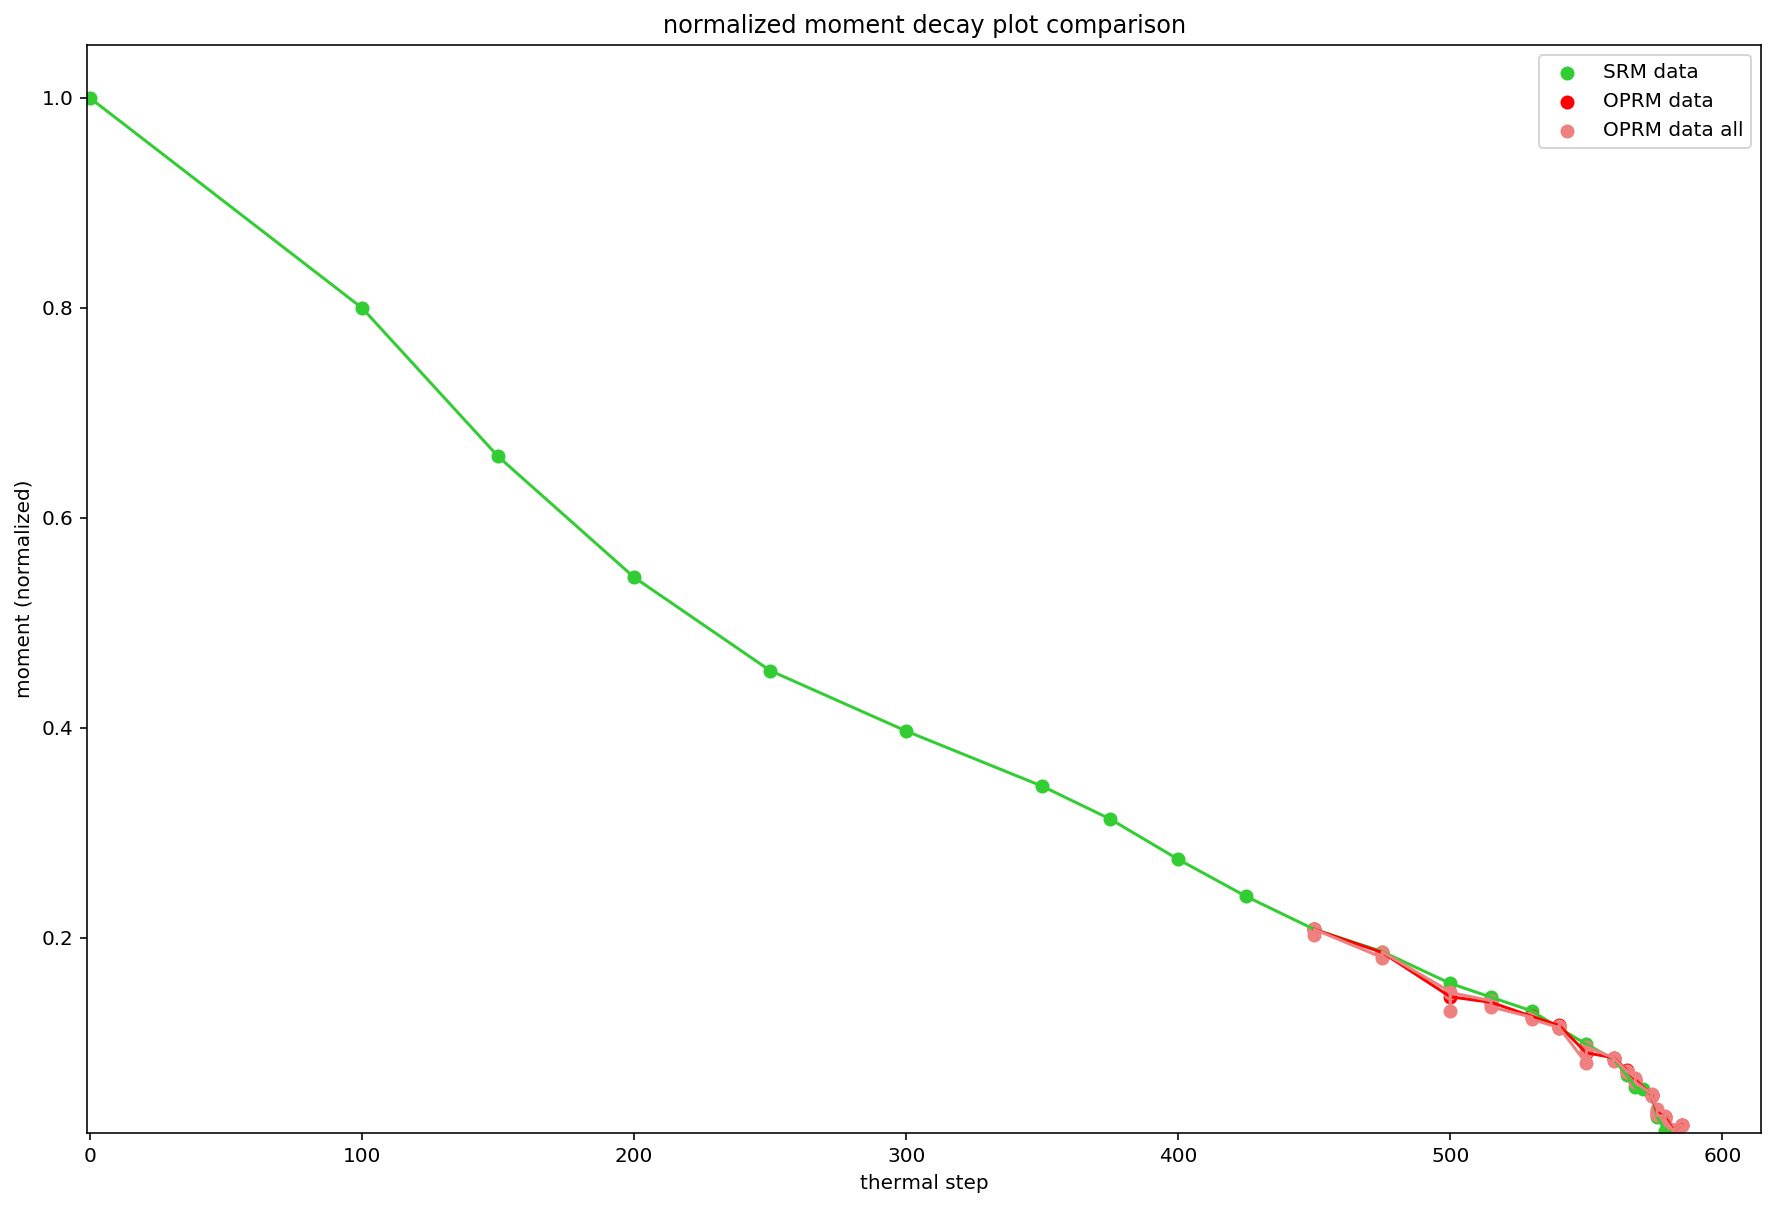

In [111]:
moment_comparison_normalized(CS7_1a_SRM_step, CS7_1a_SRM_Ms, CS7_1a_OPRM_step, CS7_1a_OPRM_Ms, CS7_1a_OPRM_step_all, CS7_1a_OPRM_Ms_all, 'CS7-1a')

### CS8-1a

In [90]:
CS8_1a_SRM_file = read_SRM_file('SRM_data/CS8-1a')
CS8_1a_SRM_file = CS8_1a_SRM_file.drop([8,10,21])
CS8_1a_OPRM_file = read_OPRM_file('OPRM_data/CS8-1a.csv')
CS8_1a_OPRM_file_mean = average_measurements(CS8_1a_OPRM_file)

In [91]:
display(CS8_1a_SRM_file.head())
display(CS8_1a_OPRM_file_mean.head())

step      dec      inc       Ms blank quality
0   NRM 2.14E+01 6.14E+01 3.02E-05             g
1  100  1.36E+01 5.98E+01 2.95E-05             g
2  150  1.42E+01 5.86E+01 2.90E-05             g
3  200  1.32E+01 5.81E+01 2.88E-05             g
4  250  7.80E+00 5.51E+01 2.92E-05             g

step      dec      inc       Ms blank quality
0  450 2.04E+01 5.02E+01 3.52E-05             g
1  475 1.83E+01 4.85E+01 3.24E-05             g
2  500 1.18E+01 4.79E+01 3.01E-05             g
3  515 7.89E+00 4.75E+01 2.80E-05             g
4  530 1.06E+01 4.57E+01 2.76E-05             g

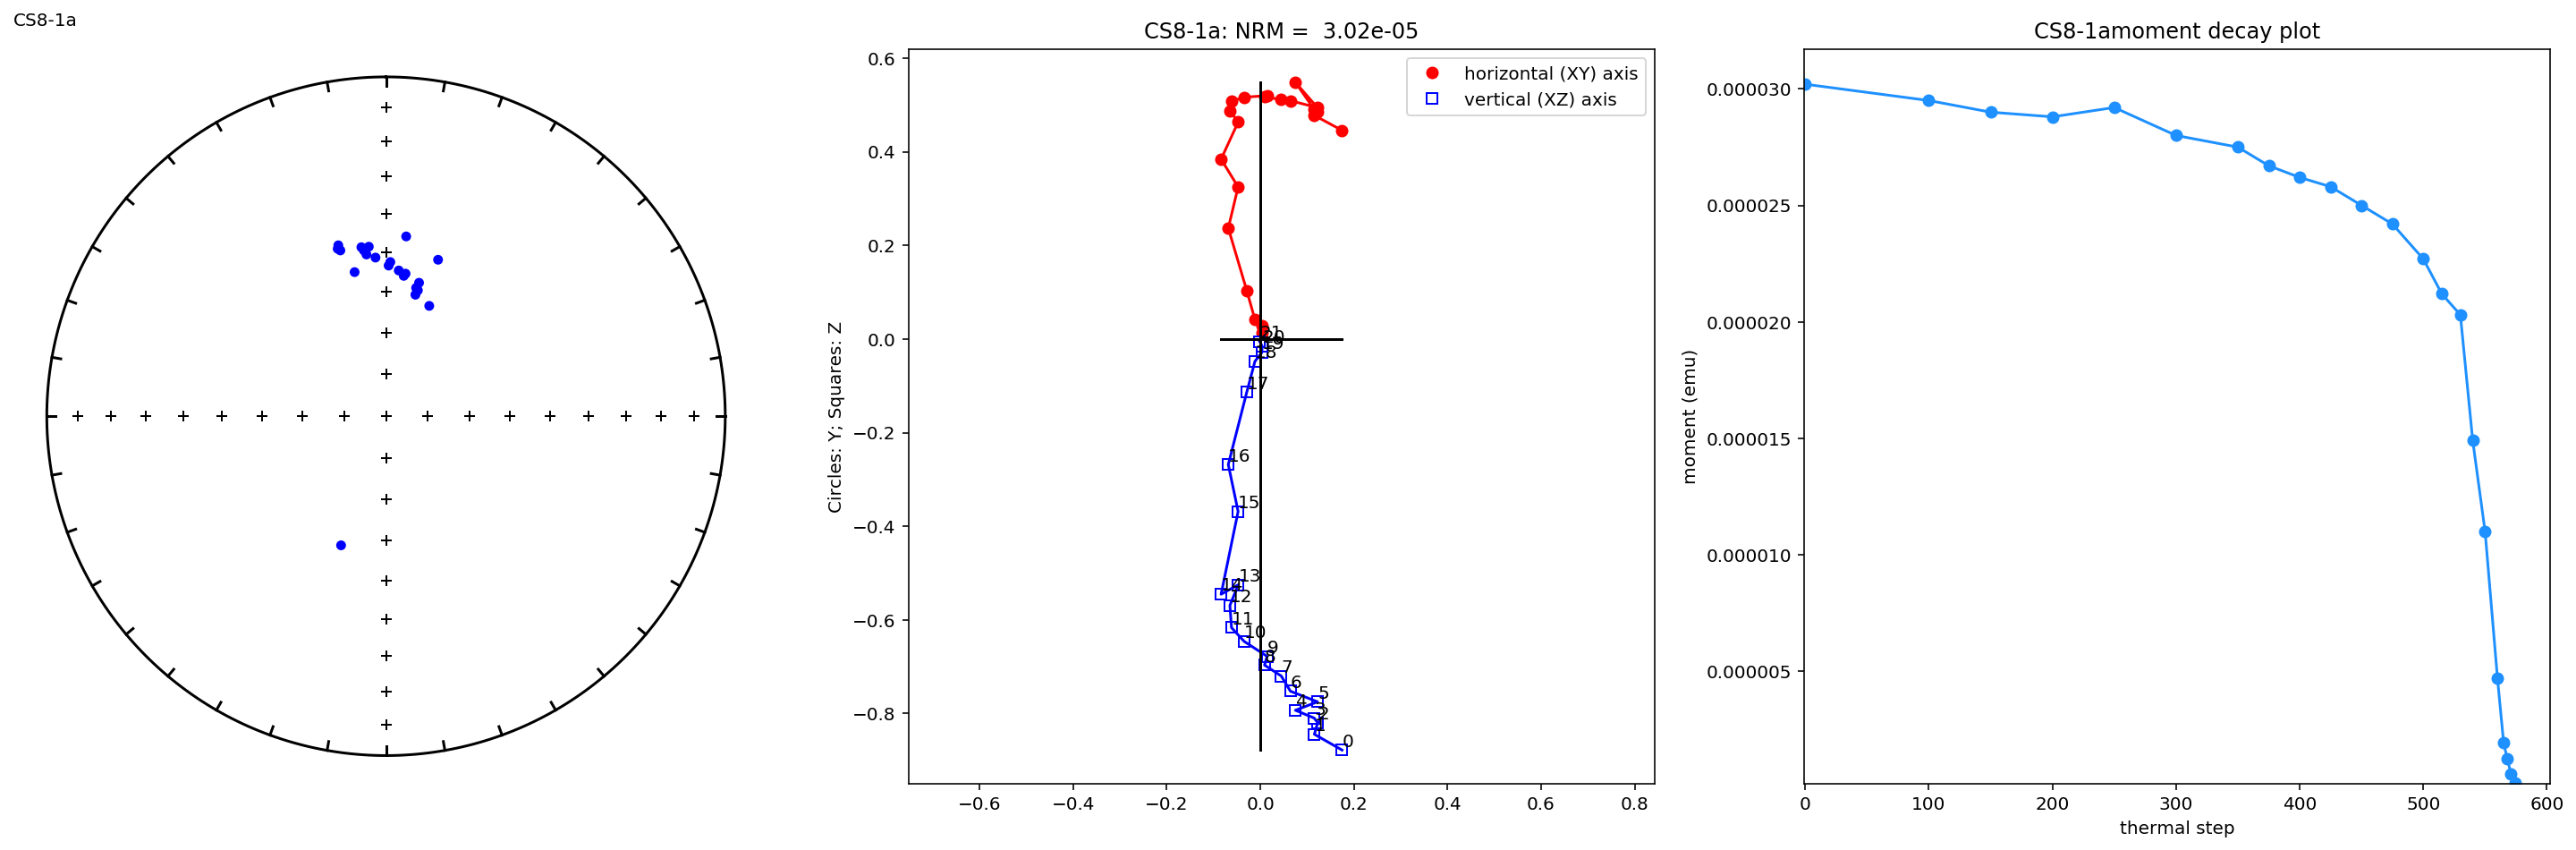

In [92]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS8_1a_SRM_file[['dec','inc']].values.tolist(), 'CS8-1a')
fig.add_subplot(132)
plot_zij(CS8_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS8-1a')
fig.add_subplot(133)
CS8_1a_SRM_step, CS8_1a_SRM_Ms = plot_mag(CS8_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS8-1a')
plt.subplots_adjust(wspace = 0.2 )

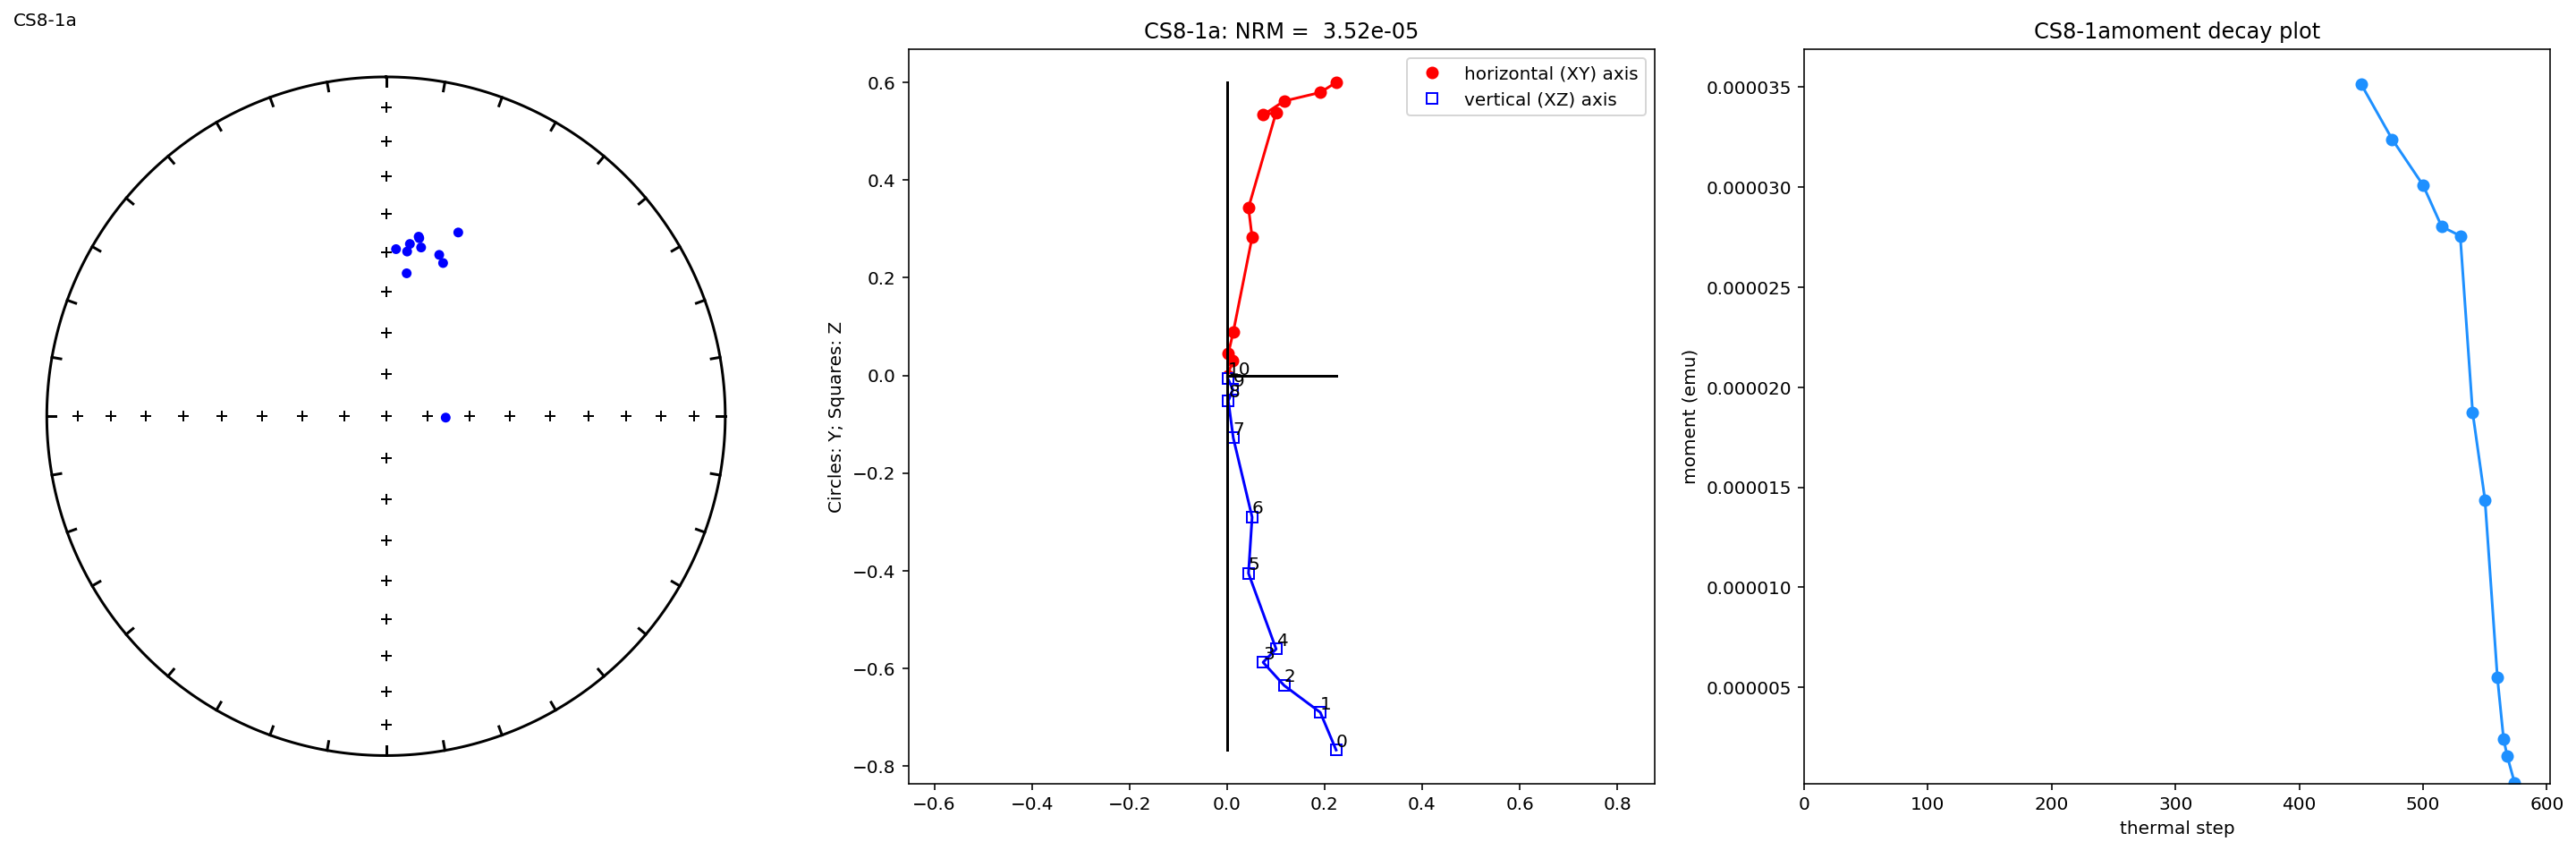

In [93]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS8_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS8-1a')
fig.add_subplot(132)
plot_zij(CS8_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS8-1a')
fig.add_subplot(133)
CS8_1a_OPRM_step, CS8_1a_OPRM_Ms  = plot_mag(CS8_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS8-1a')
plt.subplots_adjust(wspace = 0.2 )

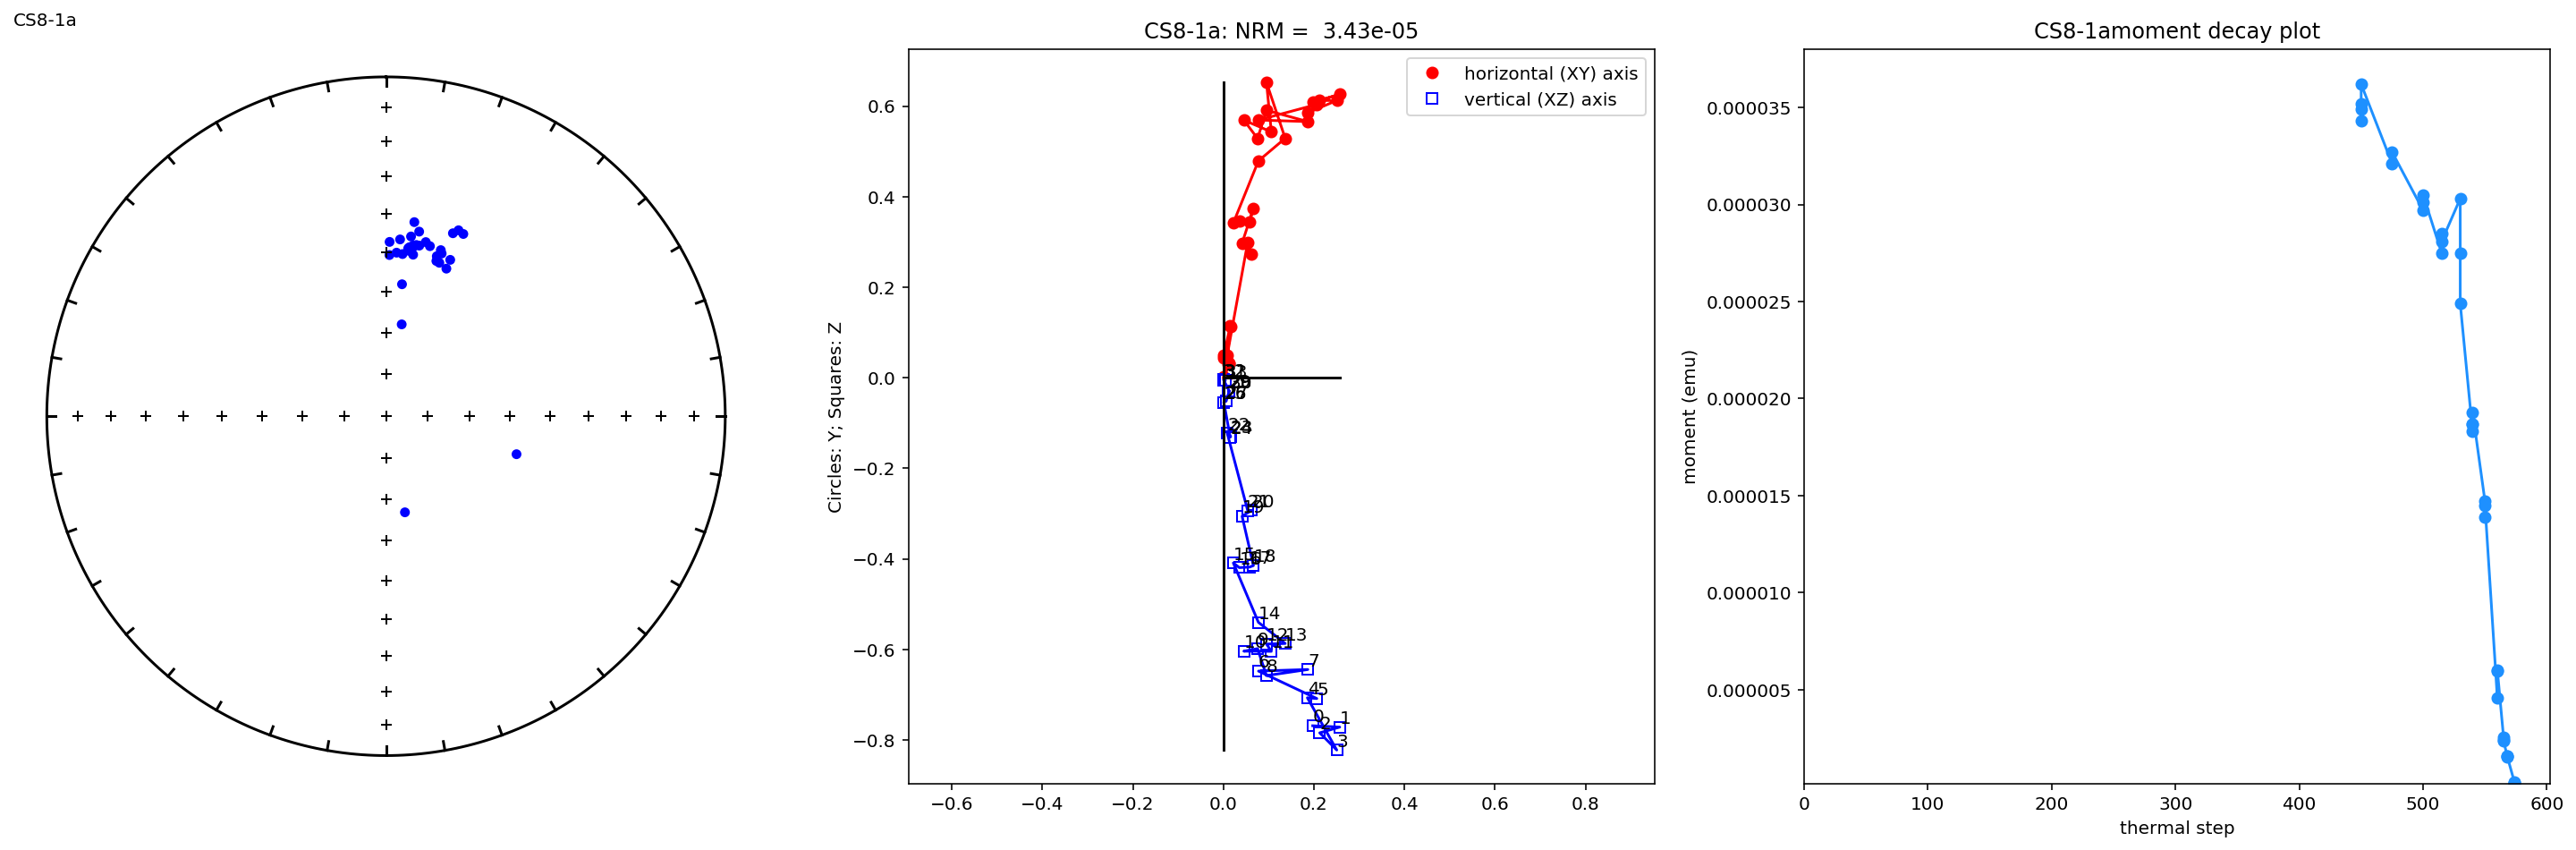

In [94]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS8_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS8-1a')
fig.add_subplot(132)
plot_zij(CS8_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS8-1a')
fig.add_subplot(133)
CS8_1a_OPRM_step_all, CS8_1a_OPRM_Ms_all  = plot_mag(CS8_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS8-1a')
plt.subplots_adjust(wspace = 0.2 )

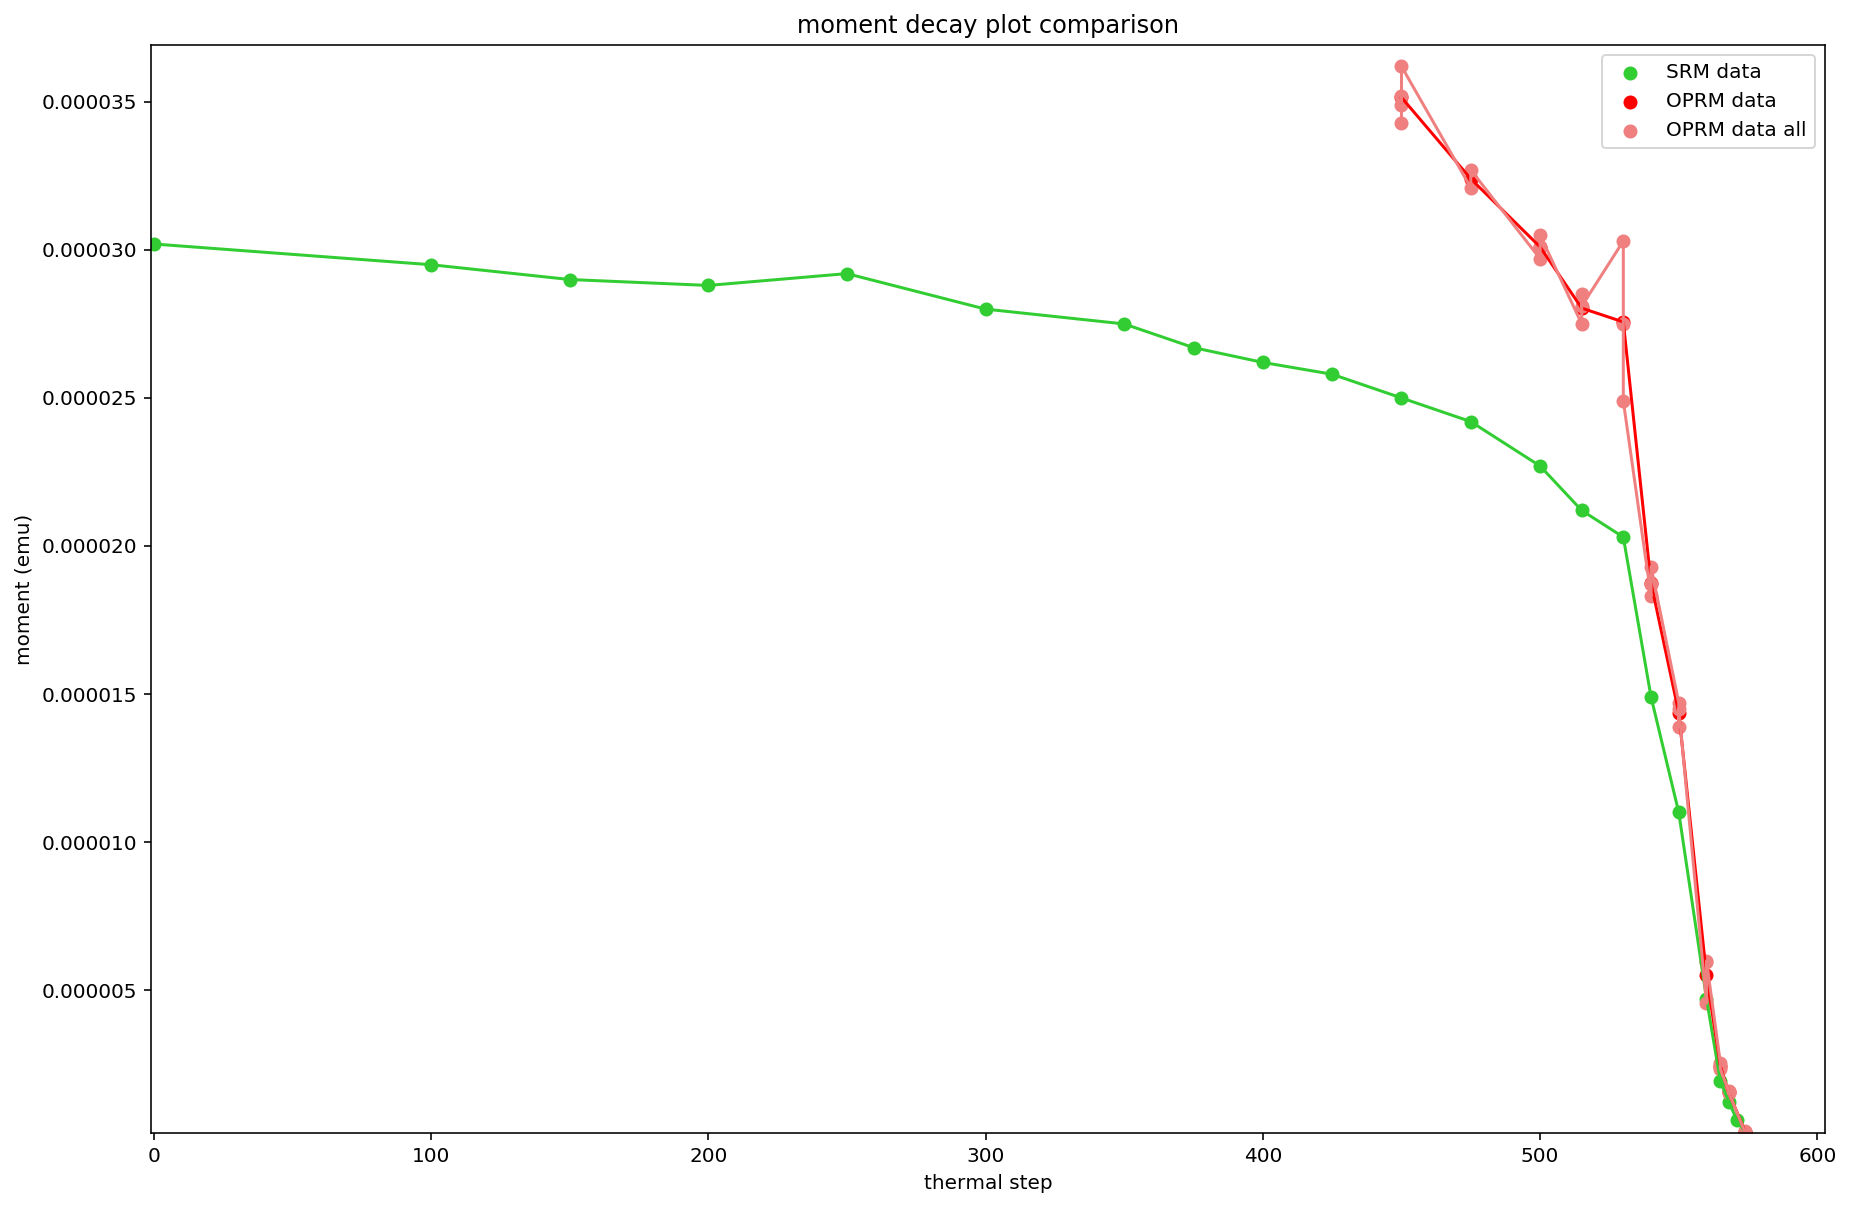

In [95]:
moment_comparison(CS8_1a_SRM_step, CS8_1a_SRM_Ms, CS8_1a_OPRM_step, CS8_1a_OPRM_Ms, CS8_1a_OPRM_step_all, CS8_1a_OPRM_Ms_all, 'CS8-1a')

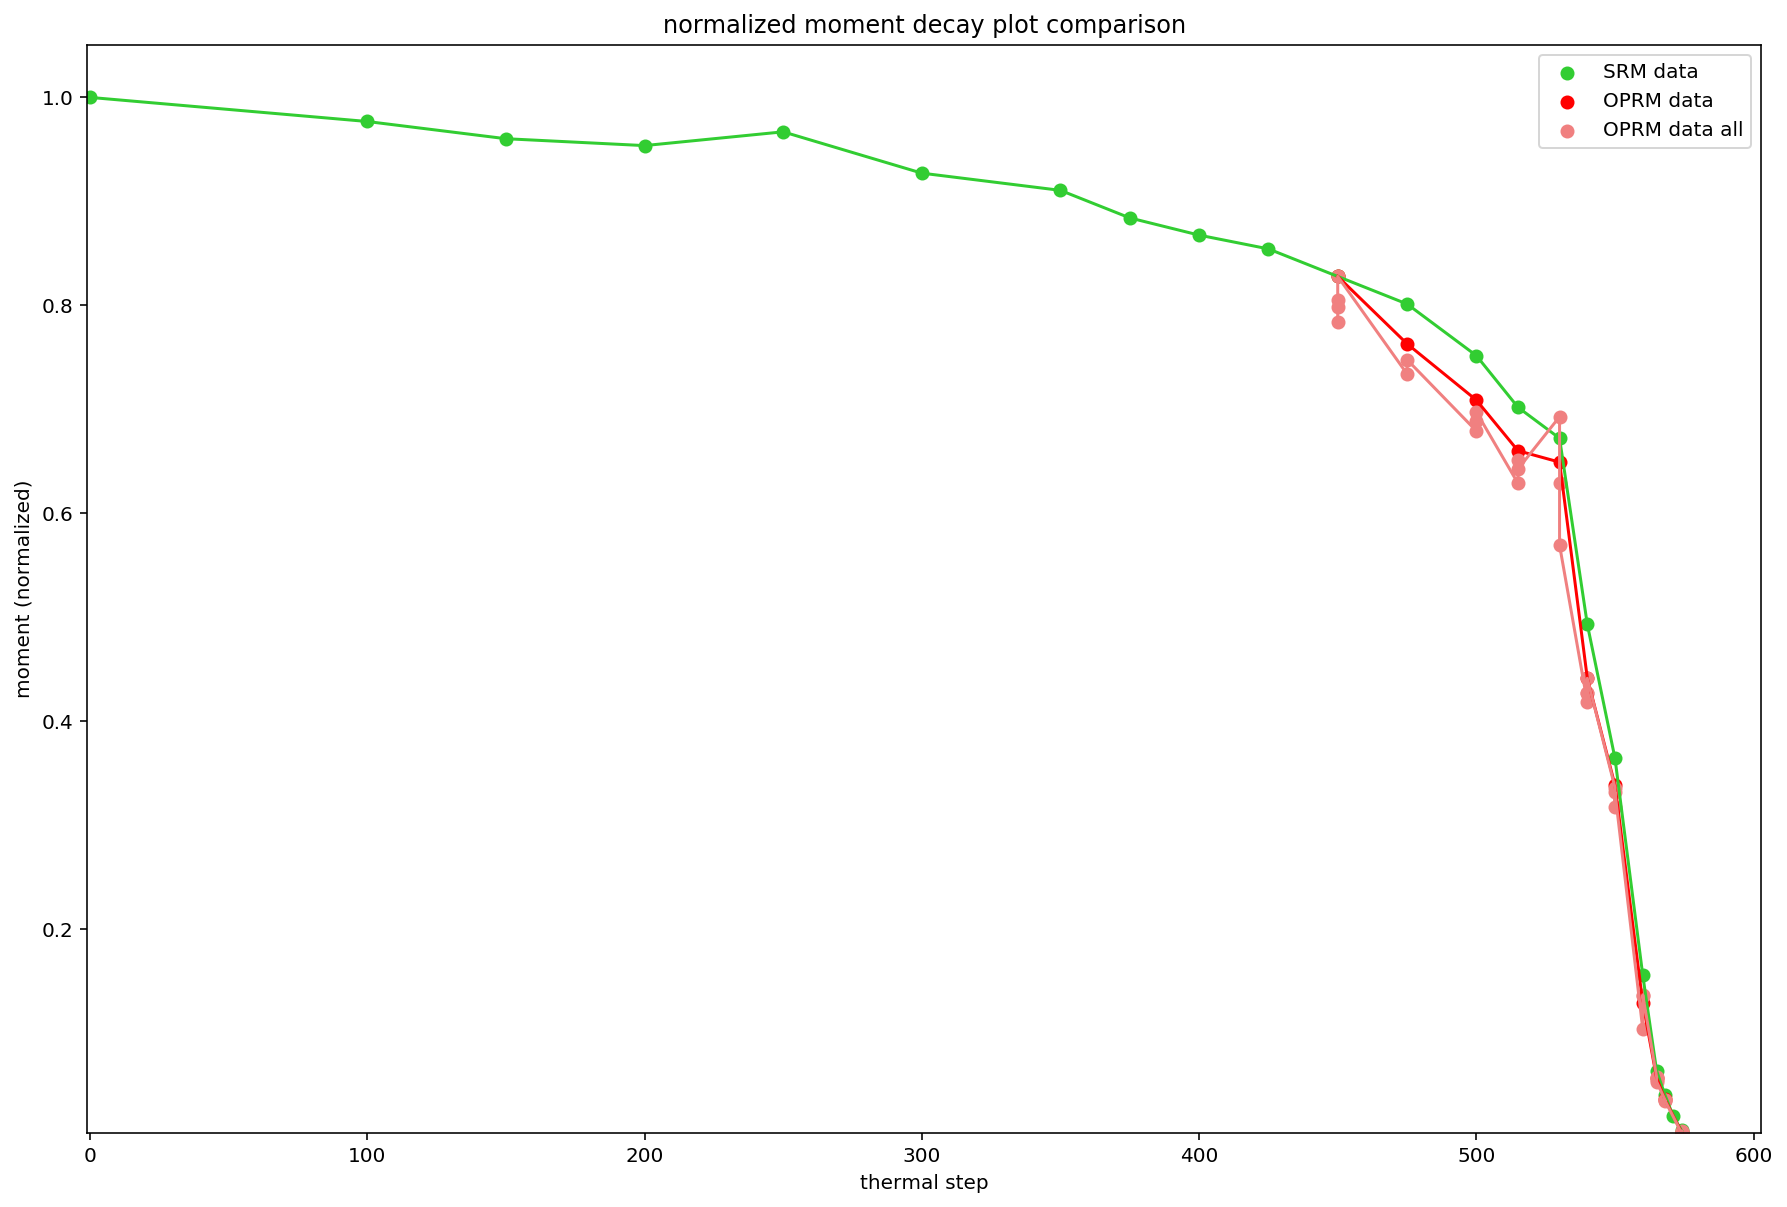

In [112]:
moment_comparison_normalized(CS8_1a_SRM_step, CS8_1a_SRM_Ms, CS8_1a_OPRM_step, CS8_1a_OPRM_Ms, CS8_1a_OPRM_step_all, CS8_1a_OPRM_Ms_all, 'CS8-1a')

### CS9-1a

In [97]:
CS9_1a_SRM_file = read_SRM_file('SRM_data/CS9-1a')
CS9_1a_SRM_file = CS9_1a_SRM_file.drop([8,10,18, 20, 21,23,25,27])
CS9_1a_OPRM_file = read_OPRM_file('OPRM_data/CS9-1a.csv')
CS9_1a_OPRM_file_mean = average_measurements(CS9_1a_OPRM_file)

In [98]:
display(CS9_1a_SRM_file.head())
display(CS9_1a_OPRM_file_mean.head())

step      dec       inc       Ms blank quality
0   NRM 1.54E+02  2.04E+01 2.43E-05             g
1  100  1.12E+02 -1.40E+01 8.95E-06             g
2  150  1.13E+02 -1.36E+01 9.12E-06             g
3  200  1.13E+02 -1.57E+01 8.92E-06             g
4  250  1.08E+02 -1.50E+01 8.48E-06             g

step      dec       inc       Ms blank quality
0  450 9.89E+01 -1.92E+01 9.57E-06             g
1  475 9.14E+01 -1.82E+01 8.38E-06             g
2  500 9.68E+01 -1.74E+01 7.82E-06             g
3  515 7.89E+01 -1.44E+01 6.65E-06             g
4  530 9.35E+01 -1.52E+01 7.59E-06             g

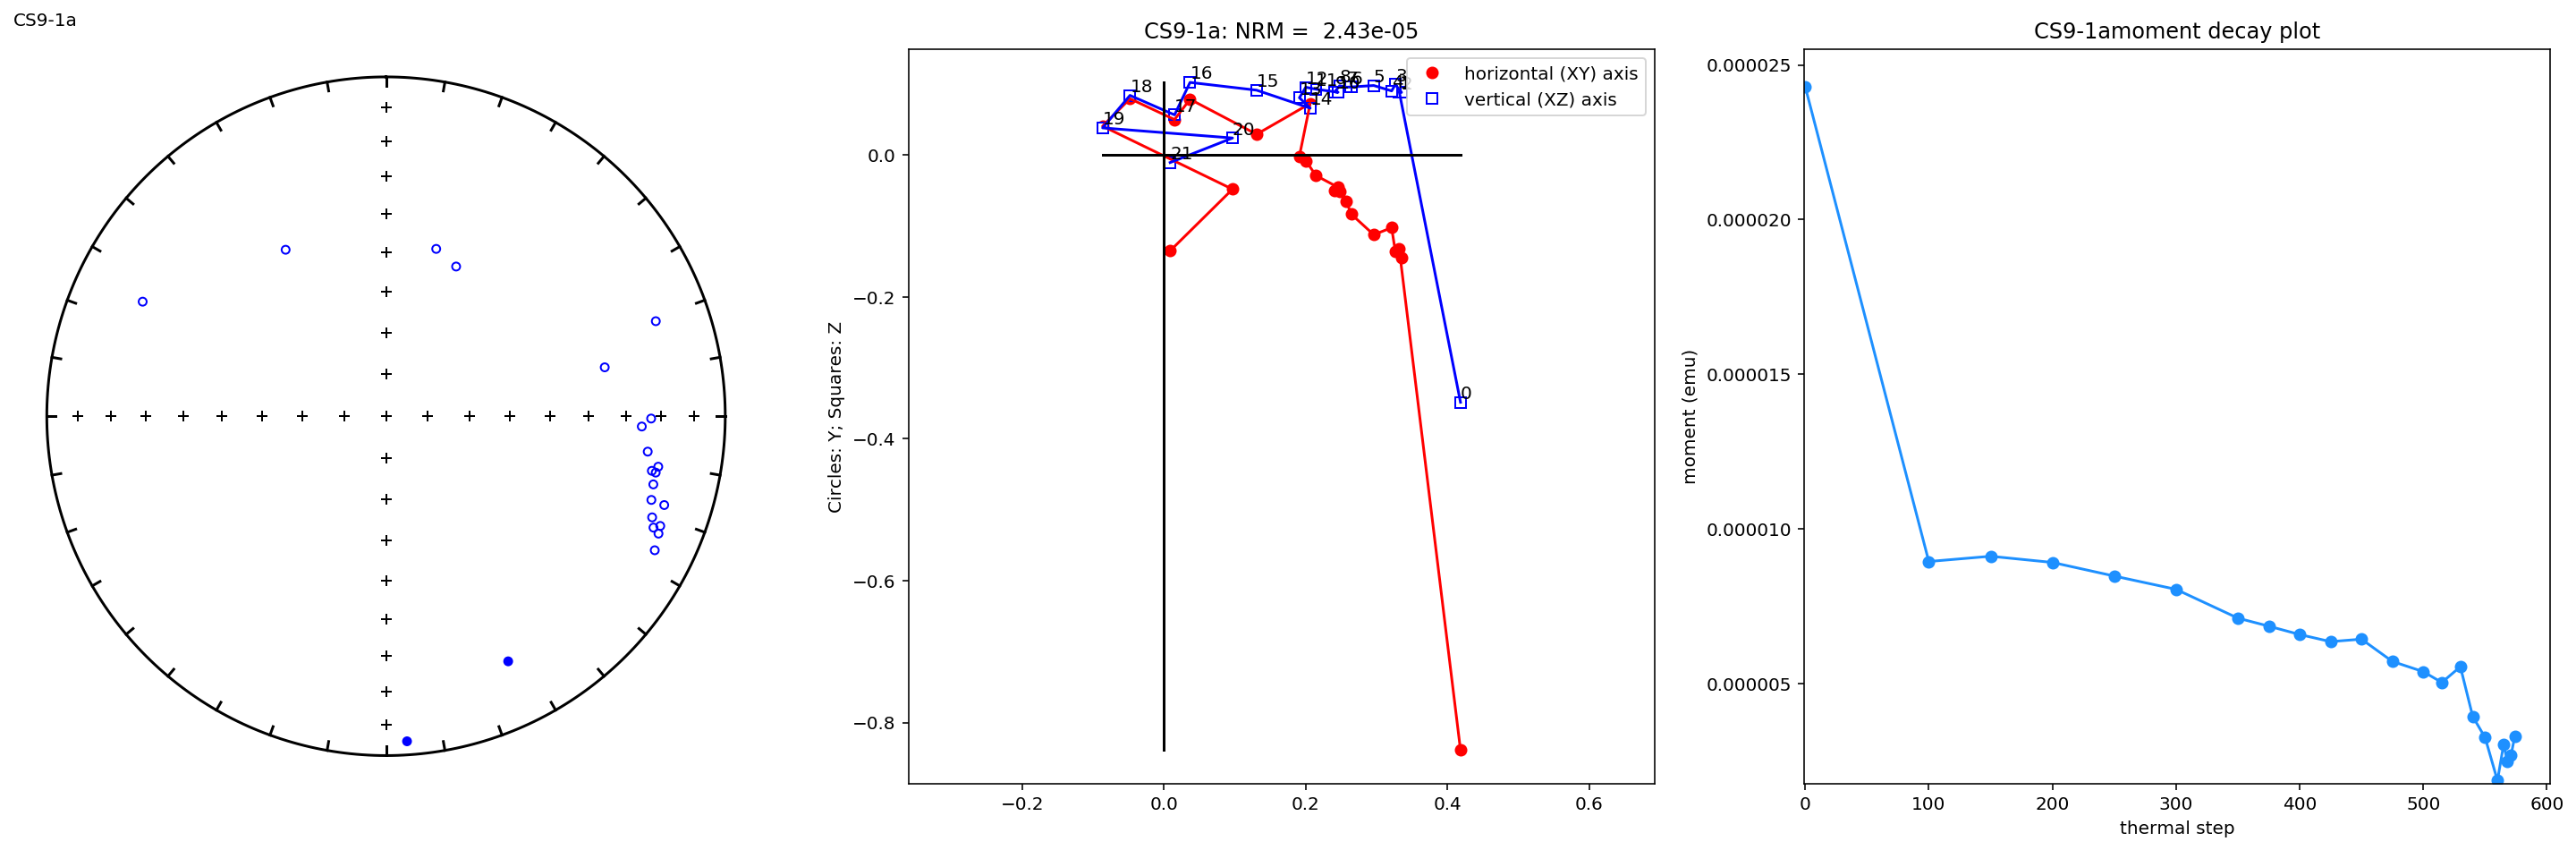

In [99]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS9_1a_SRM_file[['dec','inc']].values.tolist(), 'CS9-1a')
fig.add_subplot(132)
plot_zij(CS9_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS9-1a')
fig.add_subplot(133)
CS9_1a_SRM_step, CS9_1a_SRM_Ms = plot_mag(CS9_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS9-1a')
plt.subplots_adjust(wspace = 0.2 )

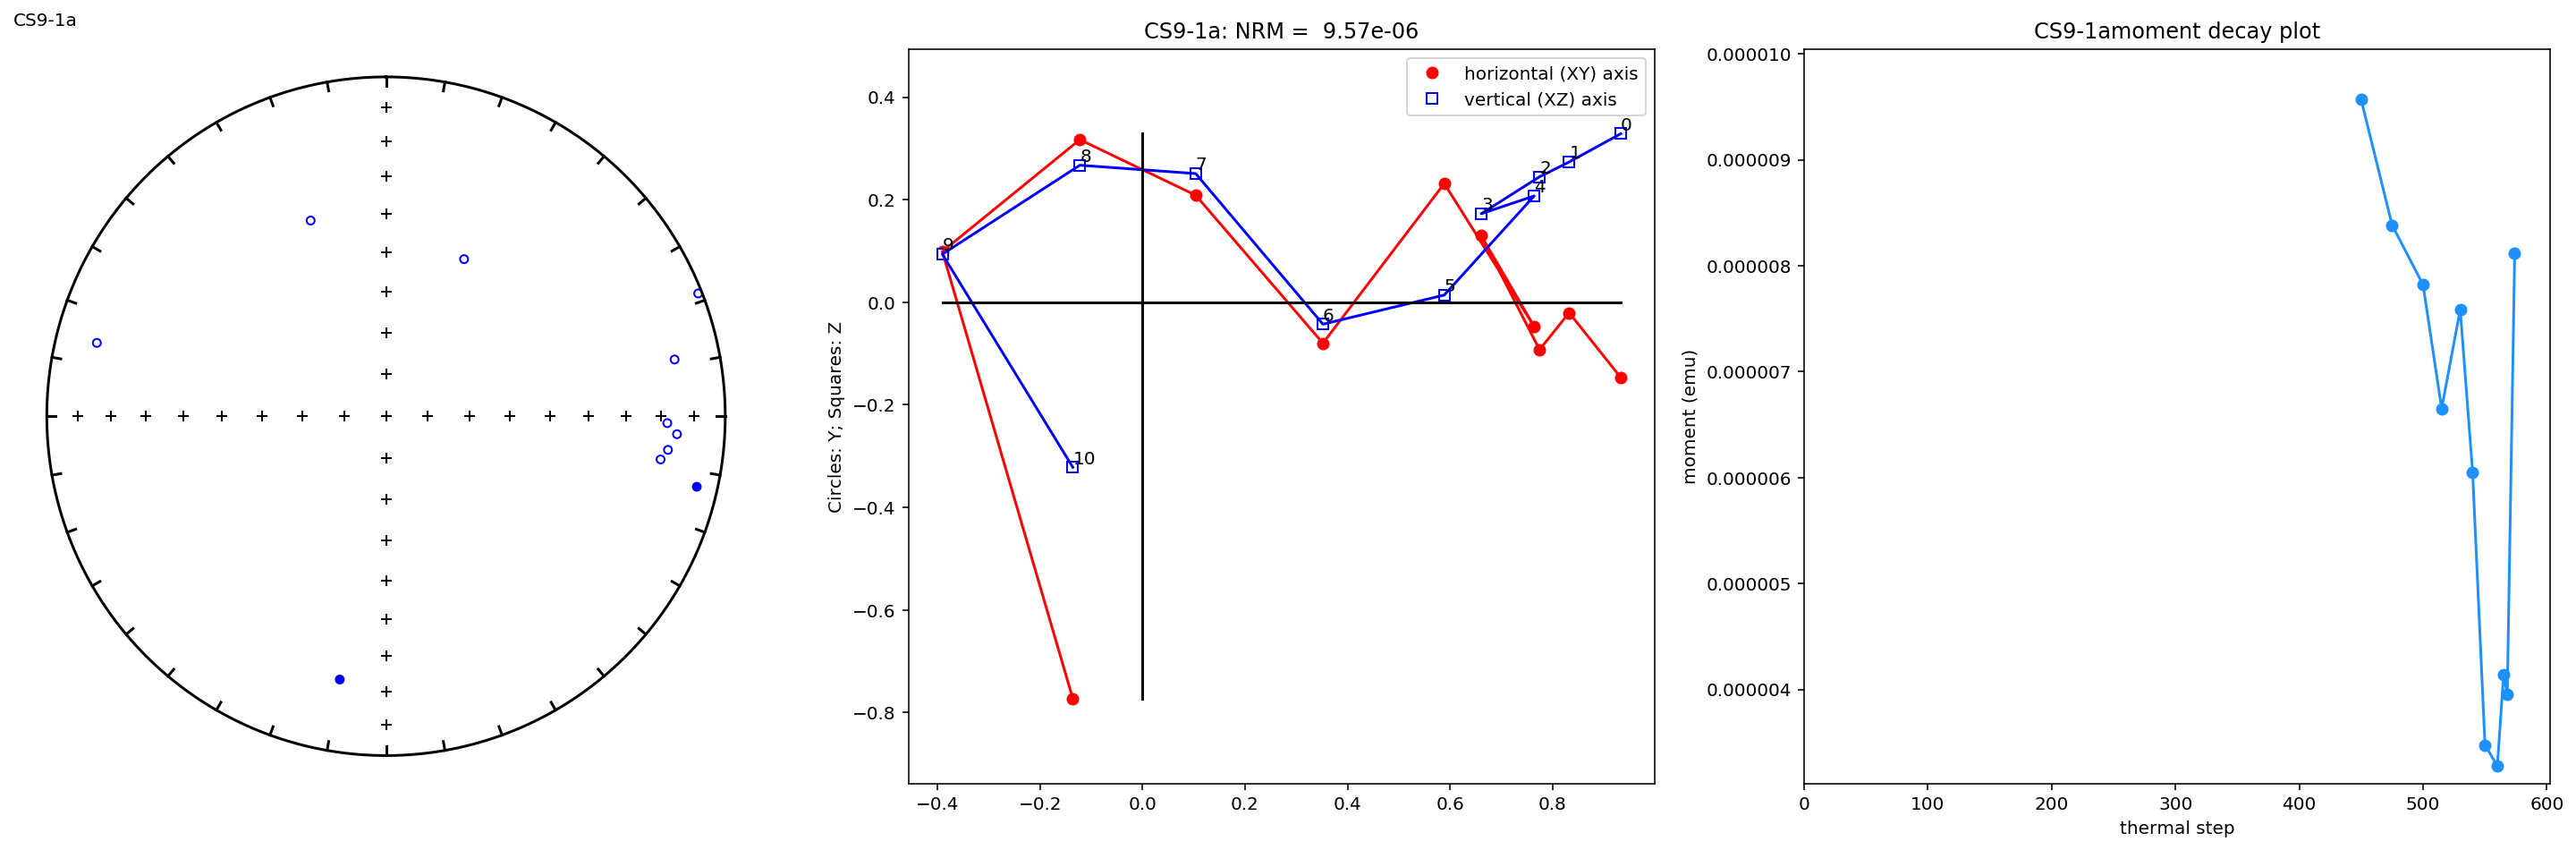

In [100]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS9_1a_OPRM_file_mean[['dec','inc']].values.tolist(), 'CS9-1a')
fig.add_subplot(132)
plot_zij(CS9_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS9-1a')
fig.add_subplot(133)
CS9_1a_OPRM_step, CS9_1a_OPRM_Ms = plot_mag(CS9_1a_OPRM_file_mean[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS9-1a')
plt.subplots_adjust(wspace = 0.2 )

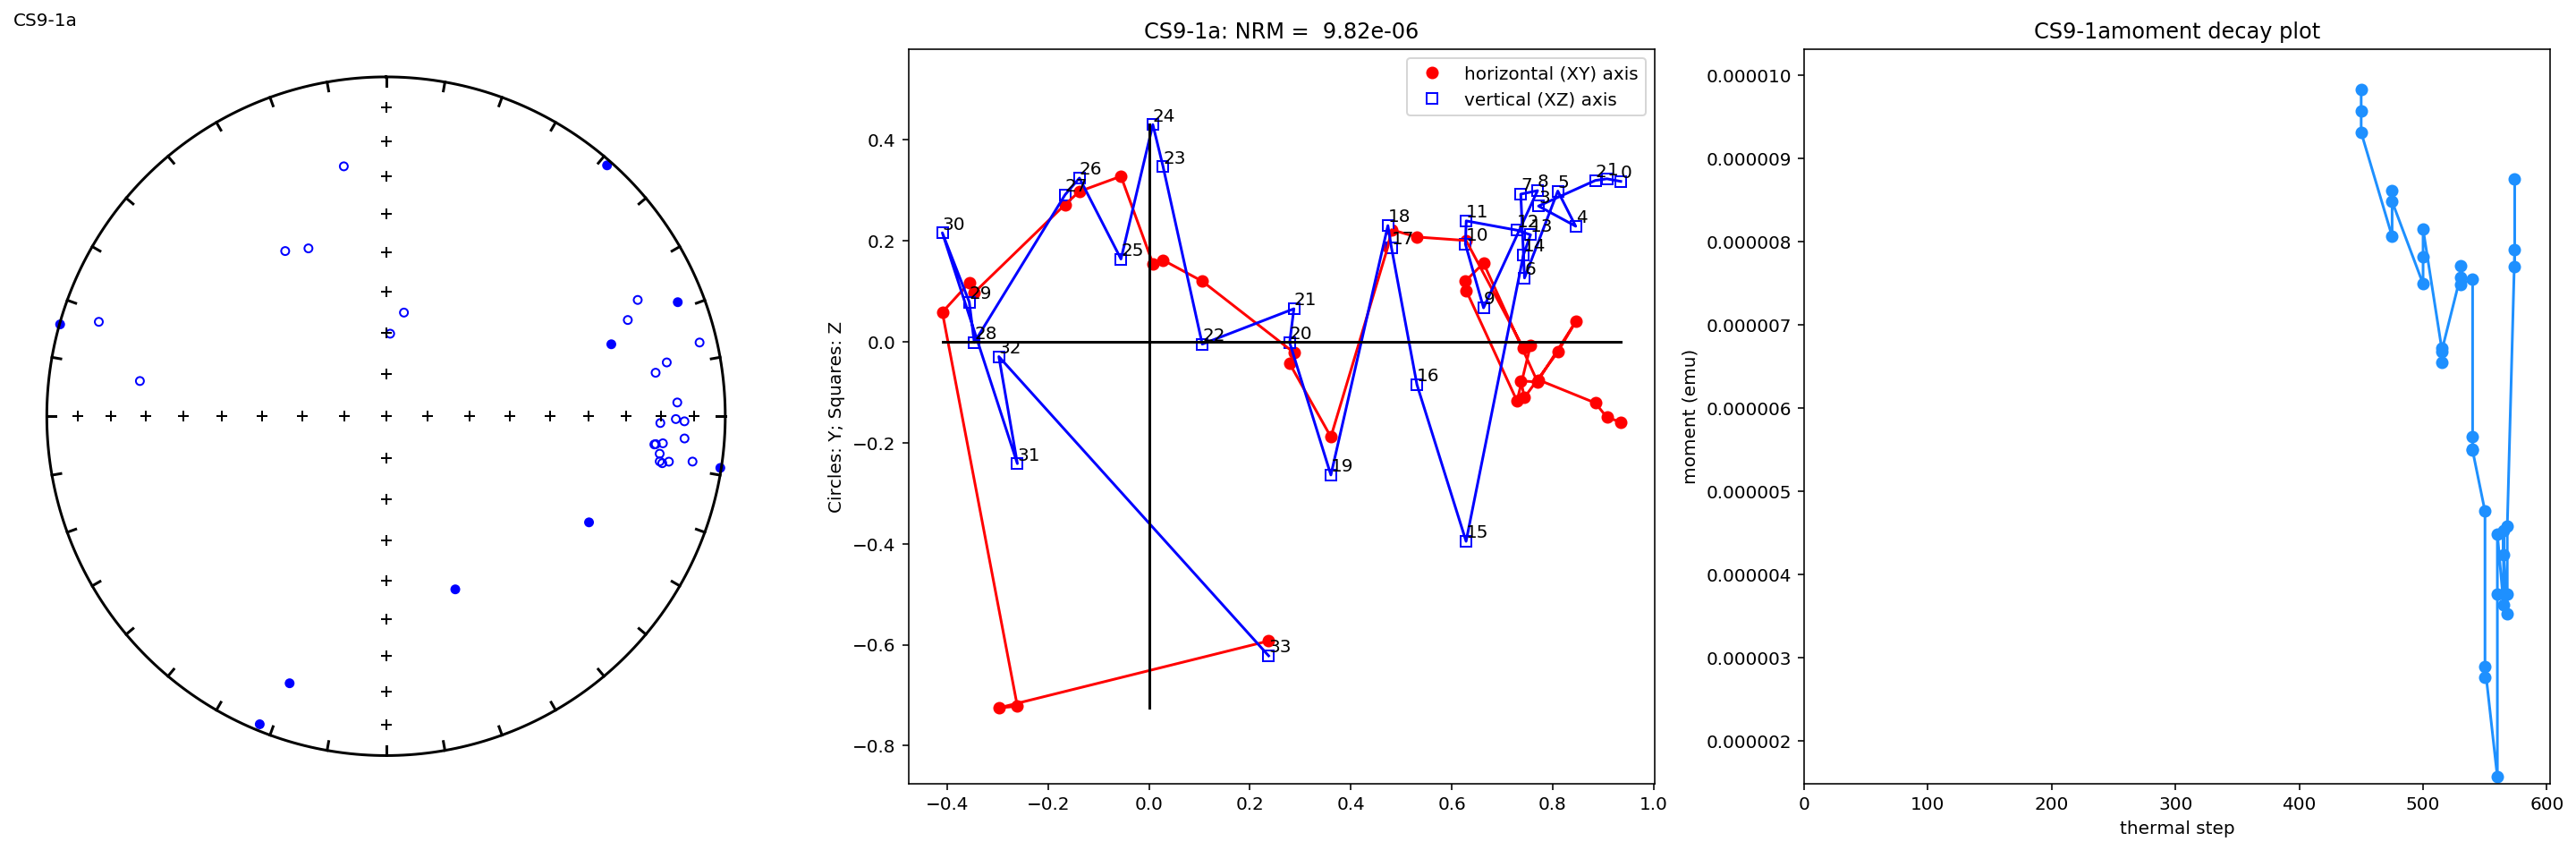

In [101]:
fig=plt.figure(1, (20,6)) # make a figure

fig.add_subplot(131)
plot_eq(CS9_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS9-1a')
fig.add_subplot(132)
plot_zij(CS9_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),'CS9-1a')
fig.add_subplot(133)
CS9_1a_OPRM_step_all, CS9_1a_OPRM_Ms_all  = plot_mag(CS9_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(), 'CS9-1a')
plt.subplots_adjust(wspace = 0.2 )

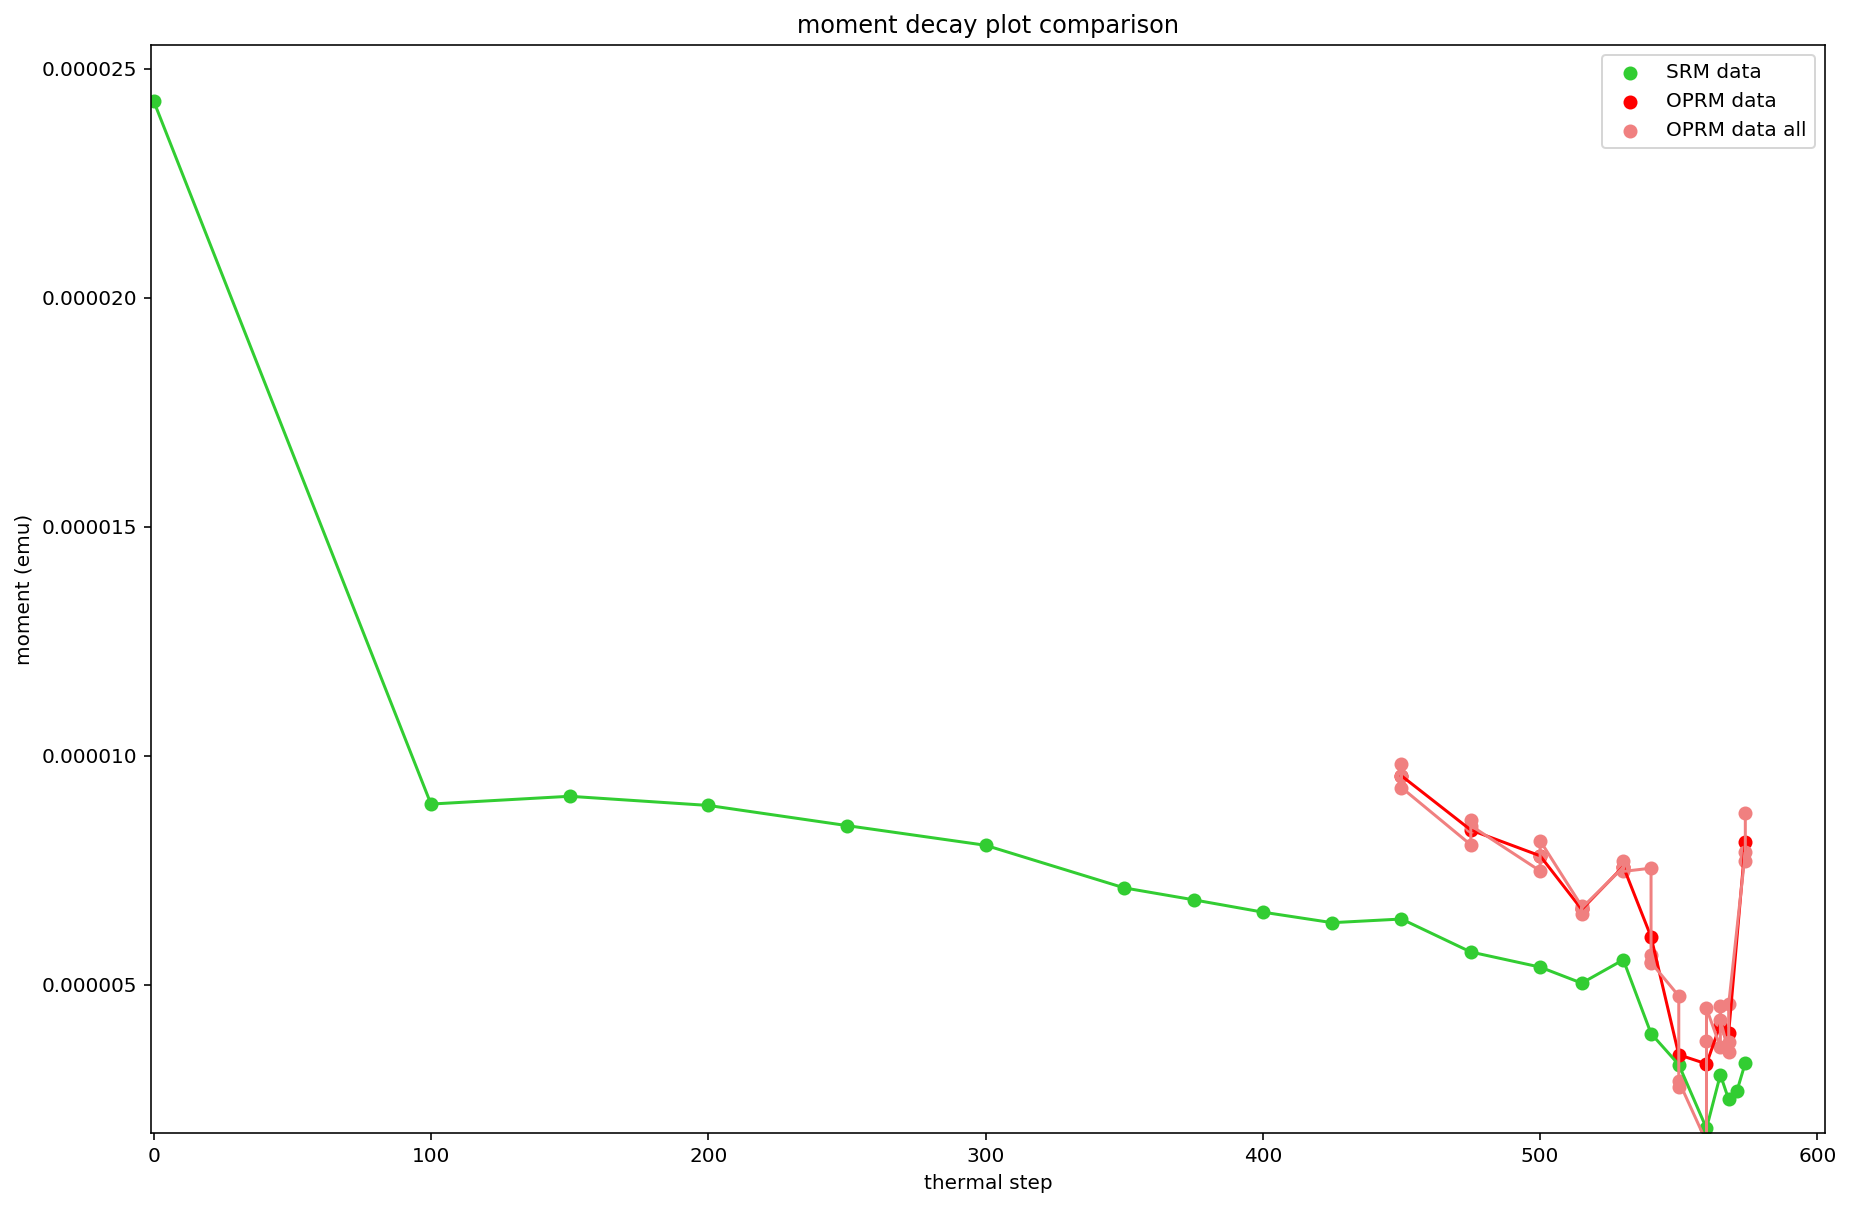

In [102]:
moment_comparison(CS9_1a_SRM_step, CS9_1a_SRM_Ms, CS9_1a_OPRM_step, CS9_1a_OPRM_Ms, CS9_1a_OPRM_step_all, CS9_1a_OPRM_Ms_all, 'CS9-1a')

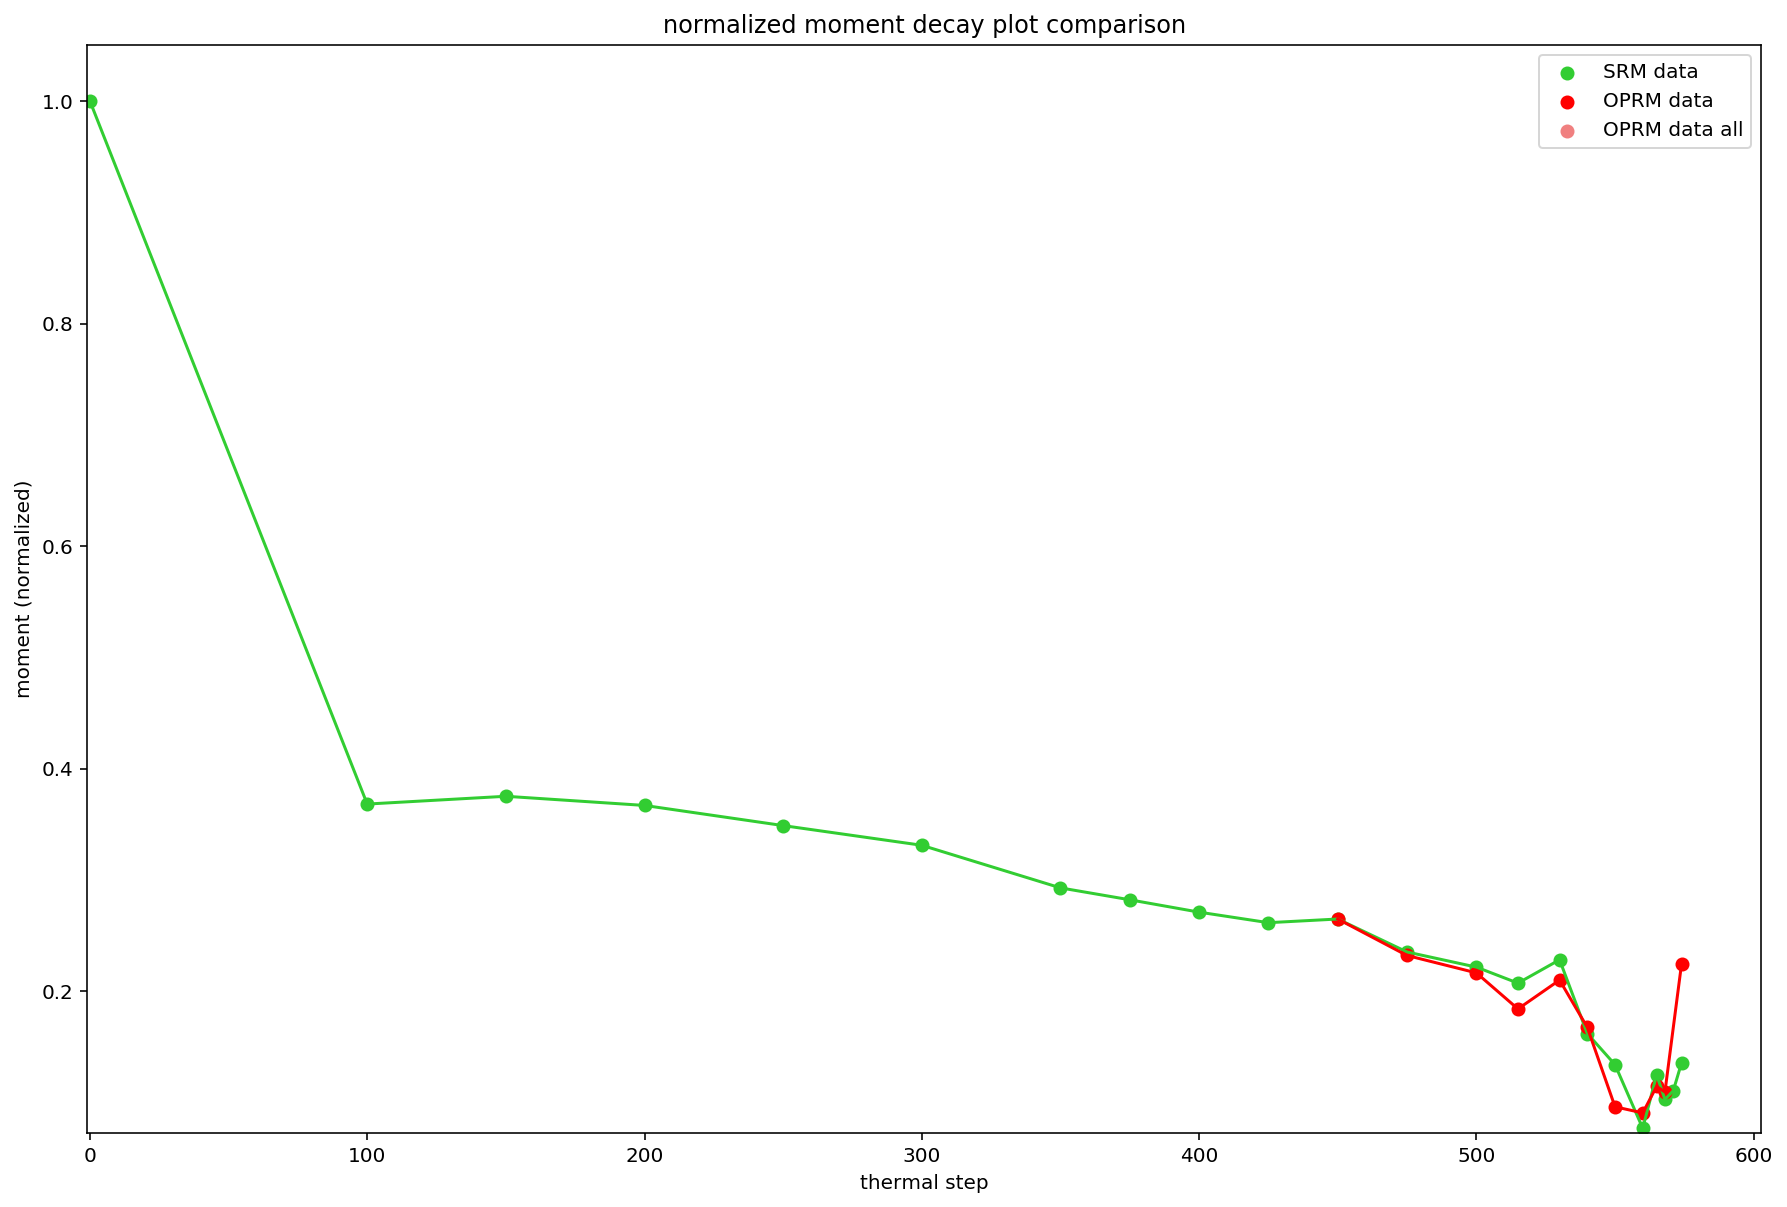

In [103]:
moment_comparison_normalized(CS9_1a_SRM_step, CS9_1a_SRM_Ms, CS9_1a_OPRM_step, CS9_1a_OPRM_Ms, CS9_1a_OPRM_step_all, CS9_1a_OPRM_Ms_all, 'CS9-1a')

## compare least square fit between SRM and OPRM data

In [104]:
OPRM_SRM_fit_combine = pd.read_csv('OPRM_SRM_fit_combine.csv')
OPRM_SRM_fit_combine.head()

specimen      experiments sample  dir_alpha95 dir_comp  dir_dec   dir_inc  \
0   CS1-1a  CS1-1a_LP-DIR-T  CS1-1          NaN  SRM_fit 2.20E+02 -1.12E+01   
1   CS2-1a  CS2-1a_LP-DIR-T  CS2-1          NaN  SRM_fit 1.38E+02 -9.90E+00   
2   CS3-1a  CS3-1a_LP-DIR-T  CS3-1          NaN  SRM_fit 5.81E+01  7.18E+01   
3   CS7-1a  CS7-1a_LP-DIR-T  CS7-1          NaN  SRM_fit 3.60E+00  5.80E+01   
4   CS8-1a  CS8-1a_LP-DIR-T  CS8-1          NaN  SRM_fit 3.48E+02  5.20E+01   

   dir_n_comps  dir_n_measurements  dir_tilt_correction  ...  \
0            1                  12                   -1  ...   
1            1                   9                   -1  ...   
2            1                  18                   -1  ...   
3            1                  17                   -1  ...   
4            1                   9                   -1  ...   

               instrument_codes           software_packages  int_corr  \
0  hargrave 2021-08-13 12:50:55  pmagpy-4.2.24-1: demag_gui         u   
1  hargrave 2021-08-13 13:01:44  pmagpy-4.2.24-1: demag_gui         u   
2  hargrave 2021-08-13 13:15:11  pmagpy-4.2.24-1: demag_gui         u   
3  hargrave 2021-07-21 08:52:20  pmagpy-4.2.24-1: demag_gui         u   
4  hargrave 2021-07-07 16:46:53  pmagpy-4.2.24-1: demag_gui         u   

    citations            method_codes  result_quality volume weight location  \
0  This study  LP-DIR-T:DE-BFL:DA-DIR               g    NaN    NaN  unknown   
1  This study  LP-DIR-T:DE-BFL:DA-DIR               g    NaN    NaN  unknown   
2  This study  LP-DIR-T:DE-BFL:DA-DIR               g    NaN    NaN  unknown   
3  This study  LP-DIR-T:DE-BFL:DA-DIR               g    NaN    NaN  unknown   
4  This study  LP-DIR-T:DE-BFL:DA-DIR               g    NaN    NaN  unknown   

  site  
0  CS1  
1  CS2  
2  CS3  
3  CS7  
4  CS8  

[5 rows x 26 columns]

In [105]:
SRM_fit = OPRM_SRM_fit_combine[OPRM_SRM_fit_combine['dir_comp'] == 'SRM_fit']
OPRM_fit = OPRM_SRM_fit_combine[OPRM_SRM_fit_combine['dir_comp'] == 'OPRM_fit']
OPRM_average = OPRM_SRM_fit_combine[OPRM_SRM_fit_combine['dir_comp'] == 'OPRM_fit_average']


marker_list = ['o', 's', 'd', '^', 'p', 'h']
color_list = ['red', 'blue', 'dodgerblue']


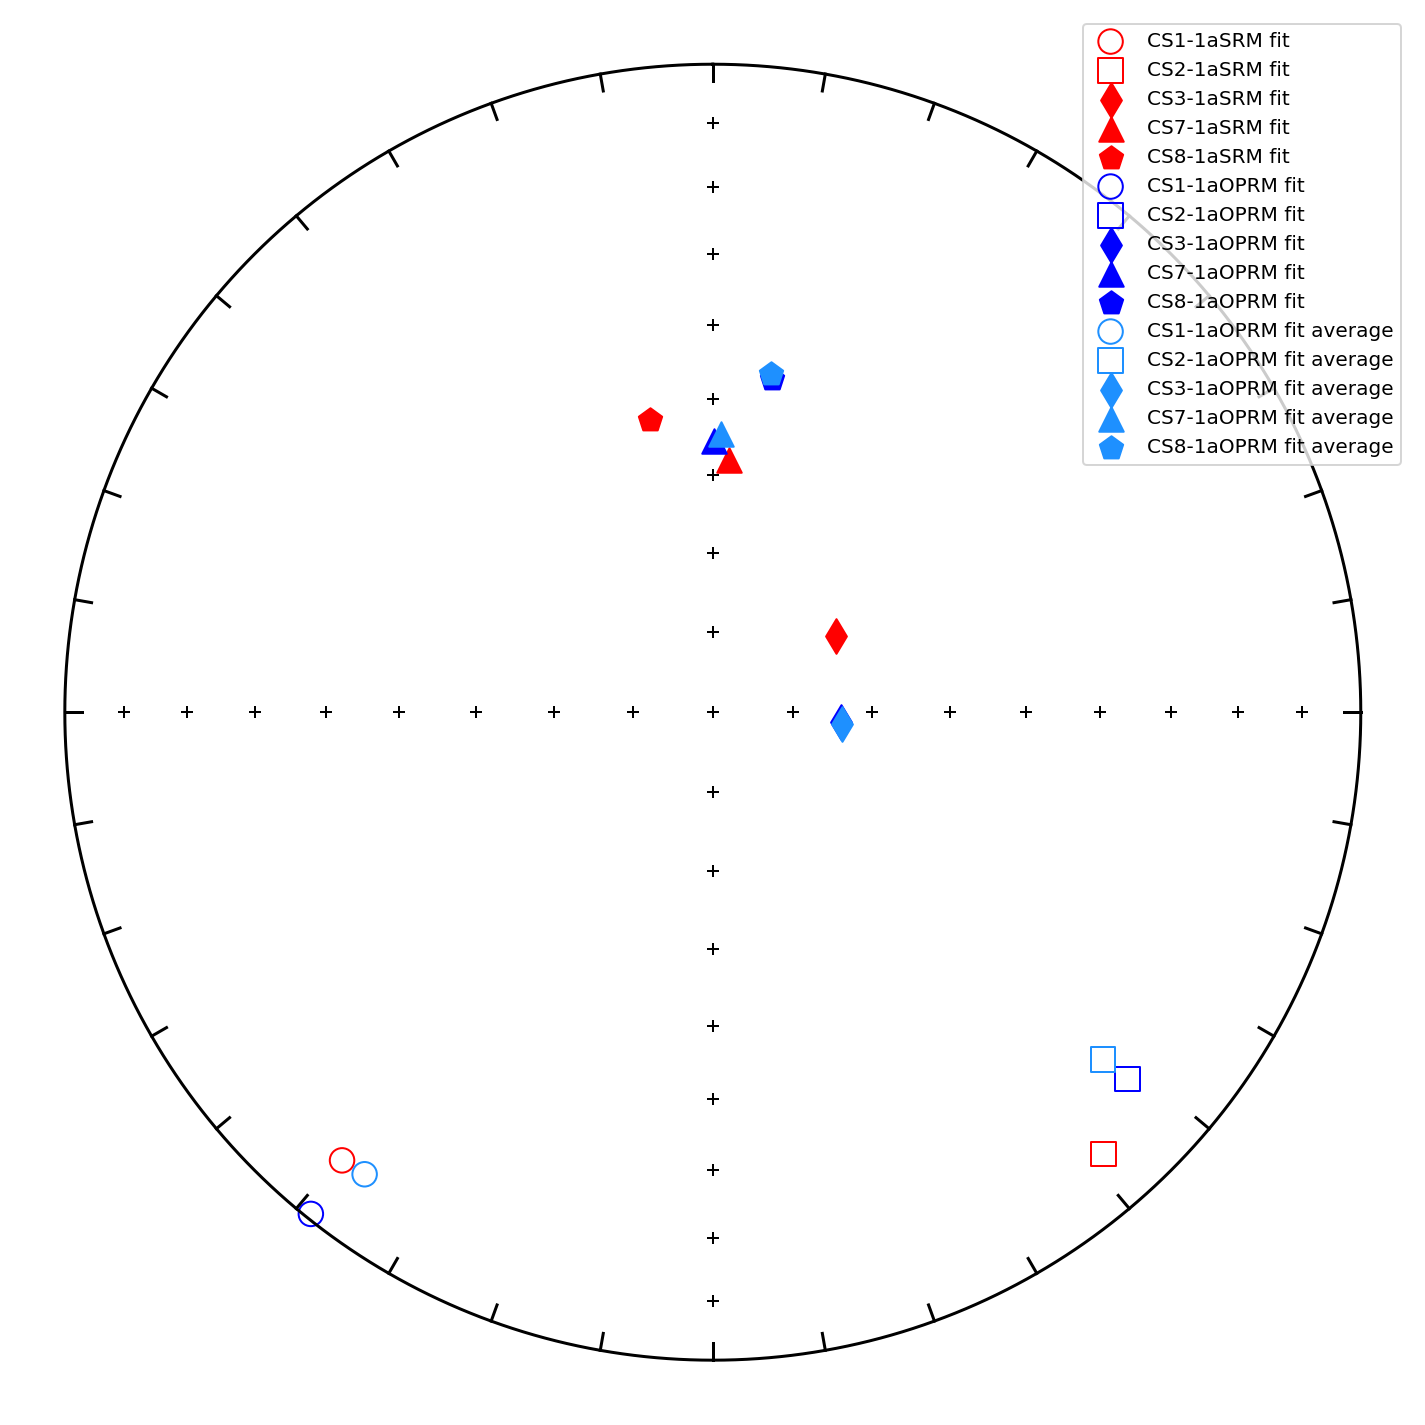

In [106]:
plt.figure(figsize=(10,10))
ipmag.plot_net()

for i in range(SRM_fit.shape[0]):
    ipmag.plot_di(SRM_fit['dir_dec'].tolist()[i], SRM_fit['dir_inc'].tolist()[i], 
                  color = color_list[0], marker = marker_list[i], markersize = 150, label = SRM_fit['specimen'].tolist()[i]+'SRM fit')
    
for i in range(OPRM_fit.shape[0]):
    ipmag.plot_di(OPRM_fit['dir_dec'].tolist()[i], OPRM_fit['dir_inc'].tolist()[i], 
                  color = color_list[1], marker = marker_list[i], markersize = 150, label = OPRM_fit['specimen'].tolist()[i]+'OPRM fit')
    
for i in range(OPRM_average.shape[0]):
    ipmag.plot_di(OPRM_average['dir_dec'].tolist()[i], OPRM_average['dir_inc'].tolist()[i], 
                  color = color_list[2], marker = marker_list[i], markersize = 150, label = OPRM_average['specimen'].tolist()[i]+'OPRM fit average')
    
plt.legend(loc='upper right')
# plt.title('Basalt sample \nOPRM vs. SRM\n mean angular difference: ' +str(round(GB1_2b_angle[0], 2)))
# plt.savefig('Figures/GB1_2b_equall_area.pdf', bbox_inches='tight')
plt.show()